# Receiver Function

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

We refer you to the paper below for description of the algorithms and the forward kernel we use:

*Genetic algorithm inversion for receiver functions with application to crust and uppermost mantle structure beneath Eastern Australia*,
Shibutani, T., Kennett, B. and Sambridge, M., Geophys. Res. Lett., 23 , No. 4, 1829-1832, 1996.

In this notebook, we run inversion on a toy model with optimisation and parallel sampling.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import emcee
import multiprocessing

import cofi
import espresso

In [3]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

We are going to use the receiver function kernel wrapped in 
[`espresso`](https://geo-espresso.readthedocs.io/en/latest/user_guide/contrib/generated/_receiver_function/index.html),
with calls to Fortran routines developed by Takuo Shibutani in the backend.

In [4]:
my_receiver_function = espresso.ReceiverFunctionInversionShibutani(example_number=4)

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

In this example, we fix the ratio of S-wave speed to P-wave speed, and treat the interface depths and velocities of 5 layers as unknowns.

In order to better understand the complexity and non-linear nature of seismic receiver function inversion, we have included a few illustrative animations. These animations highlight the substantial influence of velocities and, more prominently, interface depths on the resulting receiver functions.

![depth_layer3_anim4.gif](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/depth_layer3_anim4.gif?raw=true)

![vel_layer3_anim4_400f.gif](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/vel_layer3_anim4_400f.gif?raw=true)

This is a non-linear problem which can be highly sensitive to the starting model. 

![3Dsurf_x40y10_v55_l270_35](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/3Dsurf_x40y10_v55_l270_35.png?raw=true)

Here we set a starting model that is reasonably close to the true model, so that the optimisation converges.

In [5]:
null_model = my_receiver_function.starting_model 

print(f"Number of model parameters in this example: {null_model.size}")
my_receiver_function._model_setup(null_model)

Number of model parameters in this example: 6


array([[ 9. ,  3.2,  1.7],
       [20. ,  4. ,  1.7],
       [50. ,  4.3,  1.7]])

Let's plot the starting Earth model.

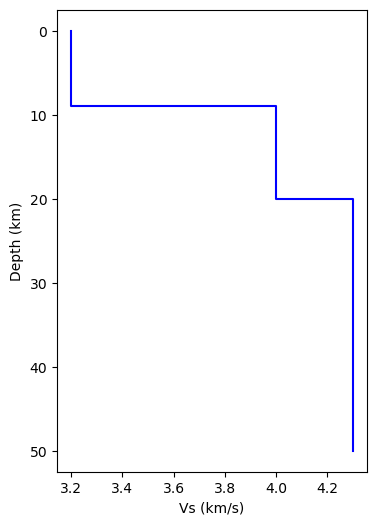

In [6]:
my_receiver_function.plot_model(null_model);

Now we calculate the receiver function and plot it

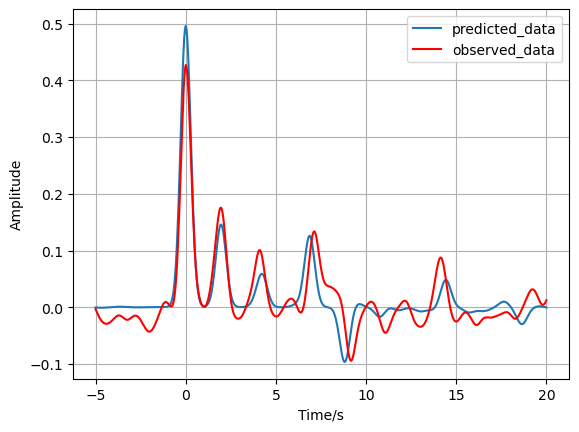

In [7]:
predicted_data = my_receiver_function.forward(null_model)
observed_data = my_receiver_function.data 
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 1. Solve with an optimiser

### 1.1 Define BaseProblem

In [8]:
my_problem = cofi.BaseProblem()

In preparation for optimisation:

In [9]:
def my_misfit(model, include_uncertainty=False):
    predicted_data = my_receiver_function.forward(model)
    misfit_val = my_receiver_function.misfit(predicted_data, observed_data)
    if math.isnan(misfit_val):
        return float("inf")
    return misfit_val

my_problem.set_objective(my_misfit)
my_problem.set_initial_model(null_model)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (6,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### 1.2 Define InversionOptions

In [10]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")   # Nelder-Mead or COBYLA

### 1.3 Define Inversion and run

In [11]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 7594.579701600368
nit: 457
nfev: 787
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[11.27274409,  2.96058687, 17.33057438,  3.86879402, 46.71754491,
         4.44290912],
       [11.27274396,  2.96058684, 17.33057417,  3.86879402, 46.71754518,
         4.44290913],
       [11.2727441 ,  2.96058684, 17.33057403,  3.868794  , 46.71754502,
         4.44290911],
       [11.27274448,  2.9605868 , 17.33057329,  3.86879393, 46.71754472,
         4.44290904],
       [11.27274444,  2.96058682, 17.33057346,  3.86879392, 46.71754475,
         4.44290905],
       [11.27274465,  2.96058681, 17.33057318,  3.86879389, 46.71754456,
         4.44290902],
       [11.27274386,  2.96058685, 17.33057436,  3.86879404, 46.71754524,
         4.44290915]]), array([7594.5797016, 7594.5797016, 7594.5797016, 7594.5797016,
       7594.5797016, 7594.5797016, 7594.5797016]))
model: [11.27274409  2.96058687 17.330

In [12]:
print("Inversion result:    ", my_result_optimiser.model)
print("Reference good model:", my_receiver_function.good_model)

Inversion result:     [11.27274409  2.96058687 17.33057438  3.86879402 46.71754491  4.44290912]
Reference good model: [ 8.   3.  20.   3.9 45.   4.4]


### 1.4 Plotting

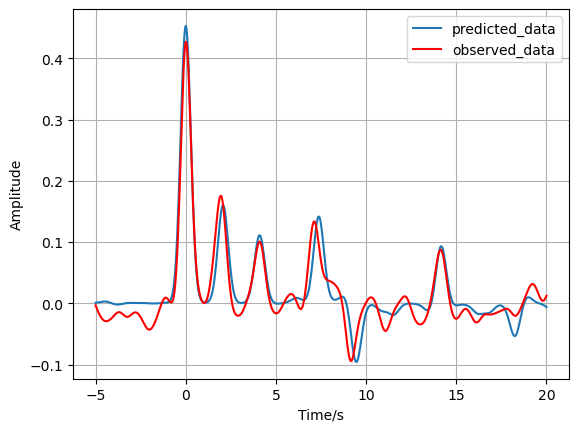

In [13]:
predicted_data = my_receiver_function.forward(my_result_optimiser.model)
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 2. Solve with a sampler

### 2.1 Enrich BaseProblem

In preparation for sampling:

In [14]:
def my_log_likelihood(model):
    data1 = my_receiver_function.data
    data2 = my_receiver_function.forward(model)
    log_likelihood = my_receiver_function.log_likelihood(data1, data2) / 20 # temper the likelihood
    return log_likelihood

def my_log_prior(model):
    log_prior = my_receiver_function.log_prior(model)
    return log_prior

ndim = my_receiver_function.model_size

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 6
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


In [15]:
nwalkers = 12
nsteps = 25000
walkers_start = my_result_optimiser.model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

### 2.2 Define InversionOptions, Inversion and run

In [16]:
import warnings
warnings.filterwarnings("ignore")

my_options_sampler = cofi.InversionOptions()
my_options_sampler.set_tool("emcee")
my_options_sampler.set_params(
    nwalkers=nwalkers,
    nsteps=nsteps,
    initial_state=walkers_start,
    progress=True,
)
inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
inv_result_sampler = inv_sampler.run()

  0%|                                                                           | 0/25000 [00:00<?, ?it/s]

  0%|                                                                 | 11/25000 [00:00<04:07, 100.81it/s]

  0%|                                                                  | 22/25000 [00:00<04:46, 87.26it/s]

  0%|                                                                  | 31/25000 [00:00<05:02, 82.64it/s]

  0%|                                                                  | 40/25000 [00:00<05:13, 79.57it/s]

  0%|▏                                                                 | 48/25000 [00:00<05:19, 78.20it/s]

  0%|▏                                                                 | 56/25000 [00:00<05:28, 75.99it/s]

  0%|▏                                                                 | 64/25000 [00:00<05:29, 75.65it/s]

  0%|▏                                                                 | 72/25000 [00:00<05:30, 75.41it/s]

  0%|▏                                                                 | 80/25000 [00:01<05:31, 75.19it/s]

  0%|▏                                                                 | 88/25000 [00:01<05:31, 75.09it/s]

  0%|▎                                                                 | 96/25000 [00:01<05:31, 75.02it/s]

  0%|▎                                                                | 104/25000 [00:01<05:32, 74.99it/s]

  0%|▎                                                                | 112/25000 [00:01<05:31, 74.96it/s]

  0%|▎                                                                | 120/25000 [00:01<05:31, 74.96it/s]

  1%|▎                                                                | 128/25000 [00:01<05:31, 74.97it/s]

  1%|▎                                                                | 136/25000 [00:01<05:38, 73.41it/s]

  1%|▎                                                                | 144/25000 [00:01<05:36, 73.81it/s]

  1%|▍                                                                | 152/25000 [00:01<05:35, 74.10it/s]

  1%|▍                                                                | 160/25000 [00:02<05:34, 74.36it/s]

  1%|▍                                                                | 168/25000 [00:02<05:33, 74.55it/s]

  1%|▍                                                                | 176/25000 [00:02<05:32, 74.68it/s]

  1%|▍                                                                | 184/25000 [00:02<05:40, 72.86it/s]

  1%|▍                                                                | 192/25000 [00:02<05:37, 73.45it/s]

  1%|▌                                                                | 200/25000 [00:02<05:35, 73.92it/s]

  1%|▌                                                                | 208/25000 [00:02<05:33, 74.24it/s]

  1%|▌                                                                | 216/25000 [00:02<05:32, 74.46it/s]

  1%|▌                                                                | 224/25000 [00:02<05:36, 73.60it/s]

  1%|▌                                                                | 232/25000 [00:03<05:58, 69.09it/s]

  1%|▌                                                                | 240/25000 [00:03<05:45, 71.71it/s]

  1%|▋                                                                | 248/25000 [00:03<05:39, 72.86it/s]

  1%|▋                                                                | 256/25000 [00:03<05:31, 74.73it/s]

  1%|▋                                                                | 264/25000 [00:03<05:29, 75.01it/s]

  1%|▋                                                                | 272/25000 [00:03<05:27, 75.42it/s]

  1%|▋                                                                | 281/25000 [00:03<05:16, 78.16it/s]

  1%|▊                                                                | 289/25000 [00:03<05:18, 77.57it/s]

  1%|▊                                                                | 298/25000 [00:03<05:11, 79.43it/s]

  1%|▊                                                                | 307/25000 [00:04<05:07, 80.33it/s]

  1%|▊                                                                | 316/25000 [00:04<05:08, 80.00it/s]

  1%|▊                                                                | 325/25000 [00:04<05:08, 79.95it/s]

  1%|▊                                                                | 334/25000 [00:04<05:07, 80.12it/s]

  1%|▉                                                                | 343/25000 [00:04<05:05, 80.63it/s]

  1%|▉                                                                | 352/25000 [00:04<05:30, 74.65it/s]

  1%|▉                                                                | 361/25000 [00:04<05:17, 77.55it/s]

  1%|▉                                                                | 370/25000 [00:04<05:12, 78.88it/s]

  2%|▉                                                                | 380/25000 [00:04<04:55, 83.23it/s]

  2%|█                                                                | 389/25000 [00:05<04:51, 84.51it/s]

  2%|█                                                                | 398/25000 [00:05<04:48, 85.24it/s]

  2%|█                                                                | 407/25000 [00:05<04:49, 84.82it/s]

  2%|█                                                                | 417/25000 [00:05<04:44, 86.32it/s]

  2%|█                                                                | 426/25000 [00:05<04:42, 86.99it/s]

  2%|█▏                                                               | 436/25000 [00:05<04:34, 89.35it/s]

  2%|█▏                                                               | 445/25000 [00:05<04:36, 88.85it/s]

  2%|█▏                                                               | 454/25000 [00:05<04:37, 88.49it/s]

  2%|█▏                                                               | 464/25000 [00:05<04:34, 89.49it/s]

  2%|█▏                                                               | 474/25000 [00:06<04:27, 91.61it/s]

  2%|█▎                                                               | 484/25000 [00:06<04:28, 91.29it/s]

  2%|█▎                                                               | 494/25000 [00:06<04:30, 90.55it/s]

  2%|█▎                                                               | 504/25000 [00:06<04:30, 90.56it/s]

  2%|█▎                                                               | 514/25000 [00:06<04:29, 91.02it/s]

  2%|█▎                                                               | 524/25000 [00:06<04:27, 91.64it/s]

  2%|█▍                                                               | 534/25000 [00:06<04:27, 91.30it/s]

  2%|█▍                                                               | 544/25000 [00:06<04:31, 90.10it/s]

  2%|█▍                                                               | 554/25000 [00:06<04:31, 90.15it/s]

  2%|█▍                                                               | 564/25000 [00:07<04:32, 89.74it/s]

  2%|█▍                                                               | 574/25000 [00:07<04:31, 90.00it/s]

  2%|█▌                                                               | 584/25000 [00:07<04:24, 92.22it/s]

  2%|█▌                                                               | 594/25000 [00:07<04:19, 94.10it/s]

  2%|█▌                                                               | 604/25000 [00:07<04:16, 95.18it/s]

  2%|█▌                                                               | 614/25000 [00:07<04:25, 91.92it/s]

  2%|█▌                                                               | 624/25000 [00:07<04:27, 91.26it/s]

  3%|█▋                                                               | 634/25000 [00:07<04:24, 92.06it/s]

  3%|█▋                                                               | 644/25000 [00:07<04:24, 92.15it/s]

  3%|█▋                                                               | 654/25000 [00:07<04:20, 93.47it/s]

  3%|█▋                                                               | 665/25000 [00:08<04:11, 96.76it/s]

  3%|█▊                                                               | 675/25000 [00:08<04:12, 96.46it/s]

  3%|█▊                                                               | 685/25000 [00:08<04:23, 92.45it/s]

  3%|█▊                                                               | 695/25000 [00:08<04:19, 93.64it/s]

  3%|█▊                                                               | 705/25000 [00:08<04:32, 89.09it/s]

  3%|█▊                                                               | 714/25000 [00:08<04:36, 87.88it/s]

  3%|█▉                                                               | 723/25000 [00:08<04:36, 87.76it/s]

  3%|█▉                                                               | 732/25000 [00:08<04:34, 88.33it/s]

  3%|█▉                                                               | 741/25000 [00:08<04:35, 87.96it/s]

  3%|█▉                                                               | 750/25000 [00:09<04:39, 86.80it/s]

  3%|█▉                                                               | 759/25000 [00:09<04:36, 87.63it/s]

  3%|█▉                                                               | 768/25000 [00:09<04:34, 88.21it/s]

  3%|██                                                               | 777/25000 [00:09<04:34, 88.09it/s]

  3%|██                                                               | 787/25000 [00:09<04:27, 90.49it/s]

  3%|██                                                               | 797/25000 [00:09<04:25, 91.32it/s]

  3%|██                                                               | 807/25000 [00:09<04:23, 91.65it/s]

  3%|██                                                               | 817/25000 [00:09<04:28, 90.06it/s]

  3%|██▏                                                              | 827/25000 [00:09<04:30, 89.28it/s]

  3%|██▏                                                              | 837/25000 [00:10<04:25, 91.04it/s]

  3%|██▏                                                              | 847/25000 [00:10<04:25, 90.94it/s]

  3%|██▏                                                              | 857/25000 [00:10<04:29, 89.61it/s]

  3%|██▎                                                              | 866/25000 [00:10<04:34, 87.84it/s]

  4%|██▎                                                              | 875/25000 [00:10<04:34, 87.77it/s]

  4%|██▎                                                              | 885/25000 [00:10<04:30, 89.10it/s]

  4%|██▎                                                              | 895/25000 [00:10<04:25, 90.81it/s]

  4%|██▎                                                              | 905/25000 [00:10<04:22, 91.75it/s]

  4%|██▍                                                              | 915/25000 [00:10<04:21, 92.15it/s]

  4%|██▍                                                              | 925/25000 [00:10<04:24, 91.09it/s]

  4%|██▍                                                              | 935/25000 [00:11<04:26, 90.40it/s]

  4%|██▍                                                              | 945/25000 [00:11<04:32, 88.26it/s]

  4%|██▍                                                              | 955/25000 [00:11<04:28, 89.68it/s]

  4%|██▌                                                              | 965/25000 [00:11<04:26, 90.15it/s]

  4%|██▌                                                              | 975/25000 [00:11<04:32, 88.04it/s]

  4%|██▌                                                              | 984/25000 [00:11<04:36, 87.00it/s]

  4%|██▌                                                              | 993/25000 [00:11<04:35, 87.00it/s]

  4%|██▌                                                             | 1002/25000 [00:11<04:33, 87.75it/s]

  4%|██▌                                                             | 1011/25000 [00:11<04:37, 86.52it/s]

  4%|██▌                                                             | 1021/25000 [00:12<04:33, 87.82it/s]

  4%|██▋                                                             | 1030/25000 [00:12<04:31, 88.34it/s]

  4%|██▋                                                             | 1040/25000 [00:12<04:27, 89.53it/s]

  4%|██▋                                                             | 1049/25000 [00:12<04:33, 87.50it/s]

  4%|██▋                                                             | 1058/25000 [00:12<04:34, 87.26it/s]

  4%|██▋                                                             | 1068/25000 [00:12<04:25, 90.13it/s]

  4%|██▊                                                             | 1078/25000 [00:12<04:22, 90.98it/s]

  4%|██▊                                                             | 1088/25000 [00:12<04:26, 89.84it/s]

  4%|██▊                                                             | 1098/25000 [00:12<04:18, 92.44it/s]

  4%|██▊                                                             | 1108/25000 [00:13<04:16, 93.18it/s]

  4%|██▊                                                             | 1118/25000 [00:13<04:21, 91.35it/s]

  5%|██▉                                                             | 1128/25000 [00:13<04:19, 91.92it/s]

  5%|██▉                                                             | 1138/25000 [00:13<04:23, 90.70it/s]

  5%|██▉                                                             | 1148/25000 [00:13<04:30, 88.20it/s]

  5%|██▉                                                             | 1157/25000 [00:13<04:32, 87.35it/s]

  5%|██▉                                                             | 1166/25000 [00:13<04:33, 87.05it/s]

  5%|███                                                             | 1175/25000 [00:13<04:31, 87.82it/s]

  5%|███                                                             | 1185/25000 [00:13<04:24, 89.98it/s]

  5%|███                                                             | 1195/25000 [00:14<04:21, 90.97it/s]

  5%|███                                                             | 1205/25000 [00:14<04:27, 89.08it/s]

  5%|███                                                             | 1214/25000 [00:14<04:34, 86.62it/s]

  5%|███▏                                                            | 1223/25000 [00:14<04:32, 87.22it/s]

  5%|███▏                                                            | 1233/25000 [00:14<04:25, 89.58it/s]

  5%|███▏                                                            | 1243/25000 [00:14<04:20, 91.25it/s]

  5%|███▏                                                            | 1253/25000 [00:14<04:26, 89.17it/s]

  5%|███▏                                                            | 1262/25000 [00:14<04:31, 87.46it/s]

  5%|███▎                                                            | 1272/25000 [00:14<04:28, 88.25it/s]

  5%|███▎                                                            | 1281/25000 [00:14<04:28, 88.40it/s]

  5%|███▎                                                            | 1291/25000 [00:15<04:26, 89.04it/s]

  5%|███▎                                                            | 1300/25000 [00:15<04:27, 88.47it/s]

  5%|███▎                                                            | 1309/25000 [00:15<04:29, 88.05it/s]

  5%|███▎                                                            | 1318/25000 [00:15<04:31, 87.38it/s]

  5%|███▍                                                            | 1327/25000 [00:15<04:35, 86.02it/s]

  5%|███▍                                                            | 1336/25000 [00:15<04:35, 85.83it/s]

  5%|███▍                                                            | 1345/25000 [00:15<04:36, 85.70it/s]

  5%|███▍                                                            | 1355/25000 [00:15<04:24, 89.25it/s]

  5%|███▍                                                            | 1365/25000 [00:15<04:22, 90.19it/s]

  6%|███▌                                                            | 1375/25000 [00:16<04:22, 90.02it/s]

  6%|███▌                                                            | 1385/25000 [00:16<04:21, 90.48it/s]

  6%|███▌                                                            | 1395/25000 [00:16<04:18, 91.30it/s]

  6%|███▌                                                            | 1405/25000 [00:16<04:22, 89.80it/s]

  6%|███▌                                                            | 1414/25000 [00:16<04:27, 88.22it/s]

  6%|███▋                                                            | 1423/25000 [00:16<04:26, 88.61it/s]

  6%|███▋                                                            | 1433/25000 [00:16<04:22, 89.72it/s]

  6%|███▋                                                            | 1443/25000 [00:16<04:21, 90.25it/s]

  6%|███▋                                                            | 1453/25000 [00:16<04:16, 91.82it/s]

  6%|███▋                                                            | 1463/25000 [00:17<04:21, 90.15it/s]

  6%|███▊                                                            | 1473/25000 [00:17<04:13, 92.87it/s]

  6%|███▊                                                            | 1483/25000 [00:17<04:12, 93.00it/s]

  6%|███▊                                                            | 1493/25000 [00:17<04:14, 92.39it/s]

  6%|███▊                                                            | 1503/25000 [00:17<04:15, 92.08it/s]

  6%|███▊                                                            | 1513/25000 [00:17<04:12, 93.18it/s]

  6%|███▉                                                            | 1523/25000 [00:17<04:12, 92.92it/s]

  6%|███▉                                                            | 1533/25000 [00:17<04:13, 92.68it/s]

  6%|███▉                                                            | 1543/25000 [00:17<04:17, 90.99it/s]

  6%|███▉                                                            | 1553/25000 [00:17<04:10, 93.45it/s]

  6%|████                                                            | 1563/25000 [00:18<04:08, 94.40it/s]

  6%|████                                                            | 1573/25000 [00:18<04:12, 92.73it/s]

  6%|████                                                            | 1583/25000 [00:18<04:16, 91.29it/s]

  6%|████                                                            | 1593/25000 [00:18<04:15, 91.51it/s]

  6%|████                                                            | 1603/25000 [00:18<04:46, 81.52it/s]

  6%|████▏                                                           | 1612/25000 [00:18<04:44, 82.07it/s]

  6%|████▏                                                           | 1622/25000 [00:18<04:36, 84.48it/s]

  7%|████▏                                                           | 1631/25000 [00:18<04:37, 84.25it/s]

  7%|████▏                                                           | 1640/25000 [00:19<04:34, 85.02it/s]

  7%|████▏                                                           | 1650/25000 [00:19<04:27, 87.40it/s]

  7%|████▏                                                           | 1659/25000 [00:19<04:27, 87.34it/s]

  7%|████▎                                                           | 1668/25000 [00:19<04:32, 85.55it/s]

  7%|████▎                                                           | 1677/25000 [00:19<04:32, 85.72it/s]

  7%|████▎                                                           | 1687/25000 [00:19<04:21, 89.26it/s]

  7%|████▎                                                           | 1696/25000 [00:19<04:30, 86.22it/s]

  7%|████▎                                                           | 1706/25000 [00:19<04:24, 88.09it/s]

  7%|████▍                                                           | 1715/25000 [00:19<04:23, 88.34it/s]

  7%|████▍                                                           | 1725/25000 [00:19<04:15, 91.19it/s]

  7%|████▍                                                           | 1735/25000 [00:20<04:13, 91.82it/s]

  7%|████▍                                                           | 1745/25000 [00:20<04:18, 90.11it/s]

  7%|████▍                                                           | 1755/25000 [00:20<04:21, 89.00it/s]

  7%|████▌                                                           | 1765/25000 [00:20<04:16, 90.67it/s]

  7%|████▌                                                           | 1776/25000 [00:20<04:02, 95.85it/s]

  7%|████▌                                                           | 1786/25000 [00:20<04:07, 93.69it/s]

  7%|████▌                                                           | 1796/25000 [00:20<04:09, 92.97it/s]

  7%|████▌                                                           | 1806/25000 [00:20<04:14, 91.21it/s]

  7%|████▋                                                           | 1816/25000 [00:20<04:16, 90.30it/s]

  7%|████▋                                                           | 1826/25000 [00:21<04:15, 90.84it/s]

  7%|████▋                                                           | 1836/25000 [00:21<04:13, 91.45it/s]

  7%|████▋                                                           | 1846/25000 [00:21<04:10, 92.36it/s]

  7%|████▊                                                           | 1856/25000 [00:21<04:12, 91.73it/s]

  7%|████▊                                                           | 1866/25000 [00:21<04:18, 89.40it/s]

  8%|████▊                                                           | 1876/25000 [00:21<04:18, 89.52it/s]

  8%|████▊                                                           | 1885/25000 [00:21<04:22, 88.06it/s]

  8%|████▊                                                           | 1895/25000 [00:21<04:15, 90.34it/s]

  8%|████▉                                                           | 1905/25000 [00:21<04:19, 88.93it/s]

  8%|████▉                                                           | 1914/25000 [00:22<04:22, 88.10it/s]

  8%|████▉                                                           | 1924/25000 [00:22<04:16, 89.87it/s]

  8%|████▉                                                           | 1933/25000 [00:22<04:19, 88.79it/s]

  8%|████▉                                                           | 1942/25000 [00:22<04:23, 87.44it/s]

  8%|████▉                                                           | 1953/25000 [00:22<04:12, 91.29it/s]

  8%|█████                                                           | 1963/25000 [00:22<04:21, 88.15it/s]

  8%|█████                                                           | 1972/25000 [00:22<04:23, 87.35it/s]

  8%|█████                                                           | 1981/25000 [00:22<04:23, 87.49it/s]

  8%|█████                                                           | 1990/25000 [00:22<04:21, 87.84it/s]

  8%|█████                                                           | 1999/25000 [00:23<04:21, 88.12it/s]

  8%|█████▏                                                          | 2009/25000 [00:23<04:16, 89.64it/s]

  8%|█████▏                                                          | 2019/25000 [00:23<04:15, 89.92it/s]

  8%|█████▏                                                          | 2028/25000 [00:23<04:15, 89.81it/s]

  8%|█████▏                                                          | 2037/25000 [00:23<04:18, 88.70it/s]

  8%|█████▏                                                          | 2046/25000 [00:23<04:20, 88.22it/s]

  8%|█████▎                                                          | 2055/25000 [00:23<04:19, 88.36it/s]

  8%|█████▎                                                          | 2065/25000 [00:23<04:13, 90.37it/s]

  8%|█████▎                                                          | 2075/25000 [00:23<04:12, 90.67it/s]

  8%|█████▎                                                          | 2085/25000 [00:23<04:08, 92.21it/s]

  8%|█████▎                                                          | 2095/25000 [00:24<04:02, 94.40it/s]

  8%|█████▍                                                          | 2105/25000 [00:24<03:59, 95.68it/s]

  8%|█████▍                                                          | 2115/25000 [00:24<03:57, 96.33it/s]

  9%|█████▍                                                          | 2126/25000 [00:24<03:53, 97.97it/s]

  9%|█████▍                                                          | 2136/25000 [00:24<03:52, 98.22it/s]

  9%|█████▍                                                          | 2147/25000 [00:24<03:48, 99.91it/s]

  9%|█████▌                                                          | 2158/25000 [00:24<03:50, 99.28it/s]

  9%|█████▌                                                          | 2168/25000 [00:24<03:53, 97.69it/s]

  9%|█████▌                                                          | 2178/25000 [00:24<04:00, 94.96it/s]

  9%|█████▌                                                          | 2188/25000 [00:25<04:01, 94.44it/s]

  9%|█████▋                                                          | 2198/25000 [00:25<04:05, 92.72it/s]

  9%|█████▋                                                          | 2208/25000 [00:25<04:05, 92.89it/s]

  9%|█████▋                                                          | 2218/25000 [00:25<04:02, 94.04it/s]

  9%|█████▋                                                          | 2228/25000 [00:25<04:00, 94.60it/s]

  9%|█████▋                                                          | 2238/25000 [00:25<04:05, 92.86it/s]

  9%|█████▊                                                          | 2249/25000 [00:25<03:58, 95.54it/s]

  9%|█████▊                                                          | 2259/25000 [00:25<03:59, 94.83it/s]

  9%|█████▊                                                          | 2269/25000 [00:25<04:00, 94.35it/s]

  9%|█████▊                                                          | 2279/25000 [00:25<03:58, 95.08it/s]

  9%|█████▊                                                          | 2289/25000 [00:26<04:01, 94.00it/s]

  9%|█████▉                                                          | 2299/25000 [00:26<04:07, 91.65it/s]

  9%|█████▉                                                          | 2309/25000 [00:26<04:12, 89.82it/s]

  9%|█████▉                                                          | 2319/25000 [00:26<04:16, 88.30it/s]

  9%|█████▉                                                          | 2328/25000 [00:26<04:20, 87.18it/s]

  9%|█████▉                                                          | 2338/25000 [00:26<04:15, 88.66it/s]

  9%|██████                                                          | 2348/25000 [00:26<04:09, 90.75it/s]

  9%|██████                                                          | 2358/25000 [00:26<04:13, 89.42it/s]

  9%|██████                                                          | 2367/25000 [00:26<04:15, 88.69it/s]

 10%|██████                                                          | 2377/25000 [00:27<04:12, 89.70it/s]

 10%|██████                                                          | 2386/25000 [00:27<04:14, 88.94it/s]

 10%|██████▏                                                         | 2395/25000 [00:27<04:16, 88.10it/s]

 10%|██████▏                                                         | 2405/25000 [00:27<04:08, 90.84it/s]

 10%|██████▏                                                         | 2415/25000 [00:27<04:17, 87.84it/s]

 10%|██████▏                                                         | 2425/25000 [00:27<04:14, 88.66it/s]

 10%|██████▏                                                         | 2434/25000 [00:27<04:19, 86.83it/s]

 10%|██████▎                                                         | 2444/25000 [00:27<04:11, 89.66it/s]

 10%|██████▎                                                         | 2453/25000 [00:27<04:11, 89.72it/s]

 10%|██████▎                                                         | 2462/25000 [00:28<04:22, 86.00it/s]

 10%|██████▎                                                         | 2471/25000 [00:28<04:24, 85.32it/s]

 10%|██████▎                                                         | 2480/25000 [00:28<04:26, 84.48it/s]

 10%|██████▎                                                         | 2489/25000 [00:28<04:26, 84.59it/s]

 10%|██████▍                                                         | 2499/25000 [00:28<04:17, 87.34it/s]

 10%|██████▍                                                         | 2509/25000 [00:28<04:07, 90.90it/s]

 10%|██████▍                                                         | 2519/25000 [00:28<04:07, 91.01it/s]

 10%|██████▍                                                         | 2529/25000 [00:28<04:17, 87.11it/s]

 10%|██████▍                                                         | 2538/25000 [00:28<04:18, 86.76it/s]

 10%|██████▌                                                         | 2547/25000 [00:29<04:19, 86.53it/s]

 10%|██████▌                                                         | 2556/25000 [00:29<04:25, 84.46it/s]

 10%|██████▌                                                         | 2565/25000 [00:29<04:32, 82.19it/s]

 10%|██████▌                                                         | 2574/25000 [00:29<04:36, 81.20it/s]

 10%|██████▌                                                         | 2583/25000 [00:29<04:34, 81.62it/s]

 10%|██████▋                                                         | 2592/25000 [00:29<04:31, 82.46it/s]

 10%|██████▋                                                         | 2601/25000 [00:29<04:37, 80.79it/s]

 10%|██████▋                                                         | 2610/25000 [00:29<04:32, 82.27it/s]

 10%|██████▋                                                         | 2619/25000 [00:29<04:29, 83.12it/s]

 11%|██████▋                                                         | 2628/25000 [00:30<04:26, 83.94it/s]

 11%|██████▊                                                         | 2637/25000 [00:30<04:48, 77.55it/s]

 11%|██████▊                                                         | 2647/25000 [00:30<04:34, 81.32it/s]

 11%|██████▊                                                         | 2656/25000 [00:30<04:31, 82.22it/s]

 11%|██████▊                                                         | 2666/25000 [00:30<04:17, 86.63it/s]

 11%|██████▊                                                         | 2675/25000 [00:30<04:18, 86.27it/s]

 11%|██████▊                                                         | 2685/25000 [00:30<04:11, 88.81it/s]

 11%|██████▉                                                         | 2694/25000 [00:30<04:10, 89.04it/s]

 11%|██████▉                                                         | 2704/25000 [00:30<04:06, 90.28it/s]

 11%|██████▉                                                         | 2714/25000 [00:31<04:10, 88.87it/s]

 11%|██████▉                                                         | 2723/25000 [00:31<04:13, 88.05it/s]

 11%|██████▉                                                         | 2732/25000 [00:31<04:15, 87.26it/s]

 11%|███████                                                         | 2741/25000 [00:31<04:16, 86.63it/s]

 11%|███████                                                         | 2750/25000 [00:31<04:14, 87.33it/s]

 11%|███████                                                         | 2760/25000 [00:31<04:11, 88.40it/s]

 11%|███████                                                         | 2771/25000 [00:31<04:01, 91.86it/s]

 11%|███████                                                         | 2781/25000 [00:31<04:02, 91.45it/s]

 11%|███████▏                                                        | 2791/25000 [00:31<03:59, 92.73it/s]

 11%|███████▏                                                        | 2801/25000 [00:31<03:57, 93.65it/s]

 11%|███████▏                                                        | 2811/25000 [00:32<04:04, 90.62it/s]

 11%|███████▏                                                        | 2821/25000 [00:32<04:03, 91.06it/s]

 11%|███████▏                                                        | 2831/25000 [00:32<04:00, 92.17it/s]

 11%|███████▎                                                        | 2841/25000 [00:32<03:57, 93.41it/s]

 11%|███████▎                                                        | 2851/25000 [00:32<03:59, 92.53it/s]

 11%|███████▎                                                        | 2861/25000 [00:32<03:59, 92.56it/s]

 11%|███████▎                                                        | 2871/25000 [00:32<04:00, 92.04it/s]

 12%|███████▍                                                        | 2881/25000 [00:32<04:02, 91.18it/s]

 12%|███████▍                                                        | 2891/25000 [00:32<04:00, 91.88it/s]

 12%|███████▍                                                        | 2901/25000 [00:33<03:57, 93.14it/s]

 12%|███████▍                                                        | 2911/25000 [00:33<03:54, 94.02it/s]

 12%|███████▍                                                        | 2921/25000 [00:33<04:25, 83.06it/s]

 12%|███████▌                                                        | 2930/25000 [00:33<04:25, 83.16it/s]

 12%|███████▌                                                        | 2940/25000 [00:33<04:17, 85.54it/s]

 12%|███████▌                                                        | 2949/25000 [00:33<05:00, 73.42it/s]

 12%|███████▌                                                        | 2959/25000 [00:33<04:39, 78.76it/s]

 12%|███████▌                                                        | 2968/25000 [00:33<04:31, 81.21it/s]

 12%|███████▌                                                        | 2977/25000 [00:34<04:29, 81.66it/s]

 12%|███████▋                                                        | 2986/25000 [00:34<04:27, 82.42it/s]

 12%|███████▋                                                        | 2995/25000 [00:34<04:25, 82.81it/s]

 12%|███████▋                                                        | 3004/25000 [00:34<04:24, 83.07it/s]

 12%|███████▋                                                        | 3014/25000 [00:34<04:16, 85.80it/s]

 12%|███████▋                                                        | 3023/25000 [00:34<04:18, 85.09it/s]

 12%|███████▊                                                        | 3032/25000 [00:34<04:21, 84.07it/s]

 12%|███████▊                                                        | 3042/25000 [00:34<04:13, 86.57it/s]

 12%|███████▊                                                        | 3051/25000 [00:34<04:12, 86.94it/s]

 12%|███████▊                                                        | 3061/25000 [00:34<04:09, 87.89it/s]

 12%|███████▊                                                        | 3070/25000 [00:35<04:09, 87.89it/s]

 12%|███████▉                                                        | 3080/25000 [00:35<04:01, 90.91it/s]

 12%|███████▉                                                        | 3090/25000 [00:35<04:01, 90.65it/s]

 12%|███████▉                                                        | 3100/25000 [00:35<04:07, 88.56it/s]

 12%|███████▉                                                        | 3109/25000 [00:35<04:09, 87.69it/s]

 12%|███████▉                                                        | 3119/25000 [00:35<04:05, 89.15it/s]

 13%|████████                                                        | 3129/25000 [00:35<04:02, 90.03it/s]

 13%|████████                                                        | 3139/25000 [00:35<04:01, 90.42it/s]

 13%|████████                                                        | 3149/25000 [00:35<04:02, 89.93it/s]

 13%|████████                                                        | 3158/25000 [00:36<04:07, 88.41it/s]

 13%|████████                                                        | 3167/25000 [00:36<04:07, 88.05it/s]

 13%|████████▏                                                       | 3176/25000 [00:36<04:18, 84.45it/s]

 13%|████████▏                                                       | 3185/25000 [00:36<04:13, 85.94it/s]

 13%|████████▏                                                       | 3196/25000 [00:36<03:58, 91.52it/s]

 13%|████████▏                                                       | 3207/25000 [00:36<03:52, 93.83it/s]

 13%|████████▏                                                       | 3217/25000 [00:36<03:50, 94.46it/s]

 13%|████████▎                                                       | 3227/25000 [00:36<03:57, 91.78it/s]

 13%|████████▎                                                       | 3237/25000 [00:36<03:58, 91.38it/s]

 13%|████████▎                                                       | 3247/25000 [00:37<03:56, 91.97it/s]

 13%|████████▎                                                       | 3257/25000 [00:37<03:51, 93.91it/s]

 13%|████████▎                                                       | 3267/25000 [00:37<03:50, 94.24it/s]

 13%|████████▍                                                       | 3277/25000 [00:37<03:52, 93.59it/s]

 13%|████████▍                                                       | 3287/25000 [00:37<03:56, 91.83it/s]

 13%|████████▍                                                       | 3297/25000 [00:37<04:01, 89.69it/s]

 13%|████████▍                                                       | 3306/25000 [00:37<04:06, 88.08it/s]

 13%|████████▍                                                       | 3316/25000 [00:37<04:03, 89.09it/s]

 13%|████████▌                                                       | 3325/25000 [00:37<04:05, 88.26it/s]

 13%|████████▌                                                       | 3335/25000 [00:38<04:04, 88.45it/s]

 13%|████████▌                                                       | 3344/25000 [00:38<04:09, 86.77it/s]

 13%|████████▌                                                       | 3353/25000 [00:38<04:17, 83.96it/s]

 13%|████████▌                                                       | 3362/25000 [00:38<04:20, 83.10it/s]

 13%|████████▋                                                       | 3371/25000 [00:38<04:23, 82.11it/s]

 14%|████████▋                                                       | 3380/25000 [00:38<04:25, 81.42it/s]

 14%|████████▋                                                       | 3389/25000 [00:38<04:25, 81.36it/s]

 14%|████████▋                                                       | 3398/25000 [00:38<05:27, 65.98it/s]

 14%|████████▋                                                       | 3406/25000 [00:39<05:22, 67.04it/s]

 14%|████████▋                                                       | 3415/25000 [00:39<04:56, 72.69it/s]

 14%|████████▊                                                       | 3425/25000 [00:39<04:33, 79.00it/s]

 14%|████████▊                                                       | 3435/25000 [00:39<04:15, 84.26it/s]

 14%|████████▊                                                       | 3444/25000 [00:39<04:15, 84.34it/s]

 14%|████████▊                                                       | 3453/25000 [00:39<04:24, 81.48it/s]

 14%|████████▊                                                       | 3462/25000 [00:39<04:18, 83.23it/s]

 14%|████████▉                                                       | 3471/25000 [00:39<04:18, 83.16it/s]

 14%|████████▉                                                       | 3480/25000 [00:39<04:19, 83.08it/s]

 14%|████████▉                                                       | 3489/25000 [00:39<04:16, 83.74it/s]

 14%|████████▉                                                       | 3498/25000 [00:40<04:11, 85.38it/s]

 14%|████████▉                                                       | 3508/25000 [00:40<04:04, 87.98it/s]

 14%|█████████                                                       | 3517/25000 [00:40<04:03, 88.27it/s]

 14%|█████████                                                       | 3526/25000 [00:40<04:08, 86.34it/s]

 14%|█████████                                                       | 3535/25000 [00:40<04:10, 85.52it/s]

 14%|█████████                                                       | 3544/25000 [00:40<04:07, 86.54it/s]

 14%|█████████                                                       | 3553/25000 [00:40<04:05, 87.47it/s]

 14%|█████████                                                       | 3562/25000 [00:40<04:08, 86.10it/s]

 14%|█████████▏                                                      | 3571/25000 [00:40<04:16, 83.70it/s]

 14%|█████████▏                                                      | 3580/25000 [00:41<04:21, 82.06it/s]

 14%|█████████▏                                                      | 3589/25000 [00:41<04:24, 80.94it/s]

 14%|█████████▏                                                      | 3598/25000 [00:41<04:27, 80.06it/s]

 14%|█████████▏                                                      | 3607/25000 [00:41<04:22, 81.37it/s]

 14%|█████████▎                                                      | 3617/25000 [00:41<04:12, 84.84it/s]

 15%|█████████▎                                                      | 3626/25000 [00:41<04:13, 84.29it/s]

 15%|█████████▎                                                      | 3636/25000 [00:41<04:07, 86.40it/s]

 15%|█████████▎                                                      | 3645/25000 [00:41<04:08, 86.08it/s]

 15%|█████████▎                                                      | 3654/25000 [00:41<04:10, 85.37it/s]

 15%|█████████▍                                                      | 3663/25000 [00:42<04:06, 86.59it/s]

 15%|█████████▍                                                      | 3672/25000 [00:42<04:08, 85.67it/s]

 15%|█████████▍                                                      | 3681/25000 [00:42<04:12, 84.57it/s]

 15%|█████████▍                                                      | 3690/25000 [00:42<04:09, 85.29it/s]

 15%|█████████▍                                                      | 3699/25000 [00:42<04:14, 83.82it/s]

 15%|█████████▍                                                      | 3708/25000 [00:42<04:13, 83.84it/s]

 15%|█████████▌                                                      | 3717/25000 [00:42<04:18, 82.48it/s]

 15%|█████████▌                                                      | 3726/25000 [00:42<04:20, 81.54it/s]

 15%|█████████▌                                                      | 3735/25000 [00:42<04:16, 82.96it/s]

 15%|█████████▌                                                      | 3744/25000 [00:42<04:15, 83.24it/s]

 15%|█████████▌                                                      | 3753/25000 [00:43<04:14, 83.39it/s]

 15%|█████████▋                                                      | 3763/25000 [00:43<04:05, 86.35it/s]

 15%|█████████▋                                                      | 3774/25000 [00:43<03:49, 92.34it/s]

 15%|█████████▋                                                      | 3784/25000 [00:43<03:44, 94.51it/s]

 15%|█████████▋                                                      | 3795/25000 [00:43<03:37, 97.34it/s]

 15%|█████████▋                                                      | 3806/25000 [00:43<03:32, 99.90it/s]

 15%|█████████▊                                                      | 3817/25000 [00:43<03:36, 97.98it/s]

 15%|█████████▊                                                      | 3827/25000 [00:43<03:39, 96.61it/s]

 15%|█████████▊                                                      | 3837/25000 [00:43<03:38, 96.78it/s]

 15%|█████████▊                                                      | 3847/25000 [00:44<03:41, 95.44it/s]

 15%|█████████▊                                                      | 3857/25000 [00:44<03:50, 91.89it/s]

 15%|█████████▉                                                      | 3867/25000 [00:44<03:50, 91.87it/s]

 16%|█████████▉                                                      | 3877/25000 [00:44<03:47, 93.01it/s]

 16%|█████████▉                                                      | 3887/25000 [00:44<03:46, 93.02it/s]

 16%|█████████▉                                                      | 3897/25000 [00:44<03:42, 94.70it/s]

 16%|██████████                                                      | 3908/25000 [00:44<03:40, 95.76it/s]

 16%|██████████                                                      | 3918/25000 [00:44<03:44, 93.98it/s]

 16%|██████████                                                      | 3928/25000 [00:44<03:49, 91.74it/s]

 16%|██████████                                                      | 3938/25000 [00:45<03:55, 89.46it/s]

 16%|██████████                                                      | 3947/25000 [00:45<04:00, 87.55it/s]

 16%|██████████▏                                                     | 3956/25000 [00:45<03:59, 87.70it/s]

 16%|██████████▏                                                     | 3965/25000 [00:45<03:58, 88.26it/s]

 16%|██████████▏                                                     | 3974/25000 [00:45<03:56, 88.74it/s]

 16%|██████████▏                                                     | 3984/25000 [00:45<03:53, 90.17it/s]

 16%|██████████▏                                                     | 3994/25000 [00:45<03:51, 90.88it/s]

 16%|██████████▎                                                     | 4004/25000 [00:45<03:54, 89.62it/s]

 16%|██████████▎                                                     | 4013/25000 [00:45<03:54, 89.44it/s]

 16%|██████████▎                                                     | 4022/25000 [00:45<03:56, 88.58it/s]

 16%|██████████▎                                                     | 4032/25000 [00:46<03:55, 89.18it/s]

 16%|██████████▎                                                     | 4042/25000 [00:46<03:53, 89.74it/s]

 16%|██████████▎                                                     | 4051/25000 [00:46<03:55, 89.05it/s]

 16%|██████████▍                                                     | 4060/25000 [00:46<03:58, 87.91it/s]

 16%|██████████▍                                                     | 4070/25000 [00:46<03:54, 89.11it/s]

 16%|██████████▍                                                     | 4079/25000 [00:46<03:57, 88.27it/s]

 16%|██████████▍                                                     | 4088/25000 [00:46<03:57, 88.21it/s]

 16%|██████████▍                                                     | 4097/25000 [00:46<03:56, 88.40it/s]

 16%|██████████▌                                                     | 4107/25000 [00:46<03:56, 88.33it/s]

 16%|██████████▌                                                     | 4116/25000 [00:47<03:55, 88.58it/s]

 17%|██████████▌                                                     | 4126/25000 [00:47<03:54, 89.18it/s]

 17%|██████████▌                                                     | 4136/25000 [00:47<03:48, 91.21it/s]

 17%|██████████▌                                                     | 4147/25000 [00:47<03:40, 94.48it/s]

 17%|██████████▋                                                     | 4157/25000 [00:47<03:38, 95.47it/s]

 17%|██████████▋                                                     | 4167/25000 [00:47<03:37, 95.61it/s]

 17%|██████████▋                                                     | 4177/25000 [00:47<03:40, 94.35it/s]

 17%|██████████▋                                                     | 4187/25000 [00:47<03:43, 93.21it/s]

 17%|██████████▋                                                     | 4197/25000 [00:47<03:43, 93.22it/s]

 17%|██████████▊                                                     | 4207/25000 [00:48<03:41, 94.01it/s]

 17%|██████████▊                                                     | 4217/25000 [00:48<03:45, 92.13it/s]

 17%|██████████▊                                                     | 4227/25000 [00:48<03:47, 91.40it/s]

 17%|██████████▊                                                     | 4237/25000 [00:48<03:54, 88.65it/s]

 17%|██████████▊                                                     | 4246/25000 [00:48<03:53, 88.95it/s]

 17%|██████████▉                                                     | 4255/25000 [00:48<03:58, 86.91it/s]

 17%|██████████▉                                                     | 4264/25000 [00:48<04:00, 86.19it/s]

 17%|██████████▉                                                     | 4274/25000 [00:48<03:52, 89.05it/s]

 17%|██████████▉                                                     | 4284/25000 [00:48<03:48, 90.83it/s]

 17%|██████████▉                                                     | 4294/25000 [00:48<03:50, 89.97it/s]

 17%|███████████                                                     | 4304/25000 [00:49<03:50, 89.88it/s]

 17%|███████████                                                     | 4314/25000 [00:49<03:47, 90.92it/s]

 17%|███████████                                                     | 4324/25000 [00:49<03:48, 90.63it/s]

 17%|███████████                                                     | 4334/25000 [00:49<03:49, 90.06it/s]

 17%|███████████                                                     | 4344/25000 [00:49<03:47, 90.96it/s]

 17%|███████████▏                                                    | 4354/25000 [00:49<03:44, 92.17it/s]

 17%|███████████▏                                                    | 4364/25000 [00:49<03:48, 90.16it/s]

 17%|███████████▏                                                    | 4374/25000 [00:49<03:48, 90.27it/s]

 18%|███████████▏                                                    | 4384/25000 [00:49<03:49, 89.89it/s]

 18%|███████████▏                                                    | 4393/25000 [00:50<03:50, 89.26it/s]

 18%|███████████▎                                                    | 4403/25000 [00:50<03:49, 89.60it/s]

 18%|███████████▎                                                    | 4412/25000 [00:50<03:51, 88.78it/s]

 18%|███████████▎                                                    | 4421/25000 [00:50<03:55, 87.35it/s]

 18%|███████████▎                                                    | 4430/25000 [00:50<03:57, 86.77it/s]

 18%|███████████▎                                                    | 4439/25000 [00:50<03:54, 87.61it/s]

 18%|███████████▍                                                    | 4448/25000 [00:50<03:55, 87.42it/s]

 18%|███████████▍                                                    | 4458/25000 [00:50<03:51, 88.66it/s]

 18%|███████████▍                                                    | 4467/25000 [00:50<03:50, 88.95it/s]

 18%|███████████▍                                                    | 4477/25000 [00:51<03:48, 90.00it/s]

 18%|███████████▍                                                    | 4487/25000 [00:51<03:41, 92.51it/s]

 18%|███████████▌                                                    | 4497/25000 [00:51<03:41, 92.77it/s]

 18%|███████████▌                                                    | 4507/25000 [00:51<03:41, 92.64it/s]

 18%|███████████▌                                                    | 4517/25000 [00:51<03:45, 90.72it/s]

 18%|███████████▌                                                    | 4527/25000 [00:51<03:47, 89.93it/s]

 18%|███████████▌                                                    | 4537/25000 [00:51<03:54, 87.20it/s]

 18%|███████████▋                                                    | 4546/25000 [00:51<03:55, 86.71it/s]

 18%|███████████▋                                                    | 4555/25000 [00:51<03:55, 86.82it/s]

 18%|███████████▋                                                    | 4564/25000 [00:52<03:57, 86.15it/s]

 18%|███████████▋                                                    | 4574/25000 [00:52<03:46, 90.07it/s]

 18%|███████████▋                                                    | 4584/25000 [00:52<03:40, 92.61it/s]

 18%|███████████▊                                                    | 4594/25000 [00:52<03:42, 91.80it/s]

 18%|███████████▊                                                    | 4604/25000 [00:52<03:48, 89.23it/s]

 18%|███████████▊                                                    | 4613/25000 [00:52<03:53, 87.37it/s]

 18%|███████████▊                                                    | 4622/25000 [00:52<04:02, 83.92it/s]

 19%|███████████▊                                                    | 4631/25000 [00:52<04:01, 84.34it/s]

 19%|███████████▉                                                    | 4641/25000 [00:52<03:56, 86.04it/s]

 19%|███████████▉                                                    | 4650/25000 [00:52<03:54, 86.83it/s]

 19%|███████████▉                                                    | 4659/25000 [00:53<03:53, 86.99it/s]

 19%|███████████▉                                                    | 4668/25000 [00:53<03:52, 87.32it/s]

 19%|███████████▉                                                    | 4677/25000 [00:53<03:55, 86.38it/s]

 19%|███████████▉                                                    | 4687/25000 [00:53<03:51, 87.79it/s]

 19%|████████████                                                    | 4698/25000 [00:53<03:39, 92.62it/s]

 19%|████████████                                                    | 4708/25000 [00:53<03:36, 93.92it/s]

 19%|████████████                                                    | 4718/25000 [00:53<03:36, 93.55it/s]

 19%|████████████                                                    | 4728/25000 [00:53<03:34, 94.58it/s]

 19%|████████████▏                                                   | 4738/25000 [00:53<03:35, 93.93it/s]

 19%|████████████▏                                                   | 4748/25000 [00:54<03:39, 92.12it/s]

 19%|████████████▏                                                   | 4758/25000 [00:54<03:40, 91.64it/s]

 19%|████████████▏                                                   | 4768/25000 [00:54<03:43, 90.37it/s]

 19%|████████████▏                                                   | 4778/25000 [00:54<03:47, 88.94it/s]

 19%|████████████▎                                                   | 4788/25000 [00:54<03:46, 89.15it/s]

 19%|████████████▎                                                   | 4798/25000 [00:54<03:41, 91.37it/s]

 19%|████████████▎                                                   | 4808/25000 [00:54<03:45, 89.45it/s]

 19%|████████████▎                                                   | 4817/25000 [00:54<03:49, 87.90it/s]

 19%|████████████▎                                                   | 4827/25000 [00:54<03:44, 89.88it/s]

 19%|████████████▍                                                   | 4837/25000 [00:55<03:47, 88.61it/s]

 19%|████████████▍                                                   | 4846/25000 [00:55<03:47, 88.67it/s]

 19%|████████████▍                                                   | 4855/25000 [00:55<03:50, 87.45it/s]

 19%|████████████▍                                                   | 4864/25000 [00:55<03:49, 87.78it/s]

 19%|████████████▍                                                   | 4873/25000 [00:55<03:51, 86.77it/s]

 20%|████████████▌                                                   | 4883/25000 [00:55<03:43, 90.06it/s]

 20%|████████████▌                                                   | 4893/25000 [00:55<03:44, 89.45it/s]

 20%|████████████▌                                                   | 4902/25000 [00:55<03:46, 88.80it/s]

 20%|████████████▌                                                   | 4911/25000 [00:55<03:51, 86.80it/s]

 20%|████████████▌                                                   | 4920/25000 [00:56<03:49, 87.43it/s]

 20%|████████████▌                                                   | 4931/25000 [00:56<03:38, 91.80it/s]

 20%|████████████▋                                                   | 4941/25000 [00:56<03:37, 92.02it/s]

 20%|████████████▋                                                   | 4951/25000 [00:56<03:36, 92.47it/s]

 20%|████████████▋                                                   | 4961/25000 [00:56<03:35, 93.14it/s]

 20%|████████████▋                                                   | 4971/25000 [00:56<03:34, 93.45it/s]

 20%|████████████▊                                                   | 4981/25000 [00:56<03:34, 93.48it/s]

 20%|████████████▊                                                   | 4991/25000 [00:56<03:34, 93.50it/s]

 20%|████████████▊                                                   | 5001/25000 [00:56<03:37, 91.99it/s]

 20%|████████████▊                                                   | 5011/25000 [00:56<03:36, 92.20it/s]

 20%|████████████▊                                                   | 5022/25000 [00:57<03:30, 94.89it/s]

 20%|████████████▉                                                   | 5032/25000 [00:57<03:30, 94.65it/s]

 20%|████████████▉                                                   | 5042/25000 [00:57<03:30, 94.83it/s]

 20%|████████████▉                                                   | 5052/25000 [00:57<03:28, 95.65it/s]

 20%|████████████▉                                                   | 5062/25000 [00:57<03:26, 96.68it/s]

 20%|████████████▉                                                   | 5072/25000 [00:57<03:33, 93.55it/s]

 20%|█████████████                                                   | 5082/25000 [00:57<03:32, 93.84it/s]

 20%|█████████████                                                   | 5092/25000 [00:57<03:36, 91.94it/s]

 20%|█████████████                                                   | 5102/25000 [00:57<03:32, 93.46it/s]

 20%|█████████████                                                   | 5112/25000 [00:58<03:34, 92.67it/s]

 20%|█████████████                                                   | 5122/25000 [00:58<03:33, 93.15it/s]

 21%|█████████████▏                                                  | 5132/25000 [00:58<03:39, 90.41it/s]

 21%|█████████████▏                                                  | 5142/25000 [00:58<03:39, 90.50it/s]

 21%|█████████████▏                                                  | 5152/25000 [00:58<03:39, 90.25it/s]

 21%|█████████████▏                                                  | 5162/25000 [00:58<03:37, 91.40it/s]

 21%|█████████████▏                                                  | 5172/25000 [00:58<03:44, 88.47it/s]

 21%|█████████████▎                                                  | 5181/25000 [00:58<03:43, 88.52it/s]

 21%|█████████████▎                                                  | 5191/25000 [00:58<03:40, 89.93it/s]

 21%|█████████████▎                                                  | 5201/25000 [00:59<03:40, 89.66it/s]

 21%|█████████████▎                                                  | 5211/25000 [00:59<03:35, 91.73it/s]

 21%|█████████████▎                                                  | 5221/25000 [00:59<03:31, 93.58it/s]

 21%|█████████████▍                                                  | 5231/25000 [00:59<03:28, 94.64it/s]

 21%|█████████████▍                                                  | 5241/25000 [00:59<03:29, 94.45it/s]

 21%|█████████████▍                                                  | 5251/25000 [00:59<03:26, 95.81it/s]

 21%|█████████████▍                                                  | 5261/25000 [00:59<03:26, 95.60it/s]

 21%|█████████████▍                                                  | 5271/25000 [00:59<03:23, 96.87it/s]

 21%|█████████████▌                                                  | 5281/25000 [00:59<03:27, 94.91it/s]

 21%|█████████████▌                                                  | 5291/25000 [00:59<03:28, 94.69it/s]

 21%|█████████████▌                                                  | 5301/25000 [01:00<03:32, 92.64it/s]

 21%|█████████████▌                                                  | 5311/25000 [01:00<04:01, 81.52it/s]

 21%|█████████████▌                                                  | 5321/25000 [01:00<03:48, 86.01it/s]

 21%|█████████████▋                                                  | 5331/25000 [01:00<03:42, 88.23it/s]

 21%|█████████████▋                                                  | 5341/25000 [01:00<03:42, 88.30it/s]

 21%|█████████████▋                                                  | 5351/25000 [01:00<03:40, 89.04it/s]

 21%|█████████████▋                                                  | 5362/25000 [01:00<03:32, 92.56it/s]

 21%|█████████████▊                                                  | 5372/25000 [01:00<03:32, 92.54it/s]

 22%|█████████████▊                                                  | 5382/25000 [01:01<03:32, 92.17it/s]

 22%|█████████████▊                                                  | 5392/25000 [01:01<03:38, 89.74it/s]

 22%|█████████████▊                                                  | 5402/25000 [01:01<03:34, 91.51it/s]

 22%|█████████████▊                                                  | 5412/25000 [01:01<03:32, 92.32it/s]

 22%|█████████████▉                                                  | 5422/25000 [01:01<03:36, 90.51it/s]

 22%|█████████████▉                                                  | 5432/25000 [01:01<03:40, 88.85it/s]

 22%|█████████████▉                                                  | 5442/25000 [01:01<03:34, 91.15it/s]

 22%|█████████████▉                                                  | 5453/25000 [01:01<03:23, 96.24it/s]

 22%|█████████████▉                                                  | 5464/25000 [01:01<03:21, 96.84it/s]

 22%|██████████████                                                  | 5474/25000 [01:01<03:23, 96.07it/s]

 22%|██████████████                                                  | 5484/25000 [01:02<03:24, 95.23it/s]

 22%|██████████████                                                  | 5494/25000 [01:02<03:26, 94.64it/s]

 22%|██████████████                                                  | 5504/25000 [01:02<03:28, 93.45it/s]

 22%|██████████████                                                  | 5514/25000 [01:02<03:45, 86.47it/s]

 22%|██████████████▏                                                 | 5523/25000 [01:02<03:44, 86.67it/s]

 22%|██████████████▏                                                 | 5532/25000 [01:02<03:45, 86.36it/s]

 22%|██████████████▏                                                 | 5542/25000 [01:02<03:41, 87.85it/s]

 22%|██████████████▏                                                 | 5552/25000 [01:02<03:39, 88.71it/s]

 22%|██████████████▏                                                 | 5561/25000 [01:02<03:39, 88.51it/s]

 22%|██████████████▎                                                 | 5571/25000 [01:03<03:33, 90.97it/s]

 22%|██████████████▎                                                 | 5581/25000 [01:03<03:36, 89.88it/s]

 22%|██████████████▎                                                 | 5591/25000 [01:03<03:32, 91.15it/s]

 22%|██████████████▎                                                 | 5601/25000 [01:03<03:33, 90.71it/s]

 22%|██████████████▎                                                 | 5611/25000 [01:03<03:37, 88.98it/s]

 22%|██████████████▍                                                 | 5620/25000 [01:03<03:44, 86.51it/s]

 23%|██████████████▍                                                 | 5629/25000 [01:03<03:46, 85.43it/s]

 23%|██████████████▍                                                 | 5638/25000 [01:03<03:45, 85.70it/s]

 23%|██████████████▍                                                 | 5648/25000 [01:03<03:40, 87.73it/s]

 23%|██████████████▍                                                 | 5657/25000 [01:04<03:38, 88.33it/s]

 23%|██████████████▌                                                 | 5666/25000 [01:04<03:42, 86.97it/s]

 23%|██████████████▌                                                 | 5675/25000 [01:04<03:44, 85.97it/s]

 23%|██████████████▌                                                 | 5684/25000 [01:04<03:46, 85.30it/s]

 23%|██████████████▌                                                 | 5693/25000 [01:04<03:46, 85.12it/s]

 23%|██████████████▌                                                 | 5702/25000 [01:04<03:45, 85.49it/s]

 23%|██████████████▌                                                 | 5711/25000 [01:04<03:42, 86.77it/s]

 23%|██████████████▋                                                 | 5720/25000 [01:04<03:41, 86.90it/s]

 23%|██████████████▋                                                 | 5729/25000 [01:04<03:43, 86.22it/s]

 23%|██████████████▋                                                 | 5738/25000 [01:05<03:44, 85.99it/s]

 23%|██████████████▋                                                 | 5748/25000 [01:05<03:38, 87.99it/s]

 23%|██████████████▋                                                 | 5757/25000 [01:05<03:40, 87.20it/s]

 23%|██████████████▊                                                 | 5766/25000 [01:05<03:43, 85.96it/s]

 23%|██████████████▊                                                 | 5775/25000 [01:05<03:46, 84.81it/s]

 23%|██████████████▊                                                 | 5784/25000 [01:05<03:48, 84.13it/s]

 23%|██████████████▊                                                 | 5793/25000 [01:05<03:45, 85.31it/s]

 23%|██████████████▊                                                 | 5803/25000 [01:05<03:41, 86.53it/s]

 23%|██████████████▉                                                 | 5813/25000 [01:05<03:39, 87.60it/s]

 23%|██████████████▉                                                 | 5822/25000 [01:05<03:42, 86.36it/s]

 23%|██████████████▉                                                 | 5831/25000 [01:06<03:41, 86.68it/s]

 23%|██████████████▉                                                 | 5840/25000 [01:06<03:44, 85.47it/s]

 23%|██████████████▉                                                 | 5851/25000 [01:06<03:33, 89.51it/s]

 23%|███████████████                                                 | 5861/25000 [01:06<03:31, 90.67it/s]

 23%|███████████████                                                 | 5871/25000 [01:06<03:31, 90.50it/s]

 24%|███████████████                                                 | 5881/25000 [01:06<03:32, 90.11it/s]

 24%|███████████████                                                 | 5891/25000 [01:06<03:30, 90.59it/s]

 24%|███████████████                                                 | 5901/25000 [01:06<03:30, 90.82it/s]

 24%|███████████████▏                                                | 5912/25000 [01:06<03:23, 93.62it/s]

 24%|███████████████▏                                                | 5922/25000 [01:07<03:25, 93.03it/s]

 24%|███████████████▏                                                | 5932/25000 [01:07<03:23, 93.92it/s]

 24%|███████████████▏                                                | 5942/25000 [01:07<03:26, 92.42it/s]

 24%|███████████████▏                                                | 5952/25000 [01:07<03:30, 90.52it/s]

 24%|███████████████▎                                                | 5962/25000 [01:07<03:29, 91.04it/s]

 24%|███████████████▎                                                | 5972/25000 [01:07<03:29, 90.62it/s]

 24%|███████████████▎                                                | 5982/25000 [01:07<03:27, 91.67it/s]

 24%|███████████████▎                                                | 5992/25000 [01:07<03:33, 89.15it/s]

 24%|███████████████▎                                                | 6002/25000 [01:07<03:30, 90.41it/s]

 24%|███████████████▍                                                | 6012/25000 [01:08<03:32, 89.31it/s]

 24%|███████████████▍                                                | 6023/25000 [01:08<03:24, 92.93it/s]

 24%|███████████████▍                                                | 6033/25000 [01:08<03:21, 94.16it/s]

 24%|███████████████▍                                                | 6043/25000 [01:08<03:26, 92.02it/s]

 24%|███████████████▍                                                | 6053/25000 [01:08<03:26, 91.91it/s]

 24%|███████████████▌                                                | 6063/25000 [01:08<03:37, 86.97it/s]

 24%|███████████████▌                                                | 6072/25000 [01:08<03:37, 86.84it/s]

 24%|███████████████▌                                                | 6081/25000 [01:08<03:39, 86.02it/s]

 24%|███████████████▌                                                | 6091/25000 [01:08<03:30, 89.76it/s]

 24%|███████████████▌                                                | 6101/25000 [01:09<03:30, 89.68it/s]

 24%|███████████████▋                                                | 6111/25000 [01:09<03:29, 89.98it/s]

 24%|███████████████▋                                                | 6121/25000 [01:09<03:30, 89.68it/s]

 25%|███████████████▋                                                | 6130/25000 [01:09<03:31, 89.38it/s]

 25%|███████████████▋                                                | 6139/25000 [01:09<03:35, 87.50it/s]

 25%|███████████████▋                                                | 6148/25000 [01:09<03:37, 86.66it/s]

 25%|███████████████▊                                                | 6157/25000 [01:09<03:37, 86.60it/s]

 25%|███████████████▊                                                | 6166/25000 [01:09<03:36, 86.84it/s]

 25%|███████████████▊                                                | 6175/25000 [01:09<03:36, 87.00it/s]

 25%|███████████████▊                                                | 6186/25000 [01:10<03:24, 92.18it/s]

 25%|███████████████▊                                                | 6196/25000 [01:10<03:22, 92.85it/s]

 25%|███████████████▉                                                | 6206/25000 [01:10<03:23, 92.23it/s]

 25%|███████████████▉                                                | 6216/25000 [01:10<03:29, 89.58it/s]

 25%|███████████████▉                                                | 6225/25000 [01:10<03:33, 87.85it/s]

 25%|███████████████▉                                                | 6234/25000 [01:10<03:38, 85.89it/s]

 25%|███████████████▉                                                | 6243/25000 [01:10<03:38, 86.00it/s]

 25%|████████████████                                                | 6252/25000 [01:10<03:40, 84.84it/s]

 25%|████████████████                                                | 6261/25000 [01:10<03:41, 84.50it/s]

 25%|████████████████                                                | 6271/25000 [01:11<03:34, 87.16it/s]

 25%|████████████████                                                | 6281/25000 [01:11<03:28, 89.81it/s]

 25%|████████████████                                                | 6290/25000 [01:11<03:28, 89.80it/s]

 25%|████████████████▏                                               | 6300/25000 [01:11<03:27, 90.16it/s]

 25%|████████████████▏                                               | 6310/25000 [01:11<03:28, 89.78it/s]

 25%|████████████████▏                                               | 6320/25000 [01:11<03:23, 91.61it/s]

 25%|████████████████▏                                               | 6330/25000 [01:11<03:25, 91.05it/s]

 25%|████████████████▏                                               | 6340/25000 [01:11<03:27, 90.12it/s]

 25%|████████████████▎                                               | 6350/25000 [01:11<03:23, 91.82it/s]

 25%|████████████████▎                                               | 6361/25000 [01:11<03:16, 94.84it/s]

 25%|████████████████▎                                               | 6371/25000 [01:12<03:23, 91.46it/s]

 26%|████████████████▎                                               | 6381/25000 [01:12<03:31, 88.01it/s]

 26%|████████████████▎                                               | 6391/25000 [01:12<03:26, 89.97it/s]

 26%|████████████████▍                                               | 6401/25000 [01:12<03:31, 88.12it/s]

 26%|████████████████▍                                               | 6410/25000 [01:12<03:32, 87.60it/s]

 26%|████████████████▍                                               | 6420/25000 [01:12<03:29, 88.57it/s]

 26%|████████████████▍                                               | 6429/25000 [01:12<03:34, 86.64it/s]

 26%|████████████████▍                                               | 6438/25000 [01:12<03:34, 86.55it/s]

 26%|████████████████▌                                               | 6448/25000 [01:12<03:29, 88.58it/s]

 26%|████████████████▌                                               | 6457/25000 [01:13<03:32, 87.41it/s]

 26%|████████████████▌                                               | 6467/25000 [01:13<03:28, 88.71it/s]

 26%|████████████████▌                                               | 6476/25000 [01:13<03:31, 87.46it/s]

 26%|████████████████▌                                               | 6486/25000 [01:13<03:29, 88.17it/s]

 26%|████████████████▋                                               | 6496/25000 [01:13<03:26, 89.70it/s]

 26%|████████████████▋                                               | 6505/25000 [01:13<03:27, 89.21it/s]

 26%|████████████████▋                                               | 6514/25000 [01:13<03:30, 87.75it/s]

 26%|████████████████▋                                               | 6523/25000 [01:13<03:34, 86.30it/s]

 26%|████████████████▋                                               | 6532/25000 [01:13<03:39, 84.30it/s]

 26%|████████████████▋                                               | 6541/25000 [01:14<03:34, 85.87it/s]

 26%|████████████████▊                                               | 6551/25000 [01:14<03:29, 87.93it/s]

 26%|████████████████▊                                               | 6560/25000 [01:14<03:30, 87.80it/s]

 26%|████████████████▊                                               | 6569/25000 [01:14<03:34, 86.08it/s]

 26%|████████████████▊                                               | 6578/25000 [01:14<03:32, 86.82it/s]

 26%|████████████████▊                                               | 6587/25000 [01:14<03:30, 87.63it/s]

 26%|████████████████▉                                               | 6596/25000 [01:14<03:32, 86.60it/s]

 26%|████████████████▉                                               | 6605/25000 [01:14<03:32, 86.53it/s]

 26%|████████████████▉                                               | 6614/25000 [01:14<03:31, 86.98it/s]

 26%|████████████████▉                                               | 6623/25000 [01:14<03:34, 85.86it/s]

 27%|████████████████▉                                               | 6632/25000 [01:15<03:34, 85.46it/s]

 27%|█████████████████                                               | 6642/25000 [01:15<03:27, 88.39it/s]

 27%|█████████████████                                               | 6651/25000 [01:15<03:30, 87.00it/s]

 27%|█████████████████                                               | 6660/25000 [01:15<03:29, 87.48it/s]

 27%|█████████████████                                               | 6670/25000 [01:15<03:24, 89.69it/s]

 27%|█████████████████                                               | 6679/25000 [01:15<03:24, 89.67it/s]

 27%|█████████████████                                               | 6688/25000 [01:15<03:26, 88.86it/s]

 27%|█████████████████▏                                              | 6698/25000 [01:15<03:24, 89.37it/s]

 27%|█████████████████▏                                              | 6709/25000 [01:15<03:14, 93.96it/s]

 27%|█████████████████▏                                              | 6719/25000 [01:16<03:13, 94.28it/s]

 27%|█████████████████▏                                              | 6729/25000 [01:16<03:20, 91.30it/s]

 27%|█████████████████▎                                              | 6739/25000 [01:16<03:24, 89.33it/s]

 27%|█████████████████▎                                              | 6748/25000 [01:16<03:27, 87.95it/s]

 27%|█████████████████▎                                              | 6757/25000 [01:16<03:29, 87.17it/s]

 27%|█████████████████▎                                              | 6766/25000 [01:16<03:34, 85.10it/s]

 27%|█████████████████▎                                              | 6775/25000 [01:16<03:35, 84.70it/s]

 27%|█████████████████▎                                              | 6785/25000 [01:16<03:27, 87.99it/s]

 27%|█████████████████▍                                              | 6794/25000 [01:16<03:29, 86.74it/s]

 27%|█████████████████▍                                              | 6804/25000 [01:17<03:27, 87.79it/s]

 27%|█████████████████▍                                              | 6813/25000 [01:17<03:29, 86.93it/s]

 27%|█████████████████▍                                              | 6822/25000 [01:17<03:33, 85.28it/s]

 27%|█████████████████▍                                              | 6831/25000 [01:17<03:32, 85.61it/s]

 27%|█████████████████▌                                              | 6841/25000 [01:17<03:28, 87.00it/s]

 27%|█████████████████▌                                              | 6851/25000 [01:17<03:26, 87.94it/s]

 27%|█████████████████▌                                              | 6860/25000 [01:17<03:25, 88.10it/s]

 27%|█████████████████▌                                              | 6870/25000 [01:17<03:24, 88.45it/s]

 28%|█████████████████▌                                              | 6880/25000 [01:17<03:23, 89.16it/s]

 28%|█████████████████▋                                              | 6889/25000 [01:18<03:27, 87.10it/s]

 28%|█████████████████▋                                              | 6898/25000 [01:18<03:26, 87.54it/s]

 28%|█████████████████▋                                              | 6907/25000 [01:18<03:26, 87.43it/s]

 28%|█████████████████▋                                              | 6917/25000 [01:18<03:23, 89.07it/s]

 28%|█████████████████▋                                              | 6926/25000 [01:18<03:25, 88.03it/s]

 28%|█████████████████▊                                              | 6935/25000 [01:18<03:24, 88.22it/s]

 28%|█████████████████▊                                              | 6945/25000 [01:18<03:22, 89.34it/s]

 28%|█████████████████▊                                              | 6956/25000 [01:18<03:15, 92.42it/s]

 28%|█████████████████▊                                              | 6966/25000 [01:18<03:18, 90.92it/s]

 28%|█████████████████▊                                              | 6976/25000 [01:18<03:14, 92.68it/s]

 28%|█████████████████▉                                              | 6986/25000 [01:19<03:16, 91.77it/s]

 28%|█████████████████▉                                              | 6996/25000 [01:19<03:15, 92.26it/s]

 28%|█████████████████▉                                              | 7006/25000 [01:19<03:20, 89.75it/s]

 28%|█████████████████▉                                              | 7015/25000 [01:19<03:24, 88.00it/s]

 28%|█████████████████▉                                              | 7024/25000 [01:19<03:24, 88.01it/s]

 28%|██████████████████                                              | 7033/25000 [01:19<03:25, 87.31it/s]

 28%|██████████████████                                              | 7042/25000 [01:19<03:29, 85.60it/s]

 28%|██████████████████                                              | 7051/25000 [01:19<03:31, 84.89it/s]

 28%|██████████████████                                              | 7060/25000 [01:19<03:36, 82.72it/s]

 28%|██████████████████                                              | 7069/25000 [01:20<03:38, 82.15it/s]

 28%|██████████████████                                              | 7078/25000 [01:20<03:32, 84.30it/s]

 28%|██████████████████▏                                             | 7087/25000 [01:20<03:33, 83.93it/s]

 28%|██████████████████▏                                             | 7097/25000 [01:20<03:26, 86.74it/s]

 28%|██████████████████▏                                             | 7106/25000 [01:20<03:26, 86.56it/s]

 28%|██████████████████▏                                             | 7116/25000 [01:20<03:23, 88.06it/s]

 29%|██████████████████▏                                             | 7126/25000 [01:20<03:19, 89.64it/s]

 29%|██████████████████▎                                             | 7135/25000 [01:20<03:21, 88.69it/s]

 29%|██████████████████▎                                             | 7145/25000 [01:20<03:19, 89.31it/s]

 29%|██████████████████▎                                             | 7154/25000 [01:21<03:21, 88.44it/s]

 29%|██████████████████▎                                             | 7163/25000 [01:21<03:21, 88.64it/s]

 29%|██████████████████▎                                             | 7172/25000 [01:21<03:23, 87.68it/s]

 29%|██████████████████▍                                             | 7181/25000 [01:21<03:22, 87.80it/s]

 29%|██████████████████▍                                             | 7191/25000 [01:21<03:17, 89.98it/s]

 29%|██████████████████▍                                             | 7200/25000 [01:21<03:23, 87.28it/s]

 29%|██████████████████▍                                             | 7209/25000 [01:21<03:23, 87.50it/s]

 29%|██████████████████▍                                             | 7218/25000 [01:21<03:26, 86.18it/s]

 29%|██████████████████▌                                             | 7227/25000 [01:21<03:25, 86.47it/s]

 29%|██████████████████▌                                             | 7237/25000 [01:21<03:21, 88.06it/s]

 29%|██████████████████▌                                             | 7247/25000 [01:22<03:15, 90.70it/s]

 29%|██████████████████▌                                             | 7257/25000 [01:22<03:16, 90.45it/s]

 29%|██████████████████▌                                             | 7267/25000 [01:22<03:16, 90.33it/s]

 29%|██████████████████▋                                             | 7277/25000 [01:22<03:19, 88.73it/s]

 29%|██████████████████▋                                             | 7286/25000 [01:22<03:19, 88.93it/s]

 29%|██████████████████▋                                             | 7296/25000 [01:22<03:16, 90.17it/s]

 29%|██████████████████▋                                             | 7306/25000 [01:22<03:14, 90.86it/s]

 29%|██████████████████▋                                             | 7316/25000 [01:22<03:14, 90.87it/s]

 29%|██████████████████▊                                             | 7326/25000 [01:22<03:13, 91.35it/s]

 29%|██████████████████▊                                             | 7336/25000 [01:23<03:15, 90.14it/s]

 29%|██████████████████▊                                             | 7346/25000 [01:23<03:15, 90.08it/s]

 29%|██████████████████▊                                             | 7356/25000 [01:23<03:13, 91.31it/s]

 29%|██████████████████▊                                             | 7366/25000 [01:23<03:17, 89.17it/s]

 30%|██████████████████▉                                             | 7376/25000 [01:23<03:14, 90.58it/s]

 30%|██████████████████▉                                             | 7386/25000 [01:23<03:12, 91.65it/s]

 30%|██████████████████▉                                             | 7396/25000 [01:23<03:10, 92.64it/s]

 30%|██████████████████▉                                             | 7406/25000 [01:23<03:07, 93.66it/s]

 30%|██████████████████▉                                             | 7416/25000 [01:23<03:06, 94.38it/s]

 30%|███████████████████                                             | 7426/25000 [01:24<03:09, 92.78it/s]

 30%|███████████████████                                             | 7436/25000 [01:24<03:10, 92.40it/s]

 30%|███████████████████                                             | 7446/25000 [01:24<03:13, 90.91it/s]

 30%|███████████████████                                             | 7456/25000 [01:24<03:10, 91.92it/s]

 30%|███████████████████                                             | 7467/25000 [01:24<03:04, 95.18it/s]

 30%|███████████████████▏                                            | 7477/25000 [01:24<03:09, 92.55it/s]

 30%|███████████████████▏                                            | 7487/25000 [01:24<03:07, 93.31it/s]

 30%|███████████████████▏                                            | 7497/25000 [01:24<03:11, 91.53it/s]

 30%|███████████████████▏                                            | 7507/25000 [01:24<03:14, 89.79it/s]

 30%|███████████████████▏                                            | 7516/25000 [01:25<03:16, 88.75it/s]

 30%|███████████████████▎                                            | 7525/25000 [01:25<03:25, 85.01it/s]

 30%|███████████████████▎                                            | 7534/25000 [01:25<03:23, 85.83it/s]

 30%|███████████████████▎                                            | 7544/25000 [01:25<03:17, 88.30it/s]

 30%|███████████████████▎                                            | 7553/25000 [01:25<03:17, 88.41it/s]

 30%|███████████████████▎                                            | 7562/25000 [01:25<03:19, 87.48it/s]

 30%|███████████████████▍                                            | 7572/25000 [01:25<03:16, 88.49it/s]

 30%|███████████████████▍                                            | 7581/25000 [01:25<03:19, 87.33it/s]

 30%|███████████████████▍                                            | 7590/25000 [01:25<03:21, 86.51it/s]

 30%|███████████████████▍                                            | 7599/25000 [01:25<03:23, 85.70it/s]

 30%|███████████████████▍                                            | 7608/25000 [01:26<03:25, 84.45it/s]

 30%|███████████████████▍                                            | 7617/25000 [01:26<03:28, 83.53it/s]

 31%|███████████████████▌                                            | 7626/25000 [01:26<03:29, 82.92it/s]

 31%|███████████████████▌                                            | 7635/25000 [01:26<03:28, 83.15it/s]

 31%|███████████████████▌                                            | 7645/25000 [01:26<03:23, 85.23it/s]

 31%|███████████████████▌                                            | 7655/25000 [01:26<03:14, 89.09it/s]

 31%|███████████████████▌                                            | 7665/25000 [01:26<03:13, 89.60it/s]

 31%|███████████████████▋                                            | 7675/25000 [01:26<03:11, 90.44it/s]

 31%|███████████████████▋                                            | 7685/25000 [01:26<03:11, 90.43it/s]

 31%|███████████████████▋                                            | 7695/25000 [01:27<03:09, 91.34it/s]

 31%|███████████████████▋                                            | 7705/25000 [01:27<03:30, 82.03it/s]

 31%|███████████████████▊                                            | 7715/25000 [01:27<03:21, 85.78it/s]

 31%|███████████████████▊                                            | 7724/25000 [01:27<03:21, 85.78it/s]

 31%|███████████████████▊                                            | 7733/25000 [01:27<03:19, 86.39it/s]

 31%|███████████████████▊                                            | 7743/25000 [01:27<03:13, 89.41it/s]

 31%|███████████████████▊                                            | 7753/25000 [01:27<03:10, 90.57it/s]

 31%|███████████████████▊                                            | 7763/25000 [01:27<03:09, 90.84it/s]

 31%|███████████████████▉                                            | 7773/25000 [01:27<03:11, 90.05it/s]

 31%|███████████████████▉                                            | 7783/25000 [01:28<03:08, 91.27it/s]

 31%|███████████████████▉                                            | 7793/25000 [01:28<03:12, 89.21it/s]

 31%|███████████████████▉                                            | 7802/25000 [01:28<03:12, 89.31it/s]

 31%|███████████████████▉                                            | 7811/25000 [01:28<03:15, 87.83it/s]

 31%|████████████████████                                            | 7820/25000 [01:28<03:19, 85.97it/s]

 31%|████████████████████                                            | 7830/25000 [01:28<03:13, 88.89it/s]

 31%|████████████████████                                            | 7839/25000 [01:28<03:15, 87.56it/s]

 31%|████████████████████                                            | 7848/25000 [01:28<03:16, 87.20it/s]

 31%|████████████████████                                            | 7857/25000 [01:28<03:21, 85.15it/s]

 31%|████████████████████▏                                           | 7866/25000 [01:29<03:19, 85.98it/s]

 32%|████████████████████▏                                           | 7875/25000 [01:29<03:21, 85.09it/s]

 32%|████████████████████▏                                           | 7884/25000 [01:29<03:18, 86.41it/s]

 32%|████████████████████▏                                           | 7895/25000 [01:29<03:08, 90.63it/s]

 32%|████████████████████▏                                           | 7905/25000 [01:29<03:06, 91.68it/s]

 32%|████████████████████▎                                           | 7915/25000 [01:29<03:05, 92.17it/s]

 32%|████████████████████▎                                           | 7925/25000 [01:29<03:09, 90.16it/s]

 32%|████████████████████▎                                           | 7935/25000 [01:29<03:08, 90.56it/s]

 32%|████████████████████▎                                           | 7945/25000 [01:29<03:12, 88.63it/s]

 32%|████████████████████▎                                           | 7954/25000 [01:30<03:12, 88.68it/s]

 32%|████████████████████▍                                           | 7964/25000 [01:30<03:10, 89.48it/s]

 32%|████████████████████▍                                           | 7974/25000 [01:30<03:05, 91.62it/s]

 32%|████████████████████▍                                           | 7984/25000 [01:30<03:43, 76.08it/s]

 32%|████████████████████▍                                           | 7993/25000 [01:30<03:35, 78.86it/s]

 32%|████████████████████▍                                           | 8004/25000 [01:30<03:21, 84.55it/s]

 32%|████████████████████▌                                           | 8014/25000 [01:30<03:16, 86.47it/s]

 32%|████████████████████▌                                           | 8024/25000 [01:30<03:11, 88.46it/s]

 32%|████████████████████▌                                           | 8034/25000 [01:30<03:08, 89.86it/s]

 32%|████████████████████▌                                           | 8044/25000 [01:31<03:13, 87.73it/s]

 32%|████████████████████▌                                           | 8053/25000 [01:31<03:13, 87.56it/s]

 32%|████████████████████▋                                           | 8062/25000 [01:31<03:12, 88.15it/s]

 32%|████████████████████▋                                           | 8071/25000 [01:31<03:14, 86.85it/s]

 32%|████████████████████▋                                           | 8080/25000 [01:31<03:15, 86.65it/s]

 32%|████████████████████▋                                           | 8089/25000 [01:31<03:14, 86.80it/s]

 32%|████████████████████▋                                           | 8098/25000 [01:31<03:13, 87.37it/s]

 32%|████████████████████▊                                           | 8108/25000 [01:31<03:09, 88.91it/s]

 32%|████████████████████▊                                           | 8118/25000 [01:31<03:08, 89.72it/s]

 33%|████████████████████▊                                           | 8128/25000 [01:32<03:04, 91.34it/s]

 33%|████████████████████▊                                           | 8138/25000 [01:32<03:04, 91.40it/s]

 33%|████████████████████▊                                           | 8148/25000 [01:32<03:02, 92.45it/s]

 33%|████████████████████▉                                           | 8158/25000 [01:32<03:06, 90.53it/s]

 33%|████████████████████▉                                           | 8168/25000 [01:32<03:08, 89.46it/s]

 33%|████████████████████▉                                           | 8177/25000 [01:32<03:10, 88.51it/s]

 33%|████████████████████▉                                           | 8187/25000 [01:32<03:07, 89.49it/s]

 33%|████████████████████▉                                           | 8196/25000 [01:32<03:10, 88.33it/s]

 33%|█████████████████████                                           | 8205/25000 [01:32<03:10, 88.28it/s]

 33%|█████████████████████                                           | 8214/25000 [01:32<03:10, 88.00it/s]

 33%|█████████████████████                                           | 8224/25000 [01:33<03:07, 89.63it/s]

 33%|█████████████████████                                           | 8234/25000 [01:33<03:05, 90.55it/s]

 33%|█████████████████████                                           | 8244/25000 [01:33<03:08, 89.07it/s]

 33%|█████████████████████▏                                          | 8253/25000 [01:33<03:08, 89.06it/s]

 33%|█████████████████████▏                                          | 8263/25000 [01:33<03:04, 90.90it/s]

 33%|█████████████████████▏                                          | 8273/25000 [01:33<03:08, 88.89it/s]

 33%|█████████████████████▏                                          | 8282/25000 [01:33<03:08, 88.46it/s]

 33%|█████████████████████▏                                          | 8291/25000 [01:33<03:09, 88.37it/s]

 33%|█████████████████████▏                                          | 8300/25000 [01:33<03:09, 88.09it/s]

 33%|█████████████████████▎                                          | 8309/25000 [01:34<03:09, 88.14it/s]

 33%|█████████████████████▎                                          | 8318/25000 [01:34<03:10, 87.41it/s]

 33%|█████████████████████▎                                          | 8327/25000 [01:34<03:09, 88.11it/s]

 33%|█████████████████████▎                                          | 8336/25000 [01:34<03:12, 86.61it/s]

 33%|█████████████████████▎                                          | 8345/25000 [01:34<03:13, 86.05it/s]

 33%|█████████████████████▍                                          | 8354/25000 [01:34<03:13, 85.87it/s]

 33%|█████████████████████▍                                          | 8363/25000 [01:34<03:12, 86.24it/s]

 33%|█████████████████████▍                                          | 8372/25000 [01:34<03:15, 84.97it/s]

 34%|█████████████████████▍                                          | 8381/25000 [01:34<03:13, 85.86it/s]

 34%|█████████████████████▍                                          | 8391/25000 [01:34<03:08, 88.14it/s]

 34%|█████████████████████▌                                          | 8401/25000 [01:35<03:07, 88.51it/s]

 34%|█████████████████████▌                                          | 8411/25000 [01:35<03:05, 89.48it/s]

 34%|█████████████████████▌                                          | 8422/25000 [01:35<02:58, 92.95it/s]

 34%|█████████████████████▌                                          | 8432/25000 [01:35<02:59, 92.49it/s]

 34%|█████████████████████▌                                          | 8442/25000 [01:35<03:00, 91.73it/s]

 34%|█████████████████████▋                                          | 8452/25000 [01:35<03:07, 88.42it/s]

 34%|█████████████████████▋                                          | 8461/25000 [01:35<03:13, 85.33it/s]

 34%|█████████████████████▋                                          | 8471/25000 [01:35<03:09, 87.17it/s]

 34%|█████████████████████▋                                          | 8480/25000 [01:35<03:08, 87.68it/s]

 34%|█████████████████████▋                                          | 8489/25000 [01:36<03:08, 87.76it/s]

 34%|█████████████████████▊                                          | 8498/25000 [01:36<03:09, 87.20it/s]

 34%|█████████████████████▊                                          | 8508/25000 [01:36<03:05, 88.76it/s]

 34%|█████████████████████▊                                          | 8518/25000 [01:36<03:05, 89.04it/s]

 34%|█████████████████████▊                                          | 8528/25000 [01:36<03:01, 90.56it/s]

 34%|█████████████████████▊                                          | 8538/25000 [01:36<02:59, 91.65it/s]

 34%|█████████████████████▉                                          | 8548/25000 [01:36<02:57, 92.90it/s]

 34%|█████████████████████▉                                          | 8558/25000 [01:36<02:57, 92.55it/s]

 34%|█████████████████████▉                                          | 8568/25000 [01:36<02:55, 93.64it/s]

 34%|█████████████████████▉                                          | 8578/25000 [01:37<02:58, 91.99it/s]

 34%|█████████████████████▉                                          | 8588/25000 [01:37<03:01, 90.33it/s]

 34%|██████████████████████                                          | 8598/25000 [01:37<03:04, 88.94it/s]

 34%|██████████████████████                                          | 8607/25000 [01:37<03:03, 89.22it/s]

 34%|██████████████████████                                          | 8617/25000 [01:37<02:58, 91.65it/s]

 35%|██████████████████████                                          | 8627/25000 [01:37<02:57, 92.49it/s]

 35%|██████████████████████                                          | 8637/25000 [01:37<02:59, 90.95it/s]

 35%|██████████████████████▏                                         | 8647/25000 [01:37<03:05, 87.95it/s]

 35%|██████████████████████▏                                         | 8656/25000 [01:37<03:06, 87.72it/s]

 35%|██████████████████████▏                                         | 8665/25000 [01:38<03:06, 87.60it/s]

 35%|██████████████████████▏                                         | 8674/25000 [01:38<03:10, 85.76it/s]

 35%|██████████████████████▏                                         | 8683/25000 [01:38<03:10, 85.67it/s]

 35%|██████████████████████▎                                         | 8692/25000 [01:38<03:09, 85.87it/s]

 35%|██████████████████████▎                                         | 8702/25000 [01:38<03:06, 87.55it/s]

 35%|██████████████████████▎                                         | 8711/25000 [01:38<03:07, 86.96it/s]

 35%|██████████████████████▎                                         | 8721/25000 [01:38<03:00, 90.23it/s]

 35%|██████████████████████▎                                         | 8731/25000 [01:38<02:56, 92.26it/s]

 35%|██████████████████████▍                                         | 8741/25000 [01:38<02:59, 90.75it/s]

 35%|██████████████████████▍                                         | 8751/25000 [01:38<02:54, 92.87it/s]

 35%|██████████████████████▍                                         | 8762/25000 [01:39<02:49, 95.64it/s]

 35%|██████████████████████▍                                         | 8772/25000 [01:39<02:49, 95.78it/s]

 35%|██████████████████████▍                                         | 8782/25000 [01:39<02:51, 94.45it/s]

 35%|██████████████████████▌                                         | 8792/25000 [01:39<02:52, 93.84it/s]

 35%|██████████████████████▌                                         | 8802/25000 [01:39<02:57, 91.02it/s]

 35%|██████████████████████▌                                         | 8812/25000 [01:39<02:57, 91.15it/s]

 35%|██████████████████████▌                                         | 8822/25000 [01:39<03:00, 89.74it/s]

 35%|██████████████████████▌                                         | 8831/25000 [01:39<03:01, 88.98it/s]

 35%|██████████████████████▋                                         | 8841/25000 [01:39<02:58, 90.78it/s]

 35%|██████████████████████▋                                         | 8851/25000 [01:40<02:57, 91.23it/s]

 35%|██████████████████████▋                                         | 8861/25000 [01:40<02:52, 93.71it/s]

 35%|██████████████████████▋                                         | 8871/25000 [01:40<02:55, 91.66it/s]

 36%|██████████████████████▋                                         | 8881/25000 [01:40<02:58, 90.07it/s]

 36%|██████████████████████▊                                         | 8891/25000 [01:40<02:59, 89.82it/s]

 36%|██████████████████████▊                                         | 8900/25000 [01:40<03:04, 87.14it/s]

 36%|██████████████████████▊                                         | 8909/25000 [01:40<03:10, 84.26it/s]

 36%|██████████████████████▊                                         | 8919/25000 [01:40<03:05, 86.88it/s]

 36%|██████████████████████▊                                         | 8928/25000 [01:40<03:04, 86.96it/s]

 36%|██████████████████████▉                                         | 8937/25000 [01:41<03:03, 87.54it/s]

 36%|██████████████████████▉                                         | 8946/25000 [01:41<03:04, 86.91it/s]

 36%|██████████████████████▉                                         | 8955/25000 [01:41<03:08, 85.22it/s]

 36%|██████████████████████▉                                         | 8964/25000 [01:41<03:07, 85.58it/s]

 36%|██████████████████████▉                                         | 8973/25000 [01:41<03:08, 84.81it/s]

 36%|██████████████████████▉                                         | 8982/25000 [01:41<03:07, 85.25it/s]

 36%|███████████████████████                                         | 8991/25000 [01:41<03:08, 84.82it/s]

 36%|███████████████████████                                         | 9000/25000 [01:41<03:09, 84.49it/s]

 36%|███████████████████████                                         | 9009/25000 [01:41<03:06, 85.75it/s]

 36%|███████████████████████                                         | 9018/25000 [01:42<03:03, 86.93it/s]

 36%|███████████████████████                                         | 9027/25000 [01:42<03:02, 87.48it/s]

 36%|███████████████████████▏                                        | 9036/25000 [01:42<03:03, 87.09it/s]

 36%|███████████████████████▏                                        | 9045/25000 [01:42<03:04, 86.57it/s]

 36%|███████████████████████▏                                        | 9054/25000 [01:42<03:05, 85.90it/s]

 36%|███████████████████████▏                                        | 9063/25000 [01:42<03:05, 85.82it/s]

 36%|███████████████████████▏                                        | 9072/25000 [01:42<03:03, 86.77it/s]

 36%|███████████████████████▏                                        | 9082/25000 [01:42<02:55, 90.62it/s]

 36%|███████████████████████▎                                        | 9092/25000 [01:42<02:57, 89.59it/s]

 36%|███████████████████████▎                                        | 9101/25000 [01:42<03:00, 88.13it/s]

 36%|███████████████████████▎                                        | 9110/25000 [01:43<02:59, 88.60it/s]

 36%|███████████████████████▎                                        | 9120/25000 [01:43<02:55, 90.59it/s]

 37%|███████████████████████▎                                        | 9130/25000 [01:43<02:56, 89.79it/s]

 37%|███████████████████████▍                                        | 9140/25000 [01:43<02:54, 90.82it/s]

 37%|███████████████████████▍                                        | 9150/25000 [01:43<02:59, 88.50it/s]

 37%|███████████████████████▍                                        | 9159/25000 [01:43<03:00, 87.76it/s]

 37%|███████████████████████▍                                        | 9169/25000 [01:43<02:55, 90.40it/s]

 37%|███████████████████████▍                                        | 9179/25000 [01:43<02:59, 88.03it/s]

 37%|███████████████████████▌                                        | 9188/25000 [01:43<03:06, 84.72it/s]

 37%|███████████████████████▌                                        | 9197/25000 [01:44<03:13, 81.62it/s]

 37%|███████████████████████▌                                        | 9206/25000 [01:44<03:13, 81.79it/s]

 37%|███████████████████████▌                                        | 9215/25000 [01:44<03:12, 82.18it/s]

 37%|███████████████████████▌                                        | 9224/25000 [01:44<03:07, 84.11it/s]

 37%|███████████████████████▋                                        | 9234/25000 [01:44<03:01, 86.63it/s]

 37%|███████████████████████▋                                        | 9244/25000 [01:44<02:59, 87.97it/s]

 37%|███████████████████████▋                                        | 9254/25000 [01:44<02:52, 91.08it/s]

 37%|███████████████████████▋                                        | 9264/25000 [01:44<02:53, 90.44it/s]

 37%|███████████████████████▋                                        | 9274/25000 [01:44<02:55, 89.49it/s]

 37%|███████████████████████▊                                        | 9284/25000 [01:45<02:53, 90.33it/s]

 37%|███████████████████████▊                                        | 9294/25000 [01:45<02:53, 90.42it/s]

 37%|███████████████████████▊                                        | 9304/25000 [01:45<02:55, 89.18it/s]

 37%|███████████████████████▊                                        | 9314/25000 [01:45<02:54, 89.91it/s]

 37%|███████████████████████▊                                        | 9324/25000 [01:45<02:51, 91.59it/s]

 37%|███████████████████████▉                                        | 9334/25000 [01:45<02:48, 93.15it/s]

 37%|███████████████████████▉                                        | 9345/25000 [01:45<02:43, 95.53it/s]

 37%|███████████████████████▉                                        | 9355/25000 [01:45<02:43, 95.66it/s]

 37%|███████████████████████▉                                        | 9365/25000 [01:45<02:46, 94.12it/s]

 38%|████████████████████████                                        | 9375/25000 [01:46<02:46, 93.86it/s]

 38%|████████████████████████                                        | 9385/25000 [01:46<02:45, 94.22it/s]

 38%|████████████████████████                                        | 9395/25000 [01:46<02:52, 90.60it/s]

 38%|████████████████████████                                        | 9405/25000 [01:46<02:55, 88.66it/s]

 38%|████████████████████████                                        | 9415/25000 [01:46<02:49, 91.70it/s]

 38%|████████████████████████▏                                       | 9425/25000 [01:46<02:52, 90.24it/s]

 38%|████████████████████████▏                                       | 9435/25000 [01:46<02:51, 90.90it/s]

 38%|████████████████████████▏                                       | 9445/25000 [01:46<02:53, 89.85it/s]

 38%|████████████████████████▏                                       | 9455/25000 [01:46<02:51, 90.58it/s]

 38%|████████████████████████▏                                       | 9465/25000 [01:47<02:50, 91.10it/s]

 38%|████████████████████████▎                                       | 9475/25000 [01:47<02:58, 87.11it/s]

 38%|████████████████████████▎                                       | 9485/25000 [01:47<02:56, 88.09it/s]

 38%|████████████████████████▎                                       | 9494/25000 [01:47<02:56, 87.68it/s]

 38%|████████████████████████▎                                       | 9503/25000 [01:47<02:55, 88.22it/s]

 38%|████████████████████████▎                                       | 9513/25000 [01:47<02:53, 89.04it/s]

 38%|████████████████████████▍                                       | 9522/25000 [01:47<02:53, 89.00it/s]

 38%|████████████████████████▍                                       | 9531/25000 [01:47<02:54, 88.42it/s]

 38%|████████████████████████▍                                       | 9541/25000 [01:47<02:50, 90.42it/s]

 38%|████████████████████████▍                                       | 9551/25000 [01:47<02:50, 90.49it/s]

 38%|████████████████████████▍                                       | 9561/25000 [01:48<02:55, 88.03it/s]

 38%|████████████████████████▍                                       | 9570/25000 [01:48<02:57, 87.00it/s]

 38%|████████████████████████▌                                       | 9579/25000 [01:48<02:59, 86.06it/s]

 38%|████████████████████████▌                                       | 9589/25000 [01:48<02:56, 87.13it/s]

 38%|████████████████████████▌                                       | 9598/25000 [01:48<02:55, 87.79it/s]

 38%|████████████████████████▌                                       | 9607/25000 [01:48<02:59, 85.86it/s]

 38%|████████████████████████▌                                       | 9617/25000 [01:48<02:54, 88.38it/s]

 39%|████████████████████████▋                                       | 9627/25000 [01:48<02:49, 90.61it/s]

 39%|████████████████████████▋                                       | 9638/25000 [01:48<02:42, 94.56it/s]

 39%|████████████████████████▋                                       | 9648/25000 [01:49<02:40, 95.84it/s]

 39%|████████████████████████▋                                       | 9658/25000 [01:49<02:40, 95.62it/s]

 39%|████████████████████████▊                                       | 9668/25000 [01:49<02:41, 95.17it/s]

 39%|████████████████████████▊                                       | 9679/25000 [01:49<02:37, 97.52it/s]

 39%|████████████████████████▊                                       | 9689/25000 [01:49<02:36, 97.58it/s]

 39%|████████████████████████▊                                       | 9699/25000 [01:49<02:40, 95.17it/s]

 39%|████████████████████████▊                                       | 9709/25000 [01:49<02:43, 93.30it/s]

 39%|████████████████████████▉                                       | 9719/25000 [01:49<02:42, 93.81it/s]

 39%|████████████████████████▉                                       | 9729/25000 [01:49<02:44, 92.85it/s]

 39%|████████████████████████▉                                       | 9739/25000 [01:50<02:45, 92.30it/s]

 39%|████████████████████████▉                                       | 9749/25000 [01:50<02:45, 92.26it/s]

 39%|████████████████████████▉                                       | 9760/25000 [01:50<02:41, 94.33it/s]

 39%|█████████████████████████                                       | 9770/25000 [01:50<02:43, 93.21it/s]

 39%|█████████████████████████                                       | 9780/25000 [01:50<02:44, 92.39it/s]

 39%|█████████████████████████                                       | 9790/25000 [01:50<02:48, 90.34it/s]

 39%|█████████████████████████                                       | 9800/25000 [01:50<02:50, 89.28it/s]

 39%|█████████████████████████                                       | 9810/25000 [01:50<02:45, 92.02it/s]

 39%|█████████████████████████▏                                      | 9820/25000 [01:50<02:46, 91.41it/s]

 39%|█████████████████████████▏                                      | 9830/25000 [01:51<02:43, 92.50it/s]

 39%|█████████████████████████▏                                      | 9840/25000 [01:51<02:44, 91.95it/s]

 39%|█████████████████████████▏                                      | 9850/25000 [01:51<02:43, 92.92it/s]

 39%|█████████████████████████▏                                      | 9860/25000 [01:51<02:41, 93.87it/s]

 39%|█████████████████████████▎                                      | 9870/25000 [01:51<02:41, 93.65it/s]

 40%|█████████████████████████▎                                      | 9880/25000 [01:51<02:44, 92.19it/s]

 40%|█████████████████████████▎                                      | 9890/25000 [01:51<02:41, 93.55it/s]

 40%|█████████████████████████▎                                      | 9900/25000 [01:51<02:46, 90.59it/s]

 40%|█████████████████████████▎                                      | 9910/25000 [01:51<02:49, 88.87it/s]

 40%|█████████████████████████▍                                      | 9919/25000 [01:52<02:53, 86.92it/s]

 40%|█████████████████████████▍                                      | 9928/25000 [01:52<02:54, 86.25it/s]

 40%|█████████████████████████▍                                      | 9937/25000 [01:52<02:56, 85.56it/s]

 40%|█████████████████████████▍                                      | 9946/25000 [01:52<02:55, 85.76it/s]

 40%|█████████████████████████▍                                      | 9956/25000 [01:52<02:51, 87.62it/s]

 40%|█████████████████████████▌                                      | 9966/25000 [01:52<02:48, 89.11it/s]

 40%|█████████████████████████▌                                      | 9975/25000 [01:52<02:48, 89.09it/s]

 40%|█████████████████████████▌                                      | 9984/25000 [01:52<02:50, 88.07it/s]

 40%|█████████████████████████▌                                      | 9993/25000 [01:52<02:51, 87.31it/s]

 40%|█████████████████████████▏                                     | 10002/25000 [01:52<02:52, 86.77it/s]

 40%|█████████████████████████▏                                     | 10011/25000 [01:53<02:51, 87.15it/s]

 40%|█████████████████████████▎                                     | 10020/25000 [01:53<02:51, 87.44it/s]

 40%|█████████████████████████▎                                     | 10029/25000 [01:53<02:50, 87.57it/s]

 40%|█████████████████████████▎                                     | 10038/25000 [01:53<02:54, 85.91it/s]

 40%|█████████████████████████▎                                     | 10047/25000 [01:53<02:55, 84.97it/s]

 40%|█████████████████████████▎                                     | 10056/25000 [01:53<02:53, 86.12it/s]

 40%|█████████████████████████▎                                     | 10066/25000 [01:53<02:50, 87.83it/s]

 40%|█████████████████████████▍                                     | 10077/25000 [01:53<02:40, 93.20it/s]

 40%|█████████████████████████▍                                     | 10087/25000 [01:53<02:40, 92.99it/s]

 40%|█████████████████████████▍                                     | 10097/25000 [01:54<02:41, 92.08it/s]

 40%|█████████████████████████▍                                     | 10107/25000 [01:54<02:42, 91.73it/s]

 40%|█████████████████████████▍                                     | 10117/25000 [01:54<02:44, 90.73it/s]

 41%|█████████████████████████▌                                     | 10127/25000 [01:54<02:48, 88.31it/s]

 41%|█████████████████████████▌                                     | 10137/25000 [01:54<02:47, 88.74it/s]

 41%|█████████████████████████▌                                     | 10147/25000 [01:54<02:46, 89.10it/s]

 41%|█████████████████████████▌                                     | 10157/25000 [01:54<02:45, 89.88it/s]

 41%|█████████████████████████▌                                     | 10166/25000 [01:54<02:45, 89.41it/s]

 41%|█████████████████████████▋                                     | 10176/25000 [01:54<02:44, 90.08it/s]

 41%|█████████████████████████▋                                     | 10186/25000 [01:55<02:42, 91.34it/s]

 41%|█████████████████████████▋                                     | 10196/25000 [01:55<02:47, 88.62it/s]

 41%|█████████████████████████▋                                     | 10206/25000 [01:55<02:43, 90.53it/s]

 41%|█████████████████████████▋                                     | 10216/25000 [01:55<02:43, 90.35it/s]

 41%|█████████████████████████▊                                     | 10226/25000 [01:55<02:43, 90.50it/s]

 41%|█████████████████████████▊                                     | 10236/25000 [01:55<02:43, 90.46it/s]

 41%|█████████████████████████▊                                     | 10246/25000 [01:55<02:43, 90.01it/s]

 41%|█████████████████████████▊                                     | 10256/25000 [01:55<02:42, 90.48it/s]

 41%|█████████████████████████▊                                     | 10267/25000 [01:55<02:37, 93.58it/s]

 41%|█████████████████████████▉                                     | 10277/25000 [01:55<02:35, 94.58it/s]

 41%|█████████████████████████▉                                     | 10288/25000 [01:56<02:32, 96.27it/s]

 41%|█████████████████████████▉                                     | 10298/25000 [01:56<02:32, 96.12it/s]

 41%|█████████████████████████▉                                     | 10309/25000 [01:56<02:30, 97.84it/s]

 41%|██████████████████████████                                     | 10319/25000 [01:56<02:33, 95.65it/s]

 41%|██████████████████████████                                     | 10329/25000 [01:56<02:33, 95.77it/s]

 41%|██████████████████████████                                     | 10339/25000 [01:56<02:33, 95.63it/s]

 41%|██████████████████████████                                     | 10349/25000 [01:56<02:36, 93.82it/s]

 41%|██████████████████████████                                     | 10359/25000 [01:56<02:36, 93.40it/s]

 41%|██████████████████████████▏                                    | 10369/25000 [01:56<02:38, 92.28it/s]

 42%|██████████████████████████▏                                    | 10379/25000 [01:57<02:35, 94.13it/s]

 42%|██████████████████████████▏                                    | 10390/25000 [01:57<02:32, 95.94it/s]

 42%|██████████████████████████▏                                    | 10400/25000 [01:57<02:35, 93.84it/s]

 42%|██████████████████████████▏                                    | 10410/25000 [01:57<02:35, 93.60it/s]

 42%|██████████████████████████▎                                    | 10420/25000 [01:57<02:38, 92.21it/s]

 42%|██████████████████████████▎                                    | 10430/25000 [01:57<02:38, 92.02it/s]

 42%|██████████████████████████▎                                    | 10441/25000 [01:57<02:32, 95.18it/s]

 42%|██████████████████████████▎                                    | 10451/25000 [01:57<02:32, 95.42it/s]

 42%|██████████████████████████▎                                    | 10461/25000 [01:57<02:35, 93.70it/s]

 42%|██████████████████████████▍                                    | 10471/25000 [01:58<02:35, 93.34it/s]

 42%|██████████████████████████▍                                    | 10481/25000 [01:58<02:32, 94.99it/s]

 42%|██████████████████████████▍                                    | 10491/25000 [01:58<02:37, 92.04it/s]

 42%|██████████████████████████▍                                    | 10501/25000 [01:58<02:36, 92.93it/s]

 42%|██████████████████████████▍                                    | 10511/25000 [01:58<02:39, 90.68it/s]

 42%|██████████████████████████▌                                    | 10521/25000 [01:58<02:44, 87.96it/s]

 42%|██████████████████████████▌                                    | 10530/25000 [01:58<02:49, 85.56it/s]

 42%|██████████████████████████▌                                    | 10539/25000 [01:58<03:00, 80.07it/s]

 42%|██████████████████████████▌                                    | 10548/25000 [01:58<02:58, 80.92it/s]

 42%|██████████████████████████▌                                    | 10557/25000 [01:59<02:54, 82.78it/s]

 42%|██████████████████████████▋                                    | 10566/25000 [01:59<02:53, 83.17it/s]

 42%|██████████████████████████▋                                    | 10575/25000 [01:59<02:52, 83.62it/s]

 42%|██████████████████████████▋                                    | 10584/25000 [01:59<02:48, 85.37it/s]

 42%|██████████████████████████▋                                    | 10593/25000 [01:59<02:46, 86.32it/s]

 42%|██████████████████████████▋                                    | 10604/25000 [01:59<02:37, 91.61it/s]

 42%|██████████████████████████▋                                    | 10614/25000 [01:59<02:34, 92.98it/s]

 42%|██████████████████████████▊                                    | 10624/25000 [01:59<02:52, 83.15it/s]

 43%|██████████████████████████▊                                    | 10634/25000 [01:59<02:47, 85.53it/s]

 43%|██████████████████████████▊                                    | 10643/25000 [02:00<02:47, 85.81it/s]

 43%|██████████████████████████▊                                    | 10653/25000 [02:00<02:42, 88.27it/s]

 43%|██████████████████████████▊                                    | 10664/25000 [02:00<02:32, 93.93it/s]

 43%|██████████████████████████▉                                    | 10674/25000 [02:00<02:30, 95.15it/s]

 43%|██████████████████████████▉                                    | 10684/25000 [02:00<03:13, 73.90it/s]

 43%|██████████████████████████▉                                    | 10694/25000 [02:00<02:59, 79.54it/s]

 43%|██████████████████████████▉                                    | 10704/25000 [02:00<02:50, 84.04it/s]

 43%|██████████████████████████▉                                    | 10714/25000 [02:00<02:44, 86.95it/s]

 43%|███████████████████████████                                    | 10724/25000 [02:00<02:42, 88.05it/s]

 43%|███████████████████████████                                    | 10734/25000 [02:01<02:39, 89.42it/s]

 43%|███████████████████████████                                    | 10744/25000 [02:01<02:39, 89.12it/s]

 43%|███████████████████████████                                    | 10754/25000 [02:01<02:36, 90.89it/s]

 43%|███████████████████████████▏                                   | 10765/25000 [02:01<02:30, 94.48it/s]

 43%|███████████████████████████▏                                   | 10775/25000 [02:01<02:30, 94.44it/s]

 43%|███████████████████████████▏                                   | 10785/25000 [02:01<02:31, 93.89it/s]

 43%|███████████████████████████▏                                   | 10795/25000 [02:01<02:37, 90.19it/s]

 43%|███████████████████████████▏                                   | 10805/25000 [02:01<02:38, 89.67it/s]

 43%|███████████████████████████▎                                   | 10815/25000 [02:01<02:39, 89.07it/s]

 43%|███████████████████████████▎                                   | 10824/25000 [02:02<02:40, 88.57it/s]

 43%|███████████████████████████▎                                   | 10834/25000 [02:02<02:35, 91.04it/s]

 43%|███████████████████████████▎                                   | 10844/25000 [02:02<02:34, 91.73it/s]

 43%|███████████████████████████▎                                   | 10854/25000 [02:02<02:42, 87.30it/s]

 43%|███████████████████████████▎                                   | 10863/25000 [02:02<02:41, 87.69it/s]

 43%|███████████████████████████▍                                   | 10872/25000 [02:02<02:41, 87.74it/s]

 44%|███████████████████████████▍                                   | 10881/25000 [02:02<02:43, 86.51it/s]

 44%|███████████████████████████▍                                   | 10890/25000 [02:02<02:44, 85.70it/s]

 44%|███████████████████████████▍                                   | 10899/25000 [02:02<02:47, 84.39it/s]

 44%|███████████████████████████▍                                   | 10908/25000 [02:03<02:48, 83.52it/s]

 44%|███████████████████████████▌                                   | 10917/25000 [02:03<02:49, 83.13it/s]

 44%|███████████████████████████▌                                   | 10926/25000 [02:03<02:49, 83.04it/s]

 44%|███████████████████████████▌                                   | 10935/25000 [02:03<02:49, 82.83it/s]

 44%|███████████████████████████▌                                   | 10944/25000 [02:03<02:51, 82.08it/s]

 44%|███████████████████████████▌                                   | 10953/25000 [02:03<02:50, 82.42it/s]

 44%|███████████████████████████▌                                   | 10962/25000 [02:03<02:53, 81.05it/s]

 44%|███████████████████████████▋                                   | 10971/25000 [02:03<02:52, 81.39it/s]

 44%|███████████████████████████▋                                   | 10980/25000 [02:03<02:51, 81.89it/s]

 44%|███████████████████████████▋                                   | 10989/25000 [02:04<02:50, 82.26it/s]

 44%|███████████████████████████▋                                   | 10998/25000 [02:04<02:51, 81.58it/s]

 44%|███████████████████████████▋                                   | 11007/25000 [02:04<02:55, 79.85it/s]

 44%|███████████████████████████▊                                   | 11016/25000 [02:04<02:52, 81.03it/s]

 44%|███████████████████████████▊                                   | 11025/25000 [02:04<02:49, 82.48it/s]

 44%|███████████████████████████▊                                   | 11035/25000 [02:04<02:42, 85.75it/s]

 44%|███████████████████████████▊                                   | 11045/25000 [02:04<02:38, 88.04it/s]

 44%|███████████████████████████▊                                   | 11054/25000 [02:04<02:54, 79.75it/s]

 44%|███████████████████████████▉                                   | 11063/25000 [02:04<02:49, 82.01it/s]

 44%|███████████████████████████▉                                   | 11074/25000 [02:05<02:39, 87.56it/s]

 44%|███████████████████████████▉                                   | 11083/25000 [02:05<02:37, 88.15it/s]

 44%|███████████████████████████▉                                   | 11093/25000 [02:05<02:32, 91.25it/s]

 44%|███████████████████████████▉                                   | 11104/25000 [02:05<02:25, 95.62it/s]

 44%|████████████████████████████                                   | 11114/25000 [02:05<02:23, 96.86it/s]

 44%|████████████████████████████                                   | 11125/25000 [02:05<02:19, 99.25it/s]

 45%|████████████████████████████                                   | 11135/25000 [02:05<02:21, 97.96it/s]

 45%|████████████████████████████                                   | 11146/25000 [02:05<02:19, 99.14it/s]

 45%|████████████████████████████                                   | 11156/25000 [02:05<02:21, 97.71it/s]

 45%|████████████████████████████▏                                  | 11167/25000 [02:05<02:19, 98.95it/s]

 45%|████████████████████████████▏                                  | 11177/25000 [02:06<02:23, 96.11it/s]

 45%|████████████████████████████▏                                  | 11187/25000 [02:06<02:28, 93.28it/s]

 45%|████████████████████████████▏                                  | 11197/25000 [02:06<02:25, 94.65it/s]

 45%|████████████████████████████▏                                  | 11207/25000 [02:06<02:26, 94.07it/s]

 45%|████████████████████████████▎                                  | 11217/25000 [02:06<02:29, 92.23it/s]

 45%|████████████████████████████▎                                  | 11227/25000 [02:06<02:26, 93.89it/s]

 45%|███████████████████████████▊                                  | 11239/25000 [02:06<02:16, 100.96it/s]

 45%|████████████████████████████▎                                  | 11250/25000 [02:06<02:17, 99.91it/s]

 45%|████████████████████████████▍                                  | 11261/25000 [02:06<02:24, 94.91it/s]

 45%|████████████████████████████▍                                  | 11271/25000 [02:07<02:24, 95.01it/s]

 45%|████████████████████████████▍                                  | 11282/25000 [02:07<02:21, 96.73it/s]

 45%|████████████████████████████▍                                  | 11292/25000 [02:07<02:20, 97.31it/s]

 45%|████████████████████████████▍                                  | 11302/25000 [02:07<02:25, 94.08it/s]

 45%|████████████████████████████▌                                  | 11312/25000 [02:07<02:26, 93.18it/s]

 45%|████████████████████████████▌                                  | 11322/25000 [02:07<02:29, 91.46it/s]

 45%|████████████████████████████▌                                  | 11332/25000 [02:07<02:30, 91.01it/s]

 45%|████████████████████████████▌                                  | 11342/25000 [02:07<02:32, 89.55it/s]

 45%|████████████████████████████▌                                  | 11352/25000 [02:07<02:30, 90.90it/s]

 45%|████████████████████████████▋                                  | 11363/25000 [02:08<02:25, 93.47it/s]

 45%|████████████████████████████▋                                  | 11374/25000 [02:08<02:22, 95.75it/s]

 46%|████████████████████████████▋                                  | 11384/25000 [02:08<02:25, 93.49it/s]

 46%|████████████████████████████▋                                  | 11394/25000 [02:08<02:27, 92.23it/s]

 46%|████████████████████████████▋                                  | 11404/25000 [02:08<02:25, 93.59it/s]

 46%|████████████████████████████▊                                  | 11414/25000 [02:08<02:33, 88.46it/s]

 46%|████████████████████████████▊                                  | 11423/25000 [02:08<02:36, 86.91it/s]

 46%|████████████████████████████▊                                  | 11432/25000 [02:08<02:35, 87.27it/s]

 46%|████████████████████████████▊                                  | 11441/25000 [02:08<02:37, 86.34it/s]

 46%|████████████████████████████▊                                  | 11450/25000 [02:09<02:40, 84.56it/s]

 46%|████████████████████████████▉                                  | 11460/25000 [02:09<02:36, 86.26it/s]

 46%|████████████████████████████▉                                  | 11469/25000 [02:09<02:37, 85.82it/s]

 46%|████████████████████████████▉                                  | 11478/25000 [02:09<02:37, 86.01it/s]

 46%|████████████████████████████▉                                  | 11488/25000 [02:09<02:30, 89.53it/s]

 46%|████████████████████████████▉                                  | 11497/25000 [02:09<02:32, 88.79it/s]

 46%|████████████████████████████▉                                  | 11506/25000 [02:09<02:32, 88.63it/s]

 46%|█████████████████████████████                                  | 11516/25000 [02:09<02:29, 90.11it/s]

 46%|█████████████████████████████                                  | 11526/25000 [02:09<02:28, 90.86it/s]

 46%|█████████████████████████████                                  | 11536/25000 [02:10<02:27, 91.14it/s]

 46%|█████████████████████████████                                  | 11546/25000 [02:10<02:29, 90.23it/s]

 46%|█████████████████████████████                                  | 11556/25000 [02:10<02:30, 89.58it/s]

 46%|█████████████████████████████▏                                 | 11566/25000 [02:10<02:27, 90.95it/s]

 46%|█████████████████████████████▏                                 | 11576/25000 [02:10<02:30, 89.39it/s]

 46%|█████████████████████████████▏                                 | 11585/25000 [02:10<02:30, 89.27it/s]

 46%|█████████████████████████████▏                                 | 11595/25000 [02:10<02:28, 90.20it/s]

 46%|█████████████████████████████▏                                 | 11605/25000 [02:10<02:29, 89.87it/s]

 46%|█████████████████████████████▎                                 | 11614/25000 [02:10<02:31, 88.10it/s]

 46%|█████████████████████████████▎                                 | 11623/25000 [02:11<02:31, 88.38it/s]

 47%|█████████████████████████████▎                                 | 11633/25000 [02:11<02:30, 88.93it/s]

 47%|█████████████████████████████▎                                 | 11642/25000 [02:11<02:31, 87.91it/s]

 47%|█████████████████████████████▎                                 | 11652/25000 [02:11<02:26, 90.84it/s]

 47%|█████████████████████████████▍                                 | 11662/25000 [02:11<02:27, 90.65it/s]

 47%|█████████████████████████████▍                                 | 11672/25000 [02:11<02:25, 91.48it/s]

 47%|█████████████████████████████▍                                 | 11682/25000 [02:11<02:26, 90.71it/s]

 47%|█████████████████████████████▍                                 | 11693/25000 [02:11<02:22, 93.21it/s]

 47%|█████████████████████████████▍                                 | 11704/25000 [02:11<02:19, 95.48it/s]

 47%|█████████████████████████████▌                                 | 11715/25000 [02:11<02:16, 97.10it/s]

 47%|█████████████████████████████▌                                 | 11725/25000 [02:12<02:20, 94.68it/s]

 47%|█████████████████████████████▌                                 | 11735/25000 [02:12<02:23, 92.47it/s]

 47%|█████████████████████████████▌                                 | 11745/25000 [02:12<02:26, 90.43it/s]

 47%|█████████████████████████████▌                                 | 11755/25000 [02:12<02:27, 89.76it/s]

 47%|█████████████████████████████▋                                 | 11765/25000 [02:12<02:27, 89.99it/s]

 47%|█████████████████████████████▋                                 | 11775/25000 [02:12<02:27, 89.70it/s]

 47%|█████████████████████████████▋                                 | 11785/25000 [02:12<02:25, 90.73it/s]

 47%|█████████████████████████████▋                                 | 11795/25000 [02:12<02:25, 90.73it/s]

 47%|█████████████████████████████▋                                 | 11805/25000 [02:13<02:30, 87.59it/s]

 47%|█████████████████████████████▊                                 | 11815/25000 [02:13<02:29, 88.02it/s]

 47%|█████████████████████████████▊                                 | 11824/25000 [02:13<02:30, 87.52it/s]

 47%|█████████████████████████████▊                                 | 11833/25000 [02:13<02:32, 86.16it/s]

 47%|█████████████████████████████▊                                 | 11842/25000 [02:13<02:36, 83.83it/s]

 47%|█████████████████████████████▊                                 | 11851/25000 [02:13<02:36, 84.06it/s]

 47%|█████████████████████████████▉                                 | 11860/25000 [02:13<02:33, 85.67it/s]

 47%|█████████████████████████████▉                                 | 11870/25000 [02:13<02:27, 89.03it/s]

 48%|█████████████████████████████▉                                 | 11880/25000 [02:13<02:24, 90.89it/s]

 48%|█████████████████████████████▉                                 | 11891/25000 [02:13<02:17, 95.65it/s]

 48%|█████████████████████████████▉                                 | 11901/25000 [02:14<02:17, 95.26it/s]

 48%|██████████████████████████████                                 | 11911/25000 [02:14<02:19, 93.59it/s]

 48%|██████████████████████████████                                 | 11921/25000 [02:14<02:18, 94.38it/s]

 48%|██████████████████████████████                                 | 11931/25000 [02:14<02:35, 84.05it/s]

 48%|██████████████████████████████                                 | 11940/25000 [02:14<02:57, 73.38it/s]

 48%|██████████████████████████████                                 | 11950/25000 [02:14<02:44, 79.30it/s]

 48%|██████████████████████████████▏                                | 11959/25000 [02:14<02:49, 76.85it/s]

 48%|██████████████████████████████▏                                | 11967/25000 [02:14<03:05, 70.33it/s]

 48%|██████████████████████████████▏                                | 11975/25000 [02:15<03:01, 71.90it/s]

 48%|██████████████████████████████▏                                | 11984/25000 [02:15<02:50, 76.48it/s]

 48%|██████████████████████████████▏                                | 11994/25000 [02:15<02:39, 81.67it/s]

 48%|██████████████████████████████▎                                | 12004/25000 [02:15<02:31, 86.02it/s]

 48%|██████████████████████████████▎                                | 12013/25000 [02:15<02:29, 87.11it/s]

 48%|██████████████████████████████▎                                | 12022/25000 [02:15<02:30, 86.38it/s]

 48%|██████████████████████████████▎                                | 12032/25000 [02:15<02:25, 89.25it/s]

 48%|██████████████████████████████▎                                | 12043/25000 [02:15<02:18, 93.65it/s]

 48%|██████████████████████████████▎                                | 12053/25000 [02:15<02:19, 93.08it/s]

 48%|██████████████████████████████▍                                | 12063/25000 [02:16<02:24, 89.63it/s]

 48%|██████████████████████████████▍                                | 12073/25000 [02:16<02:23, 90.27it/s]

 48%|██████████████████████████████▍                                | 12083/25000 [02:16<02:26, 88.22it/s]

 48%|██████████████████████████████▍                                | 12092/25000 [02:16<02:26, 88.20it/s]

 48%|██████████████████████████████▍                                | 12101/25000 [02:16<02:27, 87.46it/s]

 48%|██████████████████████████████▌                                | 12111/25000 [02:16<02:25, 88.41it/s]

 48%|██████████████████████████████▌                                | 12121/25000 [02:16<02:24, 89.14it/s]

 49%|██████████████████████████████▌                                | 12130/25000 [02:16<02:24, 89.12it/s]

 49%|██████████████████████████████▌                                | 12139/25000 [02:16<02:24, 89.11it/s]

 49%|██████████████████████████████▌                                | 12149/25000 [02:17<02:23, 89.71it/s]

 49%|██████████████████████████████▋                                | 12159/25000 [02:17<02:21, 90.93it/s]

 49%|██████████████████████████████▋                                | 12169/25000 [02:17<02:21, 90.94it/s]

 49%|██████████████████████████████▋                                | 12180/25000 [02:17<02:16, 93.77it/s]

 49%|██████████████████████████████▋                                | 12190/25000 [02:17<02:21, 90.39it/s]

 49%|██████████████████████████████▋                                | 12200/25000 [02:17<02:19, 91.82it/s]

 49%|██████████████████████████████▊                                | 12210/25000 [02:17<02:21, 90.53it/s]

 49%|██████████████████████████████▊                                | 12220/25000 [02:17<02:22, 89.40it/s]

 49%|██████████████████████████████▊                                | 12229/25000 [02:17<02:22, 89.53it/s]

 49%|██████████████████████████████▊                                | 12238/25000 [02:17<02:22, 89.65it/s]

 49%|██████████████████████████████▊                                | 12247/25000 [02:18<02:23, 88.70it/s]

 49%|██████████████████████████████▉                                | 12256/25000 [02:18<02:24, 88.26it/s]

 49%|██████████████████████████████▉                                | 12266/25000 [02:18<02:22, 89.19it/s]

 49%|██████████████████████████████▉                                | 12276/25000 [02:18<02:21, 90.21it/s]

 49%|██████████████████████████████▉                                | 12286/25000 [02:18<02:19, 90.83it/s]

 49%|██████████████████████████████▉                                | 12296/25000 [02:18<02:18, 91.57it/s]

 49%|███████████████████████████████                                | 12306/25000 [02:18<02:19, 91.02it/s]

 49%|███████████████████████████████                                | 12316/25000 [02:18<02:21, 89.92it/s]

 49%|███████████████████████████████                                | 12326/25000 [02:18<02:19, 90.67it/s]

 49%|███████████████████████████████                                | 12336/25000 [02:19<02:21, 89.72it/s]

 49%|███████████████████████████████                                | 12346/25000 [02:19<02:20, 90.27it/s]

 49%|███████████████████████████████▏                               | 12356/25000 [02:19<02:21, 89.58it/s]

 49%|███████████████████████████████▏                               | 12365/25000 [02:19<02:21, 89.34it/s]

 49%|███████████████████████████████▏                               | 12374/25000 [02:19<02:21, 88.94it/s]

 50%|███████████████████████████████▏                               | 12384/25000 [02:19<02:18, 90.86it/s]

 50%|███████████████████████████████▏                               | 12394/25000 [02:19<02:20, 89.85it/s]

 50%|███████████████████████████████▎                               | 12404/25000 [02:19<02:18, 91.20it/s]

 50%|███████████████████████████████▎                               | 12414/25000 [02:19<02:17, 91.86it/s]

 50%|███████████████████████████████▎                               | 12424/25000 [02:20<02:15, 92.90it/s]

 50%|███████████████████████████████▎                               | 12434/25000 [02:20<02:13, 94.08it/s]

 50%|███████████████████████████████▎                               | 12444/25000 [02:20<02:14, 93.65it/s]

 50%|███████████████████████████████▍                               | 12454/25000 [02:20<02:16, 91.70it/s]

 50%|███████████████████████████████▍                               | 12464/25000 [02:20<02:17, 91.46it/s]

 50%|███████████████████████████████▍                               | 12474/25000 [02:20<02:18, 90.22it/s]

 50%|███████████████████████████████▍                               | 12484/25000 [02:20<02:21, 88.72it/s]

 50%|███████████████████████████████▍                               | 12493/25000 [02:20<02:24, 86.65it/s]

 50%|███████████████████████████████▌                               | 12502/25000 [02:20<02:23, 87.34it/s]

 50%|███████████████████████████████▌                               | 12512/25000 [02:21<02:20, 88.91it/s]

 50%|███████████████████████████████▌                               | 12521/25000 [02:21<02:20, 88.85it/s]

 50%|███████████████████████████████▌                               | 12530/25000 [02:21<02:21, 88.42it/s]

 50%|███████████████████████████████▌                               | 12540/25000 [02:21<02:19, 89.58it/s]

 50%|███████████████████████████████▌                               | 12549/25000 [02:21<02:19, 89.18it/s]

 50%|███████████████████████████████▋                               | 12558/25000 [02:21<02:20, 88.39it/s]

 50%|███████████████████████████████▋                               | 12568/25000 [02:21<02:15, 91.50it/s]

 50%|███████████████████████████████▋                               | 12578/25000 [02:21<02:14, 92.12it/s]

 50%|███████████████████████████████▋                               | 12588/25000 [02:21<02:13, 93.10it/s]

 50%|███████████████████████████████▋                               | 12598/25000 [02:21<02:13, 92.95it/s]

 50%|███████████████████████████████▊                               | 12608/25000 [02:22<02:16, 90.74it/s]

 50%|███████████████████████████████▊                               | 12618/25000 [02:22<02:18, 89.28it/s]

 51%|███████████████████████████████▊                               | 12627/25000 [02:22<02:18, 89.41it/s]

 51%|███████████████████████████████▊                               | 12636/25000 [02:22<02:19, 88.78it/s]

 51%|███████████████████████████████▊                               | 12645/25000 [02:22<02:20, 87.98it/s]

 51%|███████████████████████████████▉                               | 12655/25000 [02:22<02:18, 89.07it/s]

 51%|███████████████████████████████▉                               | 12665/25000 [02:22<02:15, 90.83it/s]

 51%|███████████████████████████████▉                               | 12675/25000 [02:22<02:18, 89.24it/s]

 51%|███████████████████████████████▉                               | 12685/25000 [02:22<02:14, 91.45it/s]

 51%|███████████████████████████████▉                               | 12695/25000 [02:23<02:13, 92.48it/s]

 51%|████████████████████████████████                               | 12705/25000 [02:23<02:13, 92.20it/s]

 51%|████████████████████████████████                               | 12715/25000 [02:23<02:12, 92.82it/s]

 51%|████████████████████████████████                               | 12725/25000 [02:23<02:12, 92.43it/s]

 51%|████████████████████████████████                               | 12736/25000 [02:23<02:07, 96.11it/s]

 51%|████████████████████████████████                               | 12746/25000 [02:23<02:06, 96.64it/s]

 51%|████████████████████████████████▏                              | 12756/25000 [02:23<02:09, 94.87it/s]

 51%|████████████████████████████████▏                              | 12766/25000 [02:23<02:09, 94.69it/s]

 51%|████████████████████████████████▏                              | 12776/25000 [02:23<02:08, 94.85it/s]

 51%|████████████████████████████████▏                              | 12786/25000 [02:24<02:10, 93.33it/s]

 51%|████████████████████████████████▏                              | 12796/25000 [02:24<02:12, 92.05it/s]

 51%|████████████████████████████████▎                              | 12806/25000 [02:24<02:11, 92.47it/s]

 51%|████████████████████████████████▎                              | 12816/25000 [02:24<02:09, 94.38it/s]

 51%|████████████████████████████████▎                              | 12826/25000 [02:24<02:13, 91.42it/s]

 51%|████████████████████████████████▎                              | 12836/25000 [02:24<02:15, 89.44it/s]

 51%|████████████████████████████████▎                              | 12845/25000 [02:24<02:16, 89.06it/s]

 51%|████████████████████████████████▍                              | 12854/25000 [02:24<02:16, 89.28it/s]

 51%|████████████████████████████████▍                              | 12863/25000 [02:24<02:15, 89.45it/s]

 51%|████████████████████████████████▍                              | 12872/25000 [02:24<02:17, 88.29it/s]

 52%|████████████████████████████████▍                              | 12881/25000 [02:25<02:16, 88.55it/s]

 52%|████████████████████████████████▍                              | 12890/25000 [02:25<02:16, 88.44it/s]

 52%|████████████████████████████████▌                              | 12899/25000 [02:25<02:17, 88.13it/s]

 52%|████████████████████████████████▌                              | 12909/25000 [02:25<02:15, 89.01it/s]

 52%|████████████████████████████████▌                              | 12919/25000 [02:25<02:12, 91.45it/s]

 52%|████████████████████████████████▌                              | 12930/25000 [02:25<02:07, 94.99it/s]

 52%|████████████████████████████████▌                              | 12940/25000 [02:25<02:07, 94.82it/s]

 52%|████████████████████████████████▋                              | 12950/25000 [02:25<02:07, 94.43it/s]

 52%|████████████████████████████████▋                              | 12960/25000 [02:25<02:07, 94.15it/s]

 52%|████████████████████████████████▋                              | 12970/25000 [02:26<02:09, 93.15it/s]

 52%|████████████████████████████████▋                              | 12980/25000 [02:26<02:09, 92.75it/s]

 52%|████████████████████████████████▋                              | 12990/25000 [02:26<02:11, 91.32it/s]

 52%|████████████████████████████████▊                              | 13000/25000 [02:26<02:10, 92.23it/s]

 52%|████████████████████████████████▊                              | 13010/25000 [02:26<02:09, 92.91it/s]

 52%|████████████████████████████████▊                              | 13021/25000 [02:26<02:04, 96.56it/s]

 52%|████████████████████████████████▊                              | 13031/25000 [02:26<02:03, 97.12it/s]

 52%|████████████████████████████████▊                              | 13041/25000 [02:26<02:04, 96.07it/s]

 52%|████████████████████████████████▉                              | 13051/25000 [02:26<02:09, 92.07it/s]

 52%|████████████████████████████████▉                              | 13061/25000 [02:26<02:08, 92.79it/s]

 52%|████████████████████████████████▉                              | 13071/25000 [02:27<02:08, 92.68it/s]

 52%|████████████████████████████████▉                              | 13081/25000 [02:27<02:08, 92.89it/s]

 52%|████████████████████████████████▉                              | 13091/25000 [02:27<02:10, 91.41it/s]

 52%|█████████████████████████████████                              | 13101/25000 [02:27<02:13, 88.87it/s]

 52%|█████████████████████████████████                              | 13110/25000 [02:27<02:15, 87.61it/s]

 52%|█████████████████████████████████                              | 13119/25000 [02:27<02:15, 87.62it/s]

 53%|█████████████████████████████████                              | 13128/25000 [02:27<02:16, 86.95it/s]

 53%|█████████████████████████████████                              | 13137/25000 [02:27<02:17, 86.46it/s]

 53%|█████████████████████████████████▏                             | 13146/25000 [02:27<02:17, 86.39it/s]

 53%|█████████████████████████████████▏                             | 13155/25000 [02:28<02:17, 86.33it/s]

 53%|█████████████████████████████████▏                             | 13164/25000 [02:28<02:15, 87.30it/s]

 53%|█████████████████████████████████▏                             | 13173/25000 [02:28<02:15, 87.52it/s]

 53%|█████████████████████████████████▏                             | 13183/25000 [02:28<02:13, 88.72it/s]

 53%|█████████████████████████████████▏                             | 13193/25000 [02:28<02:11, 90.00it/s]

 53%|█████████████████████████████████▎                             | 13202/25000 [02:28<02:12, 89.19it/s]

 53%|█████████████████████████████████▎                             | 13211/25000 [02:28<02:12, 88.82it/s]

 53%|█████████████████████████████████▎                             | 13220/25000 [02:28<02:12, 89.13it/s]

 53%|█████████████████████████████████▎                             | 13230/25000 [02:28<02:08, 91.30it/s]

 53%|█████████████████████████████████▎                             | 13240/25000 [02:29<02:08, 91.17it/s]

 53%|█████████████████████████████████▍                             | 13250/25000 [02:29<02:06, 93.12it/s]

 53%|█████████████████████████████████▍                             | 13261/25000 [02:29<02:01, 96.29it/s]

 53%|█████████████████████████████████▍                             | 13271/25000 [02:29<02:03, 94.79it/s]

 53%|█████████████████████████████████▍                             | 13282/25000 [02:29<02:01, 96.16it/s]

 53%|█████████████████████████████████▍                             | 13292/25000 [02:29<02:02, 95.75it/s]

 53%|█████████████████████████████████▌                             | 13302/25000 [02:29<02:03, 94.43it/s]

 53%|█████████████████████████████████▌                             | 13312/25000 [02:29<02:07, 91.98it/s]

 53%|█████████████████████████████████▌                             | 13322/25000 [02:29<02:07, 91.60it/s]

 53%|█████████████████████████████████▌                             | 13332/25000 [02:29<02:05, 92.94it/s]

 53%|█████████████████████████████████▌                             | 13342/25000 [02:30<02:02, 94.87it/s]

 53%|█████████████████████████████████▋                             | 13352/25000 [02:30<02:02, 94.74it/s]

 53%|█████████████████████████████████▋                             | 13362/25000 [02:30<02:06, 91.93it/s]

 53%|█████████████████████████████████▋                             | 13372/25000 [02:30<02:09, 90.04it/s]

 54%|█████████████████████████████████▋                             | 13382/25000 [02:30<02:10, 88.76it/s]

 54%|█████████████████████████████████▋                             | 13391/25000 [02:30<02:45, 70.02it/s]

 54%|█████████████████████████████████▊                             | 13401/25000 [02:30<02:31, 76.70it/s]

 54%|█████████████████████████████████▊                             | 13410/25000 [02:30<02:25, 79.74it/s]

 54%|█████████████████████████████████▊                             | 13419/25000 [02:31<02:21, 81.91it/s]

 54%|█████████████████████████████████▊                             | 13428/25000 [02:31<02:18, 83.67it/s]

 54%|█████████████████████████████████▊                             | 13437/25000 [02:31<02:15, 85.12it/s]

 54%|█████████████████████████████████▉                             | 13446/25000 [02:31<02:14, 86.15it/s]

 54%|█████████████████████████████████▉                             | 13455/25000 [02:31<02:13, 86.17it/s]

 54%|█████████████████████████████████▉                             | 13465/25000 [02:31<02:11, 87.56it/s]

 54%|█████████████████████████████████▉                             | 13475/25000 [02:31<02:10, 88.49it/s]

 54%|█████████████████████████████████▉                             | 13485/25000 [02:31<02:09, 88.75it/s]

 54%|██████████████████████████████████                             | 13494/25000 [02:31<02:11, 87.80it/s]

 54%|██████████████████████████████████                             | 13503/25000 [02:31<02:11, 87.11it/s]

 54%|██████████████████████████████████                             | 13512/25000 [02:32<02:13, 86.18it/s]

 54%|██████████████████████████████████                             | 13521/25000 [02:32<02:12, 86.51it/s]

 54%|██████████████████████████████████                             | 13530/25000 [02:32<02:14, 84.99it/s]

 54%|██████████████████████████████████                             | 13539/25000 [02:32<02:14, 85.49it/s]

 54%|██████████████████████████████████▏                            | 13550/25000 [02:32<02:06, 90.82it/s]

 54%|██████████████████████████████████▏                            | 13561/25000 [02:32<02:01, 94.29it/s]

 54%|██████████████████████████████████▏                            | 13571/25000 [02:32<02:02, 93.24it/s]

 54%|██████████████████████████████████▏                            | 13581/25000 [02:32<02:08, 89.21it/s]

 54%|██████████████████████████████████▏                            | 13590/25000 [02:32<02:08, 88.68it/s]

 54%|██████████████████████████████████▎                            | 13599/25000 [02:33<02:10, 87.58it/s]

 54%|██████████████████████████████████▎                            | 13608/25000 [02:33<02:13, 85.30it/s]

 54%|██████████████████████████████████▎                            | 13618/25000 [02:33<02:09, 87.67it/s]

 55%|██████████████████████████████████▎                            | 13627/25000 [02:33<02:09, 88.08it/s]

 55%|██████████████████████████████████▎                            | 13636/25000 [02:33<02:09, 87.58it/s]

 55%|██████████████████████████████████▍                            | 13646/25000 [02:33<02:07, 88.84it/s]

 55%|██████████████████████████████████▍                            | 13655/25000 [02:33<02:10, 87.04it/s]

 55%|██████████████████████████████████▍                            | 13664/25000 [02:33<02:12, 85.33it/s]

 55%|██████████████████████████████████▍                            | 13673/25000 [02:33<02:12, 85.35it/s]

 55%|██████████████████████████████████▍                            | 13682/25000 [02:34<02:13, 84.86it/s]

 55%|██████████████████████████████████▌                            | 13692/25000 [02:34<02:09, 87.36it/s]

 55%|██████████████████████████████████▌                            | 13702/25000 [02:34<02:07, 88.95it/s]

 55%|██████████████████████████████████▌                            | 13712/25000 [02:34<02:05, 90.14it/s]

 55%|██████████████████████████████████▌                            | 13722/25000 [02:34<02:02, 91.97it/s]

 55%|██████████████████████████████████▌                            | 13732/25000 [02:34<02:01, 92.97it/s]

 55%|██████████████████████████████████▋                            | 13742/25000 [02:34<02:00, 93.15it/s]

 55%|██████████████████████████████████▋                            | 13752/25000 [02:34<02:02, 91.66it/s]

 55%|██████████████████████████████████▋                            | 13762/25000 [02:34<02:07, 88.12it/s]

 55%|██████████████████████████████████▋                            | 13771/25000 [02:35<02:10, 86.27it/s]

 55%|██████████████████████████████████▋                            | 13780/25000 [02:35<02:09, 86.56it/s]

 55%|██████████████████████████████████▊                            | 13790/25000 [02:35<02:07, 87.85it/s]

 55%|██████████████████████████████████▊                            | 13800/25000 [02:35<02:03, 90.99it/s]

 55%|██████████████████████████████████▊                            | 13810/25000 [02:35<02:04, 90.19it/s]

 55%|██████████████████████████████████▊                            | 13820/25000 [02:35<02:05, 88.91it/s]

 55%|██████████████████████████████████▊                            | 13830/25000 [02:35<02:04, 90.00it/s]

 55%|██████████████████████████████████▉                            | 13840/25000 [02:35<02:08, 86.90it/s]

 55%|██████████████████████████████████▉                            | 13850/25000 [02:35<02:05, 89.05it/s]

 55%|██████████████████████████████████▉                            | 13859/25000 [02:36<02:06, 87.96it/s]

 55%|██████████████████████████████████▉                            | 13869/25000 [02:36<02:04, 89.29it/s]

 56%|██████████████████████████████████▉                            | 13878/25000 [02:36<02:04, 89.39it/s]

 56%|██████████████████████████████████▉                            | 13887/25000 [02:36<02:06, 87.98it/s]

 56%|███████████████████████████████████                            | 13897/25000 [02:36<02:03, 89.64it/s]

 56%|███████████████████████████████████                            | 13907/25000 [02:36<02:01, 91.58it/s]

 56%|███████████████████████████████████                            | 13917/25000 [02:36<01:59, 92.70it/s]

 56%|███████████████████████████████████                            | 13927/25000 [02:36<02:02, 90.63it/s]

 56%|███████████████████████████████████                            | 13937/25000 [02:36<02:02, 89.96it/s]

 56%|███████████████████████████████████▏                           | 13947/25000 [02:36<02:03, 89.76it/s]

 56%|███████████████████████████████████▏                           | 13957/25000 [02:37<02:01, 91.10it/s]

 56%|███████████████████████████████████▏                           | 13967/25000 [02:37<02:00, 91.83it/s]

 56%|███████████████████████████████████▏                           | 13977/25000 [02:37<02:02, 89.98it/s]

 56%|███████████████████████████████████▏                           | 13987/25000 [02:37<02:03, 89.29it/s]

 56%|███████████████████████████████████▎                           | 13998/25000 [02:37<01:58, 92.80it/s]

 56%|███████████████████████████████████▎                           | 14008/25000 [02:37<01:58, 93.03it/s]

 56%|███████████████████████████████████▎                           | 14019/25000 [02:37<01:55, 95.46it/s]

 56%|███████████████████████████████████▎                           | 14030/25000 [02:37<01:52, 97.70it/s]

 56%|███████████████████████████████████▍                           | 14040/25000 [02:37<01:52, 97.28it/s]

 56%|███████████████████████████████████▍                           | 14050/25000 [02:38<01:52, 97.26it/s]

 56%|███████████████████████████████████▍                           | 14060/25000 [02:38<01:52, 97.22it/s]

 56%|███████████████████████████████████▍                           | 14070/25000 [02:38<01:56, 93.90it/s]

 56%|███████████████████████████████████▍                           | 14080/25000 [02:38<01:58, 91.90it/s]

 56%|███████████████████████████████████▌                           | 14090/25000 [02:38<01:57, 92.83it/s]

 56%|███████████████████████████████████▌                           | 14100/25000 [02:38<01:57, 93.05it/s]

 56%|███████████████████████████████████▌                           | 14110/25000 [02:38<01:57, 92.65it/s]

 56%|███████████████████████████████████▌                           | 14120/25000 [02:38<01:58, 91.83it/s]

 57%|███████████████████████████████████▌                           | 14130/25000 [02:38<01:58, 91.42it/s]

 57%|███████████████████████████████████▋                           | 14140/25000 [02:39<02:23, 75.58it/s]

 57%|███████████████████████████████████▋                           | 14150/25000 [02:39<02:14, 80.59it/s]

 57%|███████████████████████████████████▋                           | 14159/25000 [02:39<02:12, 82.03it/s]

 57%|███████████████████████████████████▋                           | 14169/25000 [02:39<02:07, 84.97it/s]

 57%|███████████████████████████████████▋                           | 14178/25000 [02:39<02:09, 83.84it/s]

 57%|███████████████████████████████████▊                           | 14188/25000 [02:39<02:04, 87.06it/s]

 57%|███████████████████████████████████▊                           | 14198/25000 [02:39<02:00, 89.60it/s]

 57%|███████████████████████████████████▊                           | 14209/25000 [02:39<01:56, 92.47it/s]

 57%|███████████████████████████████████▊                           | 14219/25000 [02:39<01:54, 94.32it/s]

 57%|███████████████████████████████████▊                           | 14229/25000 [02:40<01:56, 92.33it/s]

 57%|███████████████████████████████████▉                           | 14239/25000 [02:40<02:01, 88.38it/s]

 57%|███████████████████████████████████▉                           | 14248/25000 [02:40<02:04, 86.56it/s]

 57%|███████████████████████████████████▉                           | 14257/25000 [02:40<02:04, 86.24it/s]

 57%|███████████████████████████████████▉                           | 14266/25000 [02:40<02:05, 85.47it/s]

 57%|███████████████████████████████████▉                           | 14275/25000 [02:40<02:06, 84.79it/s]

 57%|███████████████████████████████████▉                           | 14285/25000 [02:40<02:04, 85.93it/s]

 57%|████████████████████████████████████                           | 14294/25000 [02:40<02:05, 85.37it/s]

 57%|████████████████████████████████████                           | 14303/25000 [02:40<02:06, 84.25it/s]

 57%|████████████████████████████████████                           | 14313/25000 [02:41<02:03, 86.47it/s]

 57%|████████████████████████████████████                           | 14322/25000 [02:41<02:03, 86.17it/s]

 57%|████████████████████████████████████                           | 14331/25000 [02:41<02:06, 84.24it/s]

 57%|████████████████████████████████████▏                          | 14340/25000 [02:41<02:06, 84.58it/s]

 57%|████████████████████████████████████▏                          | 14349/25000 [02:41<02:06, 84.12it/s]

 57%|████████████████████████████████████▏                          | 14358/25000 [02:41<02:05, 84.94it/s]

 57%|████████████████████████████████████▏                          | 14367/25000 [02:41<02:03, 86.33it/s]

 58%|████████████████████████████████████▏                          | 14376/25000 [02:41<02:02, 87.08it/s]

 58%|████████████████████████████████████▎                          | 14385/25000 [02:41<02:04, 85.26it/s]

 58%|████████████████████████████████████▎                          | 14394/25000 [02:42<02:05, 84.60it/s]

 58%|████████████████████████████████████▎                          | 14403/25000 [02:42<02:06, 83.66it/s]

 58%|████████████████████████████████████▎                          | 14412/25000 [02:42<02:06, 83.71it/s]

 58%|████████████████████████████████████▎                          | 14421/25000 [02:42<02:05, 84.45it/s]

 58%|████████████████████████████████████▎                          | 14430/25000 [02:42<02:03, 85.50it/s]

 58%|████████████████████████████████████▍                          | 14440/25000 [02:42<02:00, 87.80it/s]

 58%|████████████████████████████████████▍                          | 14449/25000 [02:42<02:01, 86.86it/s]

 58%|████████████████████████████████████▍                          | 14459/25000 [02:42<01:59, 88.07it/s]

 58%|████████████████████████████████████▍                          | 14469/25000 [02:42<01:56, 90.14it/s]

 58%|████████████████████████████████████▍                          | 14479/25000 [02:43<01:57, 89.84it/s]

 58%|████████████████████████████████████▌                          | 14488/25000 [02:43<01:58, 88.60it/s]

 58%|████████████████████████████████████▌                          | 14497/25000 [02:43<02:00, 86.93it/s]

 58%|████████████████████████████████████▌                          | 14506/25000 [02:43<02:03, 84.76it/s]

 58%|████████████████████████████████████▌                          | 14516/25000 [02:43<02:01, 86.35it/s]

 58%|████████████████████████████████████▌                          | 14525/25000 [02:43<02:00, 86.58it/s]

 58%|████████████████████████████████████▋                          | 14534/25000 [02:43<02:01, 86.03it/s]

 58%|████████████████████████████████████▋                          | 14543/25000 [02:43<02:02, 85.18it/s]

 58%|████████████████████████████████████▋                          | 14552/25000 [02:43<02:02, 85.30it/s]

 58%|████████████████████████████████████▋                          | 14562/25000 [02:43<02:00, 86.79it/s]

 58%|████████████████████████████████████▋                          | 14571/25000 [02:44<02:00, 86.22it/s]

 58%|████████████████████████████████████▋                          | 14581/25000 [02:44<01:58, 88.17it/s]

 58%|████████████████████████████████████▊                          | 14591/25000 [02:44<01:55, 89.96it/s]

 58%|████████████████████████████████████▊                          | 14601/25000 [02:44<01:55, 90.26it/s]

 58%|████████████████████████████████████▊                          | 14611/25000 [02:44<01:55, 89.95it/s]

 58%|████████████████████████████████████▊                          | 14621/25000 [02:44<01:54, 90.98it/s]

 59%|████████████████████████████████████▊                          | 14631/25000 [02:44<01:52, 92.53it/s]

 59%|████████████████████████████████████▉                          | 14642/25000 [02:44<01:47, 96.00it/s]

 59%|████████████████████████████████████▉                          | 14652/25000 [02:44<01:47, 96.38it/s]

 59%|████████████████████████████████████▉                          | 14662/25000 [02:45<01:47, 95.81it/s]

 59%|████████████████████████████████████▉                          | 14672/25000 [02:45<01:48, 95.39it/s]

 59%|████████████████████████████████████▉                          | 14682/25000 [02:45<01:48, 95.09it/s]

 59%|█████████████████████████████████████                          | 14692/25000 [02:45<01:49, 93.97it/s]

 59%|█████████████████████████████████████                          | 14702/25000 [02:45<01:47, 95.67it/s]

 59%|█████████████████████████████████████                          | 14712/25000 [02:45<01:47, 95.36it/s]

 59%|█████████████████████████████████████                          | 14722/25000 [02:45<01:47, 95.24it/s]

 59%|█████████████████████████████████████                          | 14732/25000 [02:45<01:48, 94.86it/s]

 59%|█████████████████████████████████████▏                         | 14742/25000 [02:45<01:47, 95.45it/s]

 59%|█████████████████████████████████████▏                         | 14752/25000 [02:45<01:47, 95.66it/s]

 59%|█████████████████████████████████████▏                         | 14762/25000 [02:46<01:50, 92.74it/s]

 59%|█████████████████████████████████████▏                         | 14772/25000 [02:46<01:49, 93.10it/s]

 59%|█████████████████████████████████████▎                         | 14782/25000 [02:46<01:47, 95.03it/s]

 59%|█████████████████████████████████████▎                         | 14793/25000 [02:46<01:45, 97.09it/s]

 59%|█████████████████████████████████████▎                         | 14803/25000 [02:46<01:44, 97.62it/s]

 59%|█████████████████████████████████████▎                         | 14813/25000 [02:46<01:46, 95.74it/s]

 59%|█████████████████████████████████████▎                         | 14823/25000 [02:46<01:48, 93.90it/s]

 59%|█████████████████████████████████████▍                         | 14833/25000 [02:46<01:50, 91.69it/s]

 59%|█████████████████████████████████████▍                         | 14843/25000 [02:46<01:48, 93.44it/s]

 59%|█████████████████████████████████████▍                         | 14853/25000 [02:47<01:52, 90.38it/s]

 59%|█████████████████████████████████████▍                         | 14863/25000 [02:47<01:53, 89.56it/s]

 59%|█████████████████████████████████████▍                         | 14872/25000 [02:47<02:05, 80.92it/s]

 60%|█████████████████████████████████████▌                         | 14882/25000 [02:47<01:58, 85.06it/s]

 60%|█████████████████████████████████████▌                         | 14892/25000 [02:47<01:54, 88.66it/s]

 60%|█████████████████████████████████████▌                         | 14901/25000 [02:47<01:54, 88.30it/s]

 60%|█████████████████████████████████████▌                         | 14910/25000 [02:47<02:17, 73.49it/s]

 60%|█████████████████████████████████████▌                         | 14918/25000 [02:47<02:30, 66.81it/s]

 60%|█████████████████████████████████████▌                         | 14926/25000 [02:48<02:25, 69.36it/s]

 60%|█████████████████████████████████████▋                         | 14935/25000 [02:48<02:15, 74.08it/s]

 60%|█████████████████████████████████████▋                         | 14944/25000 [02:48<02:11, 76.64it/s]

 60%|█████████████████████████████████████▋                         | 14954/25000 [02:48<02:03, 81.17it/s]

 60%|█████████████████████████████████████▋                         | 14963/25000 [02:48<02:00, 83.14it/s]

 60%|█████████████████████████████████████▋                         | 14972/25000 [02:48<01:58, 84.73it/s]

 60%|█████████████████████████████████████▊                         | 14982/25000 [02:48<01:54, 87.15it/s]

 60%|█████████████████████████████████████▊                         | 14991/25000 [02:48<02:15, 74.08it/s]

 60%|█████████████████████████████████████▊                         | 14999/25000 [02:48<02:13, 74.64it/s]

 60%|█████████████████████████████████████▊                         | 15008/25000 [02:49<02:08, 77.77it/s]

 60%|█████████████████████████████████████▊                         | 15017/25000 [02:49<02:05, 79.72it/s]

 60%|█████████████████████████████████████▊                         | 15026/25000 [02:49<03:29, 47.55it/s]

 60%|█████████████████████████████████████▉                         | 15033/25000 [02:49<03:26, 48.27it/s]

 60%|█████████████████████████████████████▉                         | 15041/25000 [02:49<03:04, 53.93it/s]

 60%|█████████████████████████████████████▉                         | 15051/25000 [02:49<02:37, 62.98it/s]

 60%|█████████████████████████████████████▉                         | 15060/25000 [02:50<02:23, 69.20it/s]

 60%|█████████████████████████████████████▉                         | 15069/25000 [02:50<02:16, 72.70it/s]

 60%|█████████████████████████████████████▉                         | 15077/25000 [02:50<02:15, 73.40it/s]

 60%|██████████████████████████████████████                         | 15085/25000 [02:50<02:29, 66.35it/s]

 60%|██████████████████████████████████████                         | 15095/25000 [02:50<02:14, 73.62it/s]

 60%|██████████████████████████████████████                         | 15105/25000 [02:50<02:04, 79.26it/s]

 60%|██████████████████████████████████████                         | 15114/25000 [02:50<02:00, 81.86it/s]

 60%|██████████████████████████████████████                         | 15123/25000 [02:50<01:58, 83.11it/s]

 61%|██████████████████████████████████████▏                        | 15133/25000 [02:50<01:53, 86.72it/s]

 61%|██████████████████████████████████████▏                        | 15144/25000 [02:50<01:47, 92.09it/s]

 61%|██████████████████████████████████████▏                        | 15154/25000 [02:51<01:49, 89.86it/s]

 61%|██████████████████████████████████████▏                        | 15164/25000 [02:51<01:48, 90.85it/s]

 61%|██████████████████████████████████████▏                        | 15174/25000 [02:51<02:09, 75.93it/s]

 61%|██████████████████████████████████████▎                        | 15183/25000 [02:51<02:06, 77.60it/s]

 61%|██████████████████████████████████████▎                        | 15192/25000 [02:51<02:06, 77.65it/s]

 61%|██████████████████████████████████████▎                        | 15201/25000 [02:51<02:05, 78.32it/s]

 61%|██████████████████████████████████████▎                        | 15210/25000 [02:51<02:03, 79.07it/s]

 61%|██████████████████████████████████████▎                        | 15219/25000 [02:51<02:00, 80.88it/s]

 61%|██████████████████████████████████████▎                        | 15228/25000 [02:52<02:03, 79.35it/s]

 61%|██████████████████████████████████████▍                        | 15237/25000 [02:52<02:03, 79.10it/s]

 61%|██████████████████████████████████████▍                        | 15246/25000 [02:52<02:02, 79.44it/s]

 61%|██████████████████████████████████████▍                        | 15254/25000 [02:52<02:05, 77.87it/s]

 61%|██████████████████████████████████████▍                        | 15263/25000 [02:52<02:01, 80.42it/s]

 61%|██████████████████████████████████████▍                        | 15272/25000 [02:52<01:58, 82.14it/s]

 61%|██████████████████████████████████████▌                        | 15281/25000 [02:52<01:57, 82.37it/s]

 61%|██████████████████████████████████████▌                        | 15290/25000 [02:52<01:55, 83.79it/s]

 61%|██████████████████████████████████████▌                        | 15299/25000 [02:52<01:55, 84.08it/s]

 61%|██████████████████████████████████████▌                        | 15308/25000 [02:53<01:56, 83.36it/s]

 61%|██████████████████████████████████████▌                        | 15317/25000 [02:53<01:57, 82.10it/s]

 61%|██████████████████████████████████████▌                        | 15327/25000 [02:53<01:53, 85.28it/s]

 61%|██████████████████████████████████████▋                        | 15337/25000 [02:53<01:50, 87.46it/s]

 61%|██████████████████████████████████████▋                        | 15346/25000 [02:53<01:50, 87.20it/s]

 61%|██████████████████████████████████████▋                        | 15356/25000 [02:53<01:49, 88.04it/s]

 61%|██████████████████████████████████████▋                        | 15366/25000 [02:53<01:48, 88.89it/s]

 62%|██████████████████████████████████████▋                        | 15376/25000 [02:53<01:47, 89.30it/s]

 62%|██████████████████████████████████████▊                        | 15386/25000 [02:53<01:47, 89.80it/s]

 62%|██████████████████████████████████████▊                        | 15396/25000 [02:54<01:46, 89.93it/s]

 62%|██████████████████████████████████████▊                        | 15405/25000 [02:54<01:48, 88.19it/s]

 62%|██████████████████████████████████████▊                        | 15414/25000 [02:54<01:50, 86.44it/s]

 62%|██████████████████████████████████████▊                        | 15423/25000 [02:54<01:51, 85.65it/s]

 62%|██████████████████████████████████████▉                        | 15432/25000 [02:54<01:51, 86.15it/s]

 62%|██████████████████████████████████████▉                        | 15442/25000 [02:54<01:49, 87.39it/s]

 62%|██████████████████████████████████████▉                        | 15451/25000 [02:54<01:48, 87.90it/s]

 62%|██████████████████████████████████████▉                        | 15460/25000 [02:54<01:48, 87.77it/s]

 62%|██████████████████████████████████████▉                        | 15469/25000 [02:54<01:49, 87.41it/s]

 62%|███████████████████████████████████████                        | 15480/25000 [02:54<01:43, 91.94it/s]

 62%|███████████████████████████████████████                        | 15490/25000 [02:55<01:43, 91.90it/s]

 62%|███████████████████████████████████████                        | 15500/25000 [02:55<01:44, 91.09it/s]

 62%|███████████████████████████████████████                        | 15510/25000 [02:55<01:42, 92.62it/s]

 62%|███████████████████████████████████████                        | 15520/25000 [02:55<01:45, 90.04it/s]

 62%|███████████████████████████████████████▏                       | 15530/25000 [02:55<01:48, 87.35it/s]

 62%|███████████████████████████████████████▏                       | 15540/25000 [02:55<01:47, 88.17it/s]

 62%|███████████████████████████████████████▏                       | 15550/25000 [02:55<01:43, 91.21it/s]

 62%|███████████████████████████████████████▏                       | 15560/25000 [02:55<01:41, 92.95it/s]

 62%|███████████████████████████████████████▏                       | 15570/25000 [02:55<01:41, 92.83it/s]

 62%|███████████████████████████████████████▎                       | 15580/25000 [02:56<01:44, 90.20it/s]

 62%|███████████████████████████████████████▎                       | 15590/25000 [02:56<01:46, 88.67it/s]

 62%|███████████████████████████████████████▎                       | 15599/25000 [02:56<02:02, 76.48it/s]

 62%|███████████████████████████████████████▎                       | 15610/25000 [02:56<01:52, 83.11it/s]

 62%|███████████████████████████████████████▎                       | 15621/25000 [02:56<01:44, 89.49it/s]

 63%|███████████████████████████████████████▍                       | 15631/25000 [02:56<01:45, 88.95it/s]

 63%|███████████████████████████████████████▍                       | 15641/25000 [02:56<01:46, 87.90it/s]

 63%|███████████████████████████████████████▍                       | 15650/25000 [02:56<01:46, 87.82it/s]

 63%|███████████████████████████████████████▍                       | 15659/25000 [02:57<01:47, 86.56it/s]

 63%|███████████████████████████████████████▍                       | 15668/25000 [02:57<01:46, 87.29it/s]

 63%|███████████████████████████████████████▌                       | 15677/25000 [02:57<01:45, 88.03it/s]

 63%|███████████████████████████████████████▌                       | 15687/25000 [02:57<01:43, 90.17it/s]

 63%|███████████████████████████████████████▌                       | 15697/25000 [02:57<01:42, 91.21it/s]

 63%|███████████████████████████████████████▌                       | 15707/25000 [02:57<01:41, 91.15it/s]

 63%|███████████████████████████████████████▌                       | 15717/25000 [02:57<01:40, 92.12it/s]

 63%|███████████████████████████████████████▋                       | 15727/25000 [02:57<01:42, 90.72it/s]

 63%|███████████████████████████████████████▋                       | 15737/25000 [02:57<01:43, 89.79it/s]

 63%|███████████████████████████████████████▋                       | 15748/25000 [02:57<01:39, 92.60it/s]

 63%|███████████████████████████████████████▋                       | 15758/25000 [02:58<01:42, 90.56it/s]

 63%|███████████████████████████████████████▋                       | 15768/25000 [02:58<01:40, 92.12it/s]

 63%|███████████████████████████████████████▊                       | 15778/25000 [02:58<01:43, 88.72it/s]

 63%|███████████████████████████████████████▊                       | 15787/25000 [02:58<01:43, 88.82it/s]

 63%|███████████████████████████████████████▊                       | 15797/25000 [02:58<01:42, 89.87it/s]

 63%|███████████████████████████████████████▊                       | 15807/25000 [02:58<01:42, 89.97it/s]

 63%|███████████████████████████████████████▊                       | 15818/25000 [02:58<01:38, 93.33it/s]

 63%|███████████████████████████████████████▉                       | 15828/25000 [02:58<01:40, 91.60it/s]

 63%|███████████████████████████████████████▉                       | 15838/25000 [02:58<01:39, 91.69it/s]

 63%|███████████████████████████████████████▉                       | 15848/25000 [02:59<01:39, 91.72it/s]

 63%|███████████████████████████████████████▉                       | 15858/25000 [02:59<01:41, 90.50it/s]

 63%|███████████████████████████████████████▉                       | 15868/25000 [02:59<01:40, 90.89it/s]

 64%|████████████████████████████████████████                       | 15878/25000 [02:59<01:42, 89.36it/s]

 64%|████████████████████████████████████████                       | 15888/25000 [02:59<01:41, 89.85it/s]

 64%|████████████████████████████████████████                       | 15898/25000 [02:59<01:39, 91.44it/s]

 64%|████████████████████████████████████████                       | 15908/25000 [02:59<01:37, 93.66it/s]

 64%|████████████████████████████████████████                       | 15918/25000 [02:59<01:38, 92.58it/s]

 64%|████████████████████████████████████████▏                      | 15928/25000 [02:59<01:40, 90.45it/s]

 64%|████████████████████████████████████████▏                      | 15938/25000 [03:00<01:40, 90.55it/s]

 64%|████████████████████████████████████████▏                      | 15948/25000 [03:00<01:39, 90.88it/s]

 64%|████████████████████████████████████████▏                      | 15958/25000 [03:00<01:37, 92.68it/s]

 64%|████████████████████████████████████████▏                      | 15969/25000 [03:00<01:35, 94.66it/s]

 64%|████████████████████████████████████████▎                      | 15979/25000 [03:00<01:34, 95.67it/s]

 64%|████████████████████████████████████████▎                      | 15990/25000 [03:00<01:31, 98.17it/s]

 64%|████████████████████████████████████████▎                      | 16000/25000 [03:00<01:32, 97.32it/s]

 64%|████████████████████████████████████████▎                      | 16010/25000 [03:00<02:01, 74.02it/s]

 64%|████████████████████████████████████████▎                      | 16020/25000 [03:01<01:53, 79.45it/s]

 64%|████████████████████████████████████████▍                      | 16030/25000 [03:01<01:48, 82.87it/s]

 64%|████████████████████████████████████████▍                      | 16040/25000 [03:01<01:45, 85.02it/s]

 64%|████████████████████████████████████████▍                      | 16051/25000 [03:01<01:38, 90.40it/s]

 64%|████████████████████████████████████████▍                      | 16061/25000 [03:01<01:40, 89.08it/s]

 64%|████████████████████████████████████████▍                      | 16071/25000 [03:01<01:39, 90.18it/s]

 64%|████████████████████████████████████████▌                      | 16081/25000 [03:01<01:38, 90.80it/s]

 64%|████████████████████████████████████████▌                      | 16091/25000 [03:01<01:37, 91.81it/s]

 64%|████████████████████████████████████████▌                      | 16101/25000 [03:01<01:37, 90.95it/s]

 64%|████████████████████████████████████████▌                      | 16112/25000 [03:02<01:35, 93.41it/s]

 64%|████████████████████████████████████████▋                      | 16122/25000 [03:02<01:34, 94.18it/s]

 65%|████████████████████████████████████████▋                      | 16132/25000 [03:02<01:37, 91.27it/s]

 65%|████████████████████████████████████████▋                      | 16142/25000 [03:02<01:36, 91.35it/s]

 65%|████████████████████████████████████████▋                      | 16152/25000 [03:02<01:39, 89.27it/s]

 65%|████████████████████████████████████████▋                      | 16161/25000 [03:02<01:39, 89.12it/s]

 65%|████████████████████████████████████████▋                      | 16170/25000 [03:02<01:39, 88.34it/s]

 65%|████████████████████████████████████████▊                      | 16180/25000 [03:02<01:37, 90.39it/s]

 65%|████████████████████████████████████████▊                      | 16190/25000 [03:02<01:37, 90.82it/s]

 65%|████████████████████████████████████████▊                      | 16200/25000 [03:02<01:36, 91.65it/s]

 65%|████████████████████████████████████████▊                      | 16210/25000 [03:03<01:36, 91.16it/s]

 65%|████████████████████████████████████████▊                      | 16220/25000 [03:03<01:36, 91.09it/s]

 65%|████████████████████████████████████████▉                      | 16230/25000 [03:03<01:36, 90.96it/s]

 65%|████████████████████████████████████████▉                      | 16240/25000 [03:03<01:36, 90.43it/s]

 65%|████████████████████████████████████████▉                      | 16250/25000 [03:03<01:36, 90.78it/s]

 65%|████████████████████████████████████████▉                      | 16260/25000 [03:03<01:39, 87.43it/s]

 65%|████████████████████████████████████████▉                      | 16269/25000 [03:03<01:41, 85.96it/s]

 65%|█████████████████████████████████████████                      | 16278/25000 [03:03<01:42, 85.39it/s]

 65%|█████████████████████████████████████████                      | 16287/25000 [03:03<01:41, 85.71it/s]

 65%|█████████████████████████████████████████                      | 16296/25000 [03:04<01:41, 85.46it/s]

 65%|█████████████████████████████████████████                      | 16306/25000 [03:04<01:40, 86.90it/s]

 65%|█████████████████████████████████████████                      | 16315/25000 [03:04<01:40, 86.00it/s]

 65%|█████████████████████████████████████████▏                     | 16325/25000 [03:04<01:37, 88.93it/s]

 65%|█████████████████████████████████████████▏                     | 16335/25000 [03:04<01:36, 89.83it/s]

 65%|█████████████████████████████████████████▏                     | 16345/25000 [03:04<01:35, 90.65it/s]

 65%|█████████████████████████████████████████▏                     | 16355/25000 [03:04<01:35, 90.46it/s]

 65%|█████████████████████████████████████████▏                     | 16365/25000 [03:04<01:33, 92.15it/s]

 66%|█████████████████████████████████████████▎                     | 16375/25000 [03:04<01:32, 92.84it/s]

 66%|█████████████████████████████████████████▎                     | 16385/25000 [03:05<01:33, 91.69it/s]

 66%|█████████████████████████████████████████▎                     | 16395/25000 [03:05<01:35, 89.66it/s]

 66%|█████████████████████████████████████████▎                     | 16404/25000 [03:05<01:37, 88.21it/s]

 66%|█████████████████████████████████████████▎                     | 16413/25000 [03:05<01:37, 88.06it/s]

 66%|█████████████████████████████████████████▍                     | 16422/25000 [03:05<01:38, 87.23it/s]

 66%|█████████████████████████████████████████▍                     | 16432/25000 [03:05<01:35, 90.07it/s]

 66%|█████████████████████████████████████████▍                     | 16442/25000 [03:05<01:35, 89.23it/s]

 66%|█████████████████████████████████████████▍                     | 16452/25000 [03:05<01:35, 89.94it/s]

 66%|█████████████████████████████████████████▍                     | 16462/25000 [03:05<01:35, 89.43it/s]

 66%|█████████████████████████████████████████▌                     | 16472/25000 [03:06<01:34, 90.35it/s]

 66%|█████████████████████████████████████████▌                     | 16482/25000 [03:06<01:35, 89.47it/s]

 66%|█████████████████████████████████████████▌                     | 16491/25000 [03:06<01:35, 89.15it/s]

 66%|█████████████████████████████████████████▌                     | 16500/25000 [03:06<01:35, 89.36it/s]

 66%|█████████████████████████████████████████▌                     | 16509/25000 [03:06<01:34, 89.50it/s]

 66%|█████████████████████████████████████████▋                     | 16518/25000 [03:06<01:35, 89.02it/s]

 66%|█████████████████████████████████████████▋                     | 16528/25000 [03:06<01:32, 92.04it/s]

 66%|█████████████████████████████████████████▋                     | 16538/25000 [03:06<01:30, 93.45it/s]

 66%|█████████████████████████████████████████▋                     | 16548/25000 [03:06<01:31, 92.09it/s]

 66%|█████████████████████████████████████████▋                     | 16558/25000 [03:06<01:32, 91.23it/s]

 66%|█████████████████████████████████████████▊                     | 16568/25000 [03:07<01:33, 90.17it/s]

 66%|█████████████████████████████████████████▊                     | 16578/25000 [03:07<01:31, 92.36it/s]

 66%|█████████████████████████████████████████▊                     | 16588/25000 [03:07<01:33, 90.42it/s]

 66%|█████████████████████████████████████████▊                     | 16598/25000 [03:07<01:33, 89.95it/s]

 66%|█████████████████████████████████████████▊                     | 16608/25000 [03:07<01:35, 88.09it/s]

 66%|█████████████████████████████████████████▉                     | 16618/25000 [03:07<01:32, 90.17it/s]

 67%|█████████████████████████████████████████▉                     | 16628/25000 [03:07<01:31, 91.66it/s]

 67%|█████████████████████████████████████████▉                     | 16639/25000 [03:07<01:27, 95.58it/s]

 67%|█████████████████████████████████████████▉                     | 16649/25000 [03:07<01:27, 95.81it/s]

 67%|█████████████████████████████████████████▉                     | 16659/25000 [03:08<01:28, 94.07it/s]

 67%|██████████████████████████████████████████                     | 16669/25000 [03:08<01:29, 93.38it/s]

 67%|██████████████████████████████████████████                     | 16679/25000 [03:08<01:32, 90.07it/s]

 67%|██████████████████████████████████████████                     | 16689/25000 [03:08<01:32, 90.30it/s]

 67%|██████████████████████████████████████████                     | 16699/25000 [03:08<01:29, 92.69it/s]

 67%|██████████████████████████████████████████                     | 16709/25000 [03:08<01:28, 93.70it/s]

 67%|██████████████████████████████████████████▏                    | 16719/25000 [03:08<01:34, 87.31it/s]

 67%|██████████████████████████████████████████▏                    | 16728/25000 [03:08<01:34, 87.79it/s]

 67%|██████████████████████████████████████████▏                    | 16738/25000 [03:08<01:31, 90.26it/s]

 67%|██████████████████████████████████████████▏                    | 16749/25000 [03:09<01:28, 93.28it/s]

 67%|██████████████████████████████████████████▏                    | 16759/25000 [03:09<01:29, 92.48it/s]

 67%|██████████████████████████████████████████▎                    | 16769/25000 [03:09<01:30, 90.68it/s]

 67%|██████████████████████████████████████████▎                    | 16779/25000 [03:09<01:29, 91.68it/s]

 67%|██████████████████████████████████████████▎                    | 16789/25000 [03:09<01:30, 90.97it/s]

 67%|██████████████████████████████████████████▎                    | 16799/25000 [03:09<01:29, 91.93it/s]

 67%|██████████████████████████████████████████▎                    | 16809/25000 [03:09<01:29, 91.82it/s]

 67%|██████████████████████████████████████████▍                    | 16819/25000 [03:09<01:31, 89.76it/s]

 67%|██████████████████████████████████████████▍                    | 16828/25000 [03:09<01:35, 85.67it/s]

 67%|██████████████████████████████████████████▍                    | 16837/25000 [03:10<01:35, 85.85it/s]

 67%|██████████████████████████████████████████▍                    | 16847/25000 [03:10<01:32, 87.88it/s]

 67%|██████████████████████████████████████████▍                    | 16856/25000 [03:10<01:33, 87.51it/s]

 67%|██████████████████████████████████████████▌                    | 16866/25000 [03:10<01:31, 88.55it/s]

 68%|██████████████████████████████████████████▌                    | 16875/25000 [03:10<01:35, 84.89it/s]

 68%|██████████████████████████████████████████▌                    | 16884/25000 [03:10<01:34, 85.82it/s]

 68%|██████████████████████████████████████████▌                    | 16893/25000 [03:10<01:35, 84.57it/s]

 68%|██████████████████████████████████████████▌                    | 16902/25000 [03:10<01:35, 85.13it/s]

 68%|██████████████████████████████████████████▌                    | 16911/25000 [03:10<01:34, 85.52it/s]

 68%|██████████████████████████████████████████▋                    | 16920/25000 [03:11<01:34, 85.57it/s]

 68%|██████████████████████████████████████████▋                    | 16929/25000 [03:11<01:33, 86.36it/s]

 68%|██████████████████████████████████████████▋                    | 16938/25000 [03:11<01:35, 84.72it/s]

 68%|██████████████████████████████████████████▋                    | 16947/25000 [03:11<01:36, 83.75it/s]

 68%|██████████████████████████████████████████▋                    | 16956/25000 [03:11<01:35, 84.08it/s]

 68%|██████████████████████████████████████████▊                    | 16965/25000 [03:11<01:37, 82.65it/s]

 68%|██████████████████████████████████████████▊                    | 16974/25000 [03:11<01:37, 82.14it/s]

 68%|██████████████████████████████████████████▊                    | 16984/25000 [03:11<01:32, 86.25it/s]

 68%|██████████████████████████████████████████▊                    | 16993/25000 [03:11<01:33, 86.00it/s]

 68%|██████████████████████████████████████████▊                    | 17002/25000 [03:12<01:33, 85.64it/s]

 68%|██████████████████████████████████████████▊                    | 17011/25000 [03:12<01:32, 86.65it/s]

 68%|██████████████████████████████████████████▉                    | 17020/25000 [03:12<01:32, 86.59it/s]

 68%|██████████████████████████████████████████▉                    | 17029/25000 [03:12<01:33, 85.17it/s]

 68%|██████████████████████████████████████████▉                    | 17038/25000 [03:12<01:33, 85.51it/s]

 68%|██████████████████████████████████████████▉                    | 17047/25000 [03:12<01:32, 86.00it/s]

 68%|██████████████████████████████████████████▉                    | 17056/25000 [03:12<01:32, 86.13it/s]

 68%|███████████████████████████████████████████                    | 17065/25000 [03:12<01:31, 86.78it/s]

 68%|███████████████████████████████████████████                    | 17074/25000 [03:12<01:31, 86.97it/s]

 68%|███████████████████████████████████████████                    | 17084/25000 [03:12<01:28, 89.78it/s]

 68%|███████████████████████████████████████████                    | 17094/25000 [03:13<01:25, 92.30it/s]

 68%|███████████████████████████████████████████                    | 17104/25000 [03:13<01:25, 92.40it/s]

 68%|███████████████████████████████████████████▏                   | 17114/25000 [03:13<01:24, 93.02it/s]

 68%|███████████████████████████████████████████▏                   | 17124/25000 [03:13<01:26, 91.55it/s]

 69%|███████████████████████████████████████████▏                   | 17134/25000 [03:13<01:28, 88.62it/s]

 69%|███████████████████████████████████████████▏                   | 17143/25000 [03:13<01:29, 87.47it/s]

 69%|███████████████████████████████████████████▏                   | 17152/25000 [03:13<01:30, 86.31it/s]

 69%|███████████████████████████████████████████▏                   | 17161/25000 [03:13<01:31, 85.55it/s]

 69%|███████████████████████████████████████████▎                   | 17171/25000 [03:13<01:28, 88.10it/s]

 69%|███████████████████████████████████████████▎                   | 17180/25000 [03:14<01:28, 88.55it/s]

 69%|███████████████████████████████████████████▎                   | 17189/25000 [03:14<01:28, 88.43it/s]

 69%|███████████████████████████████████████████▎                   | 17198/25000 [03:14<01:28, 88.57it/s]

 69%|███████████████████████████████████████████▎                   | 17208/25000 [03:14<01:27, 88.89it/s]

 69%|███████████████████████████████████████████▍                   | 17217/25000 [03:14<01:27, 88.87it/s]

 69%|███████████████████████████████████████████▍                   | 17227/25000 [03:14<01:26, 89.48it/s]

 69%|███████████████████████████████████████████▍                   | 17236/25000 [03:14<01:28, 88.03it/s]

 69%|███████████████████████████████████████████▍                   | 17245/25000 [03:14<01:29, 86.28it/s]

 69%|███████████████████████████████████████████▍                   | 17254/25000 [03:14<01:29, 86.83it/s]

 69%|███████████████████████████████████████████▌                   | 17263/25000 [03:14<01:28, 86.98it/s]

 69%|███████████████████████████████████████████▌                   | 17272/25000 [03:15<01:29, 86.83it/s]

 69%|███████████████████████████████████████████▌                   | 17281/25000 [03:15<01:28, 86.97it/s]

 69%|███████████████████████████████████████████▌                   | 17290/25000 [03:15<01:28, 87.36it/s]

 69%|███████████████████████████████████████████▌                   | 17300/25000 [03:15<01:25, 90.02it/s]

 69%|███████████████████████████████████████████▌                   | 17310/25000 [03:15<01:24, 91.37it/s]

 69%|███████████████████████████████████████████▋                   | 17320/25000 [03:15<01:26, 88.33it/s]

 69%|███████████████████████████████████████████▋                   | 17329/25000 [03:15<01:28, 86.81it/s]

 69%|███████████████████████████████████████████▋                   | 17338/25000 [03:15<01:27, 87.46it/s]

 69%|███████████████████████████████████████████▋                   | 17348/25000 [03:15<01:25, 89.54it/s]

 69%|███████████████████████████████████████████▋                   | 17357/25000 [03:16<01:25, 89.65it/s]

 69%|███████████████████████████████████████████▊                   | 17366/25000 [03:16<01:25, 89.20it/s]

 70%|███████████████████████████████████████████▊                   | 17375/25000 [03:16<01:26, 88.12it/s]

 70%|███████████████████████████████████████████▊                   | 17384/25000 [03:16<01:27, 87.09it/s]

 70%|███████████████████████████████████████████▊                   | 17393/25000 [03:16<01:28, 85.62it/s]

 70%|███████████████████████████████████████████▊                   | 17402/25000 [03:16<01:28, 85.78it/s]

 70%|███████████████████████████████████████████▉                   | 17411/25000 [03:16<01:28, 86.23it/s]

 70%|███████████████████████████████████████████▉                   | 17421/25000 [03:16<01:24, 89.22it/s]

 70%|███████████████████████████████████████████▉                   | 17430/25000 [03:16<01:26, 87.40it/s]

 70%|███████████████████████████████████████████▉                   | 17439/25000 [03:16<01:29, 84.23it/s]

 70%|███████████████████████████████████████████▉                   | 17448/25000 [03:17<01:30, 83.25it/s]

 70%|███████████████████████████████████████████▉                   | 17458/25000 [03:17<01:27, 85.79it/s]

 70%|████████████████████████████████████████████                   | 17467/25000 [03:17<01:49, 68.89it/s]

 70%|████████████████████████████████████████████                   | 17475/25000 [03:17<01:48, 69.10it/s]

 70%|████████████████████████████████████████████                   | 17484/25000 [03:17<01:41, 74.29it/s]

 70%|████████████████████████████████████████████                   | 17494/25000 [03:17<01:33, 80.01it/s]

 70%|████████████████████████████████████████████                   | 17504/25000 [03:17<01:29, 83.39it/s]

 70%|████████████████████████████████████████████▏                  | 17513/25000 [03:17<01:28, 84.55it/s]

 70%|████████████████████████████████████████████▏                  | 17522/25000 [03:18<01:28, 84.97it/s]

 70%|████████████████████████████████████████████▏                  | 17531/25000 [03:18<01:27, 85.18it/s]

 70%|████████████████████████████████████████████▏                  | 17540/25000 [03:18<01:26, 86.06it/s]

 70%|████████████████████████████████████████████▏                  | 17550/25000 [03:18<01:25, 87.06it/s]

 70%|████████████████████████████████████████████▏                  | 17559/25000 [03:18<01:26, 85.91it/s]

 70%|████████████████████████████████████████████▎                  | 17568/25000 [03:18<01:27, 85.10it/s]

 70%|████████████████████████████████████████████▎                  | 17578/25000 [03:18<01:25, 87.14it/s]

 70%|████████████████████████████████████████████▎                  | 17588/25000 [03:18<01:22, 89.50it/s]

 70%|████████████████████████████████████████████▎                  | 17597/25000 [03:18<01:22, 89.40it/s]

 70%|████████████████████████████████████████████▎                  | 17606/25000 [03:18<01:22, 89.32it/s]

 70%|████████████████████████████████████████████▍                  | 17615/25000 [03:19<01:23, 87.94it/s]

 70%|████████████████████████████████████████████▍                  | 17624/25000 [03:19<01:24, 86.94it/s]

 71%|████████████████████████████████████████████▍                  | 17633/25000 [03:19<01:26, 84.83it/s]

 71%|████████████████████████████████████████████▍                  | 17642/25000 [03:19<01:25, 85.77it/s]

 71%|████████████████████████████████████████████▍                  | 17651/25000 [03:19<01:26, 85.02it/s]

 71%|████████████████████████████████████████████▌                  | 17660/25000 [03:19<01:27, 83.71it/s]

 71%|████████████████████████████████████████████▌                  | 17669/25000 [03:19<01:28, 82.62it/s]

 71%|████████████████████████████████████████████▌                  | 17678/25000 [03:19<01:27, 83.73it/s]

 71%|████████████████████████████████████████████▌                  | 17687/25000 [03:19<01:28, 82.45it/s]

 71%|████████████████████████████████████████████▌                  | 17697/25000 [03:20<01:23, 86.96it/s]

 71%|████████████████████████████████████████████▌                  | 17706/25000 [03:20<01:23, 87.49it/s]

 71%|████████████████████████████████████████████▋                  | 17715/25000 [03:20<01:23, 86.93it/s]

 71%|████████████████████████████████████████████▋                  | 17724/25000 [03:20<01:25, 85.26it/s]

 71%|████████████████████████████████████████████▋                  | 17734/25000 [03:20<01:23, 87.24it/s]

 71%|████████████████████████████████████████████▋                  | 17744/25000 [03:20<01:20, 89.86it/s]

 71%|████████████████████████████████████████████▋                  | 17753/25000 [03:20<01:20, 89.90it/s]

 71%|████████████████████████████████████████████▊                  | 17763/25000 [03:20<01:18, 91.82it/s]

 71%|████████████████████████████████████████████▊                  | 17773/25000 [03:20<01:18, 92.63it/s]

 71%|████████████████████████████████████████████▊                  | 17783/25000 [03:21<01:18, 91.57it/s]

 71%|████████████████████████████████████████████▊                  | 17793/25000 [03:21<01:20, 90.07it/s]

 71%|████████████████████████████████████████████▊                  | 17803/25000 [03:21<01:22, 87.03it/s]

 71%|████████████████████████████████████████████▉                  | 17812/25000 [03:21<01:22, 87.25it/s]

 71%|████████████████████████████████████████████▉                  | 17821/25000 [03:21<01:23, 85.96it/s]

 71%|████████████████████████████████████████████▉                  | 17830/25000 [03:21<01:22, 86.79it/s]

 71%|████████████████████████████████████████████▉                  | 17839/25000 [03:21<01:24, 84.91it/s]

 71%|████████████████████████████████████████████▉                  | 17848/25000 [03:21<01:24, 84.79it/s]

 71%|████████████████████████████████████████████▉                  | 17857/25000 [03:21<01:24, 84.89it/s]

 71%|█████████████████████████████████████████████                  | 17867/25000 [03:21<01:20, 89.16it/s]

 72%|█████████████████████████████████████████████                  | 17877/25000 [03:22<01:18, 90.17it/s]

 72%|█████████████████████████████████████████████                  | 17887/25000 [03:22<01:18, 90.52it/s]

 72%|█████████████████████████████████████████████                  | 17897/25000 [03:22<01:18, 90.38it/s]

 72%|█████████████████████████████████████████████▏                 | 17907/25000 [03:22<01:19, 88.71it/s]

 72%|█████████████████████████████████████████████▏                 | 17917/25000 [03:22<01:18, 90.31it/s]

 72%|█████████████████████████████████████████████▏                 | 17927/25000 [03:22<01:16, 92.31it/s]

 72%|█████████████████████████████████████████████▏                 | 17937/25000 [03:22<01:15, 93.49it/s]

 72%|█████████████████████████████████████████████▏                 | 17948/25000 [03:22<01:13, 96.08it/s]

 72%|█████████████████████████████████████████████▎                 | 17958/25000 [03:22<01:13, 96.12it/s]

 72%|█████████████████████████████████████████████▎                 | 17968/25000 [03:23<01:14, 94.82it/s]

 72%|█████████████████████████████████████████████▎                 | 17979/25000 [03:23<01:12, 96.74it/s]

 72%|█████████████████████████████████████████████▎                 | 17989/25000 [03:23<01:14, 94.17it/s]

 72%|█████████████████████████████████████████████▎                 | 17999/25000 [03:23<01:15, 92.38it/s]

 72%|█████████████████████████████████████████████▍                 | 18009/25000 [03:23<01:16, 91.69it/s]

 72%|█████████████████████████████████████████████▍                 | 18019/25000 [03:23<01:16, 90.96it/s]

 72%|█████████████████████████████████████████████▍                 | 18029/25000 [03:23<01:18, 88.52it/s]

 72%|█████████████████████████████████████████████▍                 | 18038/25000 [03:23<01:19, 87.91it/s]

 72%|█████████████████████████████████████████████▍                 | 18047/25000 [03:23<01:19, 87.89it/s]

 72%|█████████████████████████████████████████████▌                 | 18057/25000 [03:24<01:18, 88.66it/s]

 72%|█████████████████████████████████████████████▌                 | 18066/25000 [03:24<01:17, 89.00it/s]

 72%|█████████████████████████████████████████████▌                 | 18075/25000 [03:24<01:17, 89.01it/s]

 72%|█████████████████████████████████████████████▌                 | 18084/25000 [03:24<01:19, 87.52it/s]

 72%|█████████████████████████████████████████████▌                 | 18093/25000 [03:24<01:18, 87.43it/s]

 72%|█████████████████████████████████████████████▌                 | 18102/25000 [03:24<01:18, 87.37it/s]

 72%|█████████████████████████████████████████████▋                 | 18111/25000 [03:24<01:18, 87.87it/s]

 72%|█████████████████████████████████████████████▋                 | 18120/25000 [03:24<01:18, 87.96it/s]

 73%|█████████████████████████████████████████████▋                 | 18129/25000 [03:24<01:18, 88.03it/s]

 73%|█████████████████████████████████████████████▋                 | 18140/25000 [03:24<01:14, 91.88it/s]

 73%|█████████████████████████████████████████████▋                 | 18151/25000 [03:25<01:12, 95.03it/s]

 73%|█████████████████████████████████████████████▊                 | 18161/25000 [03:25<01:12, 94.87it/s]

 73%|█████████████████████████████████████████████▊                 | 18171/25000 [03:25<01:13, 92.66it/s]

 73%|█████████████████████████████████████████████▊                 | 18181/25000 [03:25<01:13, 93.16it/s]

 73%|█████████████████████████████████████████████▊                 | 18191/25000 [03:25<01:15, 90.61it/s]

 73%|█████████████████████████████████████████████▊                 | 18201/25000 [03:25<01:16, 88.75it/s]

 73%|█████████████████████████████████████████████▉                 | 18210/25000 [03:25<01:18, 86.87it/s]

 73%|█████████████████████████████████████████████▉                 | 18219/25000 [03:25<01:20, 84.41it/s]

 73%|█████████████████████████████████████████████▉                 | 18228/25000 [03:25<01:19, 84.77it/s]

 73%|█████████████████████████████████████████████▉                 | 18238/25000 [03:26<01:17, 87.61it/s]

 73%|█████████████████████████████████████████████▉                 | 18247/25000 [03:26<01:18, 85.82it/s]

 73%|██████████████████████████████████████████████                 | 18256/25000 [03:26<01:18, 86.27it/s]

 73%|██████████████████████████████████████████████                 | 18266/25000 [03:26<01:16, 88.39it/s]

 73%|██████████████████████████████████████████████                 | 18276/25000 [03:26<01:14, 90.66it/s]

 73%|██████████████████████████████████████████████                 | 18286/25000 [03:26<01:14, 90.59it/s]

 73%|██████████████████████████████████████████████                 | 18296/25000 [03:26<01:14, 89.68it/s]

 73%|██████████████████████████████████████████████▏                | 18306/25000 [03:26<01:13, 91.34it/s]

 73%|██████████████████████████████████████████████▏                | 18316/25000 [03:26<01:14, 89.20it/s]

 73%|██████████████████████████████████████████████▏                | 18326/25000 [03:27<01:12, 92.01it/s]

 73%|██████████████████████████████████████████████▏                | 18336/25000 [03:27<01:12, 91.75it/s]

 73%|██████████████████████████████████████████████▏                | 18347/25000 [03:27<01:09, 95.65it/s]

 73%|██████████████████████████████████████████████▎                | 18358/25000 [03:27<01:08, 97.54it/s]

 73%|██████████████████████████████████████████████▎                | 18368/25000 [03:27<01:08, 97.47it/s]

 74%|██████████████████████████████████████████████▎                | 18378/25000 [03:27<01:08, 96.17it/s]

 74%|██████████████████████████████████████████████▎                | 18388/25000 [03:27<01:08, 96.42it/s]

 74%|██████████████████████████████████████████████▎                | 18398/25000 [03:27<01:08, 96.87it/s]

 74%|██████████████████████████████████████████████▍                | 18408/25000 [03:27<01:07, 97.49it/s]

 74%|██████████████████████████████████████████████▍                | 18418/25000 [03:28<01:07, 97.04it/s]

 74%|██████████████████████████████████████████████▍                | 18428/25000 [03:28<01:08, 95.31it/s]

 74%|██████████████████████████████████████████████▍                | 18438/25000 [03:28<01:07, 96.64it/s]

 74%|██████████████████████████████████████████████▍                | 18448/25000 [03:28<01:10, 93.10it/s]

 74%|██████████████████████████████████████████████▌                | 18458/25000 [03:28<01:13, 89.53it/s]

 74%|██████████████████████████████████████████████▌                | 18468/25000 [03:28<01:13, 88.37it/s]

 74%|██████████████████████████████████████████████▌                | 18477/25000 [03:28<01:24, 77.55it/s]

 74%|██████████████████████████████████████████████▌                | 18486/25000 [03:28<01:21, 79.76it/s]

 74%|██████████████████████████████████████████████▌                | 18495/25000 [03:28<01:20, 81.11it/s]

 74%|██████████████████████████████████████████████▋                | 18504/25000 [03:29<01:20, 81.00it/s]

 74%|██████████████████████████████████████████████▋                | 18513/25000 [03:29<01:19, 82.00it/s]

 74%|██████████████████████████████████████████████▋                | 18523/25000 [03:29<01:16, 84.81it/s]

 74%|██████████████████████████████████████████████▋                | 18533/25000 [03:29<01:14, 86.29it/s]

 74%|██████████████████████████████████████████████▋                | 18543/25000 [03:29<01:12, 89.07it/s]

 74%|██████████████████████████████████████████████▊                | 18553/25000 [03:29<01:12, 89.50it/s]

 74%|██████████████████████████████████████████████▊                | 18563/25000 [03:29<01:10, 91.61it/s]

 74%|██████████████████████████████████████████████▊                | 18573/25000 [03:29<01:08, 93.15it/s]

 74%|██████████████████████████████████████████████▊                | 18583/25000 [03:29<01:09, 91.93it/s]

 74%|██████████████████████████████████████████████▊                | 18593/25000 [03:30<01:12, 88.57it/s]

 74%|██████████████████████████████████████████████▉                | 18603/25000 [03:30<01:11, 89.73it/s]

 74%|██████████████████████████████████████████████▉                | 18613/25000 [03:30<01:11, 89.11it/s]

 74%|██████████████████████████████████████████████▉                | 18622/25000 [03:30<01:11, 88.61it/s]

 75%|██████████████████████████████████████████████▉                | 18631/25000 [03:30<01:11, 88.65it/s]

 75%|██████████████████████████████████████████████▉                | 18641/25000 [03:30<01:09, 91.00it/s]

 75%|███████████████████████████████████████████████                | 18651/25000 [03:30<01:09, 91.98it/s]

 75%|███████████████████████████████████████████████                | 18661/25000 [03:30<01:09, 91.11it/s]

 75%|███████████████████████████████████████████████                | 18671/25000 [03:30<01:11, 88.84it/s]

 75%|███████████████████████████████████████████████                | 18681/25000 [03:31<01:10, 89.47it/s]

 75%|███████████████████████████████████████████████                | 18690/25000 [03:31<01:33, 67.63it/s]

 75%|███████████████████████████████████████████████                | 18699/25000 [03:31<01:26, 72.75it/s]

 75%|███████████████████████████████████████████████▏               | 18708/25000 [03:31<01:22, 76.71it/s]

 75%|███████████████████████████████████████████████▏               | 18717/25000 [03:31<01:20, 78.23it/s]

 75%|███████████████████████████████████████████████▏               | 18726/25000 [03:31<01:19, 79.35it/s]

 75%|███████████████████████████████████████████████▏               | 18735/25000 [03:31<01:17, 81.26it/s]

 75%|███████████████████████████████████████████████▏               | 18744/25000 [03:31<01:15, 83.18it/s]

 75%|███████████████████████████████████████████████▎               | 18754/25000 [03:31<01:13, 85.53it/s]

 75%|███████████████████████████████████████████████▎               | 18763/25000 [03:32<01:13, 85.31it/s]

 75%|███████████████████████████████████████████████▎               | 18772/25000 [03:32<01:12, 85.66it/s]

 75%|███████████████████████████████████████████████▎               | 18781/25000 [03:32<01:11, 86.68it/s]

 75%|███████████████████████████████████████████████▎               | 18790/25000 [03:32<01:11, 87.13it/s]

 75%|███████████████████████████████████████████████▎               | 18799/25000 [03:32<01:11, 87.16it/s]

 75%|███████████████████████████████████████████████▍               | 18808/25000 [03:32<01:10, 87.96it/s]

 75%|███████████████████████████████████████████████▍               | 18817/25000 [03:32<01:12, 85.51it/s]

 75%|███████████████████████████████████████████████▍               | 18826/25000 [03:32<01:12, 84.83it/s]

 75%|███████████████████████████████████████████████▍               | 18835/25000 [03:32<01:12, 85.32it/s]

 75%|███████████████████████████████████████████████▍               | 18844/25000 [03:33<01:12, 85.16it/s]

 75%|███████████████████████████████████████████████▌               | 18854/25000 [03:33<01:11, 86.45it/s]

 75%|███████████████████████████████████████████████▌               | 18863/25000 [03:33<01:11, 86.43it/s]

 75%|███████████████████████████████████████████████▌               | 18872/25000 [03:33<01:10, 86.70it/s]

 76%|███████████████████████████████████████████████▌               | 18882/25000 [03:33<01:07, 90.51it/s]

 76%|███████████████████████████████████████████████▌               | 18892/25000 [03:33<01:07, 90.00it/s]

 76%|███████████████████████████████████████████████▋               | 18902/25000 [03:33<01:08, 89.44it/s]

 76%|███████████████████████████████████████████████▋               | 18912/25000 [03:33<01:07, 90.85it/s]

 76%|███████████████████████████████████████████████▋               | 18922/25000 [03:33<01:07, 90.34it/s]

 76%|███████████████████████████████████████████████▋               | 18932/25000 [03:33<01:08, 89.20it/s]

 76%|███████████████████████████████████████████████▋               | 18941/25000 [03:34<01:08, 88.35it/s]

 76%|███████████████████████████████████████████████▊               | 18950/25000 [03:34<01:08, 87.70it/s]

 76%|███████████████████████████████████████████████▊               | 18960/25000 [03:34<01:08, 88.33it/s]

 76%|███████████████████████████████████████████████▊               | 18970/25000 [03:34<01:08, 88.31it/s]

 76%|███████████████████████████████████████████████▊               | 18979/25000 [03:34<01:07, 88.78it/s]

 76%|███████████████████████████████████████████████▊               | 18988/25000 [03:34<01:07, 88.86it/s]

 76%|███████████████████████████████████████████████▊               | 18998/25000 [03:34<01:06, 90.00it/s]

 76%|███████████████████████████████████████████████▉               | 19008/25000 [03:34<01:05, 91.04it/s]

 76%|███████████████████████████████████████████████▉               | 19018/25000 [03:34<01:04, 92.59it/s]

 76%|███████████████████████████████████████████████▉               | 19029/25000 [03:35<01:03, 94.13it/s]

 76%|███████████████████████████████████████████████▉               | 19039/25000 [03:35<01:04, 92.11it/s]

 76%|████████████████████████████████████████████████               | 19049/25000 [03:35<01:06, 89.74it/s]

 76%|████████████████████████████████████████████████               | 19058/25000 [03:35<01:07, 88.03it/s]

 76%|████████████████████████████████████████████████               | 19067/25000 [03:35<01:07, 87.98it/s]

 76%|████████████████████████████████████████████████               | 19076/25000 [03:35<01:07, 87.31it/s]

 76%|████████████████████████████████████████████████               | 19085/25000 [03:35<01:08, 86.31it/s]

 76%|████████████████████████████████████████████████               | 19094/25000 [03:35<01:08, 86.61it/s]

 76%|████████████████████████████████████████████████▏              | 19104/25000 [03:35<01:06, 88.43it/s]

 76%|████████████████████████████████████████████████▏              | 19113/25000 [03:36<01:07, 87.86it/s]

 76%|████████████████████████████████████████████████▏              | 19123/25000 [03:36<01:05, 90.08it/s]

 77%|████████████████████████████████████████████████▏              | 19133/25000 [03:36<01:06, 88.30it/s]

 77%|████████████████████████████████████████████████▏              | 19143/25000 [03:36<01:04, 90.60it/s]

 77%|████████████████████████████████████████████████▎              | 19153/25000 [03:36<01:03, 91.57it/s]

 77%|████████████████████████████████████████████████▎              | 19163/25000 [03:36<01:04, 91.08it/s]

 77%|████████████████████████████████████████████████▎              | 19173/25000 [03:36<01:04, 90.75it/s]

 77%|████████████████████████████████████████████████▎              | 19183/25000 [03:36<01:04, 90.20it/s]

 77%|████████████████████████████████████████████████▎              | 19193/25000 [03:36<01:04, 89.91it/s]

 77%|████████████████████████████████████████████████▍              | 19203/25000 [03:37<01:04, 90.37it/s]

 77%|████████████████████████████████████████████████▍              | 19213/25000 [03:37<01:04, 89.98it/s]

 77%|████████████████████████████████████████████████▍              | 19223/25000 [03:37<01:03, 91.68it/s]

 77%|████████████████████████████████████████████████▍              | 19233/25000 [03:37<01:02, 91.92it/s]

 77%|████████████████████████████████████████████████▍              | 19243/25000 [03:37<01:02, 92.22it/s]

 77%|████████████████████████████████████████████████▌              | 19253/25000 [03:37<01:03, 90.90it/s]

 77%|████████████████████████████████████████████████▌              | 19263/25000 [03:37<01:04, 89.16it/s]

 77%|████████████████████████████████████████████████▌              | 19273/25000 [03:37<01:03, 89.68it/s]

 77%|████████████████████████████████████████████████▌              | 19282/25000 [03:37<01:05, 87.02it/s]

 77%|████████████████████████████████████████████████▌              | 19292/25000 [03:38<01:04, 88.90it/s]

 77%|████████████████████████████████████████████████▋              | 19302/25000 [03:38<01:03, 90.24it/s]

 77%|████████████████████████████████████████████████▋              | 19312/25000 [03:38<01:03, 89.67it/s]

 77%|████████████████████████████████████████████████▋              | 19322/25000 [03:38<01:02, 91.31it/s]

 77%|████████████████████████████████████████████████▋              | 19332/25000 [03:38<01:01, 92.37it/s]

 77%|████████████████████████████████████████████████▋              | 19342/25000 [03:38<01:02, 90.15it/s]

 77%|████████████████████████████████████████████████▊              | 19352/25000 [03:38<01:01, 91.38it/s]

 77%|████████████████████████████████████████████████▊              | 19362/25000 [03:38<01:00, 93.34it/s]

 77%|████████████████████████████████████████████████▊              | 19372/25000 [03:38<01:00, 92.58it/s]

 78%|████████████████████████████████████████████████▊              | 19382/25000 [03:38<01:00, 92.34it/s]

 78%|████████████████████████████████████████████████▊              | 19392/25000 [03:39<01:01, 91.41it/s]

 78%|████████████████████████████████████████████████▉              | 19402/25000 [03:39<01:03, 88.75it/s]

 78%|████████████████████████████████████████████████▉              | 19412/25000 [03:39<01:01, 90.14it/s]

 78%|████████████████████████████████████████████████▉              | 19422/25000 [03:39<01:01, 91.28it/s]

 78%|████████████████████████████████████████████████▉              | 19432/25000 [03:39<01:00, 92.74it/s]

 78%|████████████████████████████████████████████████▉              | 19442/25000 [03:39<01:00, 91.41it/s]

 78%|█████████████████████████████████████████████████              | 19452/25000 [03:39<01:01, 90.24it/s]

 78%|█████████████████████████████████████████████████              | 19462/25000 [03:39<01:00, 91.44it/s]

 78%|█████████████████████████████████████████████████              | 19472/25000 [03:39<01:02, 88.79it/s]

 78%|█████████████████████████████████████████████████              | 19481/25000 [03:40<01:01, 89.12it/s]

 78%|█████████████████████████████████████████████████              | 19490/25000 [03:40<01:02, 88.51it/s]

 78%|█████████████████████████████████████████████████▏             | 19499/25000 [03:40<01:04, 85.85it/s]

 78%|█████████████████████████████████████████████████▏             | 19508/25000 [03:40<01:03, 85.92it/s]

 78%|█████████████████████████████████████████████████▏             | 19517/25000 [03:40<01:04, 85.05it/s]

 78%|█████████████████████████████████████████████████▏             | 19526/25000 [03:40<01:03, 85.91it/s]

 78%|█████████████████████████████████████████████████▏             | 19536/25000 [03:40<01:02, 87.98it/s]

 78%|█████████████████████████████████████████████████▎             | 19545/25000 [03:40<01:01, 88.55it/s]

 78%|█████████████████████████████████████████████████▎             | 19555/25000 [03:40<01:00, 89.58it/s]

 78%|█████████████████████████████████████████████████▎             | 19564/25000 [03:41<01:00, 89.17it/s]

 78%|█████████████████████████████████████████████████▎             | 19574/25000 [03:41<01:00, 89.98it/s]

 78%|█████████████████████████████████████████████████▎             | 19584/25000 [03:41<00:59, 91.05it/s]

 78%|█████████████████████████████████████████████████▍             | 19594/25000 [03:41<01:00, 90.01it/s]

 78%|█████████████████████████████████████████████████▍             | 19604/25000 [03:41<00:59, 90.45it/s]

 78%|█████████████████████████████████████████████████▍             | 19614/25000 [03:41<01:00, 88.53it/s]

 78%|█████████████████████████████████████████████████▍             | 19624/25000 [03:41<00:59, 90.38it/s]

 79%|█████████████████████████████████████████████████▍             | 19634/25000 [03:41<00:59, 89.46it/s]

 79%|█████████████████████████████████████████████████▌             | 19643/25000 [03:41<01:00, 88.60it/s]

 79%|█████████████████████████████████████████████████▌             | 19652/25000 [03:42<01:01, 87.00it/s]

 79%|█████████████████████████████████████████████████▌             | 19662/25000 [03:42<01:00, 88.46it/s]

 79%|█████████████████████████████████████████████████▌             | 19672/25000 [03:42<00:59, 89.65it/s]

 79%|█████████████████████████████████████████████████▌             | 19682/25000 [03:42<00:58, 90.31it/s]

 79%|█████████████████████████████████████████████████▌             | 19692/25000 [03:42<00:58, 90.44it/s]

 79%|█████████████████████████████████████████████████▋             | 19702/25000 [03:42<00:58, 90.29it/s]

 79%|█████████████████████████████████████████████████▋             | 19712/25000 [03:42<00:58, 90.94it/s]

 79%|█████████████████████████████████████████████████▋             | 19722/25000 [03:42<00:58, 90.38it/s]

 79%|█████████████████████████████████████████████████▋             | 19732/25000 [03:42<00:57, 92.30it/s]

 79%|█████████████████████████████████████████████████▋             | 19742/25000 [03:43<00:57, 91.87it/s]

 79%|█████████████████████████████████████████████████▊             | 19752/25000 [03:43<00:57, 90.61it/s]

 79%|█████████████████████████████████████████████████▊             | 19762/25000 [03:43<00:58, 89.62it/s]

 79%|█████████████████████████████████████████████████▊             | 19771/25000 [03:43<00:59, 87.95it/s]

 79%|█████████████████████████████████████████████████▊             | 19780/25000 [03:43<01:00, 86.71it/s]

 79%|█████████████████████████████████████████████████▊             | 19789/25000 [03:43<00:59, 87.10it/s]

 79%|█████████████████████████████████████████████████▉             | 19798/25000 [03:43<00:59, 87.10it/s]

 79%|█████████████████████████████████████████████████▉             | 19807/25000 [03:43<00:59, 86.92it/s]

 79%|█████████████████████████████████████████████████▉             | 19816/25000 [03:43<00:59, 87.32it/s]

 79%|█████████████████████████████████████████████████▉             | 19825/25000 [03:43<00:59, 87.10it/s]

 79%|█████████████████████████████████████████████████▉             | 19834/25000 [03:44<00:59, 86.67it/s]

 79%|██████████████████████████████████████████████████             | 19843/25000 [03:44<00:59, 86.37it/s]

 79%|██████████████████████████████████████████████████             | 19852/25000 [03:44<00:59, 86.17it/s]

 79%|██████████████████████████████████████████████████             | 19861/25000 [03:44<00:59, 86.44it/s]

 79%|██████████████████████████████████████████████████             | 19871/25000 [03:44<00:58, 88.01it/s]

 80%|██████████████████████████████████████████████████             | 19880/25000 [03:44<00:58, 87.40it/s]

 80%|██████████████████████████████████████████████████             | 19889/25000 [03:44<00:58, 86.84it/s]

 80%|██████████████████████████████████████████████████▏            | 19898/25000 [03:44<00:59, 86.42it/s]

 80%|██████████████████████████████████████████████████▏            | 19907/25000 [03:44<00:58, 86.88it/s]

 80%|██████████████████████████████████████████████████▏            | 19918/25000 [03:45<00:55, 90.97it/s]

 80%|██████████████████████████████████████████████████▏            | 19928/25000 [03:45<00:55, 91.94it/s]

 80%|██████████████████████████████████████████████████▏            | 19938/25000 [03:45<00:55, 91.03it/s]

 80%|██████████████████████████████████████████████████▎            | 19948/25000 [03:45<00:56, 89.16it/s]

 80%|██████████████████████████████████████████████████▎            | 19958/25000 [03:45<00:56, 89.79it/s]

 80%|██████████████████████████████████████████████████▎            | 19968/25000 [03:45<00:55, 90.75it/s]

 80%|██████████████████████████████████████████████████▎            | 19978/25000 [03:45<00:53, 93.13it/s]

 80%|██████████████████████████████████████████████████▎            | 19988/25000 [03:45<00:54, 92.09it/s]

 80%|██████████████████████████████████████████████████▍            | 19998/25000 [03:45<00:53, 92.68it/s]

 80%|██████████████████████████████████████████████████▍            | 20008/25000 [03:45<00:53, 94.18it/s]

 80%|██████████████████████████████████████████████████▍            | 20018/25000 [03:46<00:52, 94.98it/s]

 80%|██████████████████████████████████████████████████▍            | 20028/25000 [03:46<00:52, 93.83it/s]

 80%|██████████████████████████████████████████████████▍            | 20038/25000 [03:46<00:53, 92.86it/s]

 80%|██████████████████████████████████████████████████▌            | 20048/25000 [03:46<00:53, 92.18it/s]

 80%|██████████████████████████████████████████████████▌            | 20058/25000 [03:46<00:52, 93.56it/s]

 80%|██████████████████████████████████████████████████▌            | 20068/25000 [03:46<00:52, 93.49it/s]

 80%|██████████████████████████████████████████████████▌            | 20078/25000 [03:46<00:53, 92.62it/s]

 80%|██████████████████████████████████████████████████▌            | 20088/25000 [03:46<00:53, 92.54it/s]

 80%|██████████████████████████████████████████████████▋            | 20098/25000 [03:46<00:54, 90.56it/s]

 80%|██████████████████████████████████████████████████▋            | 20108/25000 [03:47<00:54, 89.58it/s]

 80%|██████████████████████████████████████████████████▋            | 20117/25000 [03:47<00:55, 87.90it/s]

 81%|██████████████████████████████████████████████████▋            | 20126/25000 [03:47<00:55, 87.15it/s]

 81%|██████████████████████████████████████████████████▋            | 20136/25000 [03:47<00:55, 88.01it/s]

 81%|██████████████████████████████████████████████████▊            | 20145/25000 [03:47<00:55, 86.97it/s]

 81%|██████████████████████████████████████████████████▊            | 20154/25000 [03:47<00:55, 86.77it/s]

 81%|██████████████████████████████████████████████████▊            | 20163/25000 [03:47<00:55, 87.19it/s]

 81%|██████████████████████████████████████████████████▊            | 20172/25000 [03:47<00:55, 86.98it/s]

 81%|██████████████████████████████████████████████████▊            | 20181/25000 [03:47<00:57, 84.34it/s]

 81%|██████████████████████████████████████████████████▉            | 20190/25000 [03:48<00:57, 83.50it/s]

 81%|██████████████████████████████████████████████████▉            | 20199/25000 [03:48<00:56, 84.35it/s]

 81%|██████████████████████████████████████████████████▉            | 20208/25000 [03:48<00:56, 85.46it/s]

 81%|██████████████████████████████████████████████████▉            | 20217/25000 [03:48<00:55, 86.25it/s]

 81%|██████████████████████████████████████████████████▉            | 20226/25000 [03:48<00:55, 86.68it/s]

 81%|██████████████████████████████████████████████████▉            | 20235/25000 [03:48<00:55, 85.36it/s]

 81%|███████████████████████████████████████████████████            | 20245/25000 [03:48<00:54, 87.09it/s]

 81%|███████████████████████████████████████████████████            | 20255/25000 [03:48<00:53, 89.26it/s]

 81%|███████████████████████████████████████████████████            | 20264/25000 [03:48<00:53, 88.68it/s]

 81%|███████████████████████████████████████████████████            | 20274/25000 [03:49<00:52, 90.14it/s]

 81%|███████████████████████████████████████████████████            | 20284/25000 [03:49<00:52, 90.39it/s]

 81%|███████████████████████████████████████████████████▏           | 20295/25000 [03:49<00:49, 94.45it/s]

 81%|███████████████████████████████████████████████████▏           | 20305/25000 [03:49<00:49, 94.20it/s]

 81%|███████████████████████████████████████████████████▏           | 20315/25000 [03:49<00:49, 95.55it/s]

 81%|███████████████████████████████████████████████████▏           | 20325/25000 [03:49<00:49, 94.31it/s]

 81%|███████████████████████████████████████████████████▏           | 20335/25000 [03:49<00:50, 92.73it/s]

 81%|███████████████████████████████████████████████████▎           | 20345/25000 [03:49<00:54, 85.70it/s]

 81%|███████████████████████████████████████████████████▎           | 20355/25000 [03:49<00:52, 87.67it/s]

 81%|███████████████████████████████████████████████████▎           | 20364/25000 [03:49<00:53, 87.44it/s]

 81%|███████████████████████████████████████████████████▎           | 20374/25000 [03:50<00:51, 89.23it/s]

 82%|███████████████████████████████████████████████████▎           | 20383/25000 [03:50<00:51, 88.87it/s]

 82%|███████████████████████████████████████████████████▍           | 20392/25000 [03:50<00:52, 87.91it/s]

 82%|███████████████████████████████████████████████████▍           | 20401/25000 [03:50<00:52, 87.20it/s]

 82%|███████████████████████████████████████████████████▍           | 20410/25000 [03:50<00:53, 85.92it/s]

 82%|███████████████████████████████████████████████████▍           | 20419/25000 [03:50<00:53, 85.06it/s]

 82%|███████████████████████████████████████████████████▍           | 20428/25000 [03:50<00:53, 84.99it/s]

 82%|███████████████████████████████████████████████████▌           | 20437/25000 [03:50<00:54, 84.44it/s]

 82%|███████████████████████████████████████████████████▌           | 20446/25000 [03:50<00:53, 84.57it/s]

 82%|███████████████████████████████████████████████████▌           | 20456/25000 [03:51<00:52, 87.01it/s]

 82%|███████████████████████████████████████████████████▌           | 20466/25000 [03:51<00:51, 88.71it/s]

 82%|███████████████████████████████████████████████████▌           | 20475/25000 [03:51<00:51, 88.35it/s]

 82%|███████████████████████████████████████████████████▌           | 20485/25000 [03:51<00:49, 90.33it/s]

 82%|███████████████████████████████████████████████████▋           | 20495/25000 [03:51<00:50, 89.65it/s]

 82%|███████████████████████████████████████████████████▋           | 20504/25000 [03:51<00:50, 88.18it/s]

 82%|███████████████████████████████████████████████████▋           | 20514/25000 [03:51<00:49, 90.24it/s]

 82%|███████████████████████████████████████████████████▋           | 20524/25000 [03:51<00:49, 90.13it/s]

 82%|███████████████████████████████████████████████████▋           | 20534/25000 [03:51<00:49, 89.34it/s]

 82%|███████████████████████████████████████████████████▊           | 20544/25000 [03:52<00:49, 90.51it/s]

 82%|███████████████████████████████████████████████████▊           | 20554/25000 [03:52<00:48, 91.34it/s]

 82%|███████████████████████████████████████████████████▊           | 20564/25000 [03:52<00:48, 92.23it/s]

 82%|███████████████████████████████████████████████████▊           | 20574/25000 [03:52<00:47, 93.39it/s]

 82%|███████████████████████████████████████████████████▊           | 20584/25000 [03:52<00:46, 94.54it/s]

 82%|███████████████████████████████████████████████████▉           | 20595/25000 [03:52<00:45, 97.85it/s]

 82%|███████████████████████████████████████████████████▉           | 20605/25000 [03:52<00:45, 97.54it/s]

 82%|███████████████████████████████████████████████████▉           | 20615/25000 [03:52<00:45, 97.09it/s]

 82%|███████████████████████████████████████████████████▉           | 20625/25000 [03:52<00:46, 93.71it/s]

 83%|████████████████████████████████████████████████████           | 20635/25000 [03:52<00:47, 91.71it/s]

 83%|████████████████████████████████████████████████████           | 20645/25000 [03:53<00:46, 92.74it/s]

 83%|████████████████████████████████████████████████████           | 20655/25000 [03:53<00:46, 93.67it/s]

 83%|████████████████████████████████████████████████████           | 20665/25000 [03:53<00:46, 93.06it/s]

 83%|████████████████████████████████████████████████████           | 20675/25000 [03:53<00:46, 92.34it/s]

 83%|████████████████████████████████████████████████████▏          | 20685/25000 [03:53<00:46, 92.28it/s]

 83%|████████████████████████████████████████████████████▏          | 20695/25000 [03:53<00:47, 90.80it/s]

 83%|████████████████████████████████████████████████████▏          | 20705/25000 [03:53<00:46, 92.30it/s]

 83%|████████████████████████████████████████████████████▏          | 20715/25000 [03:53<00:46, 92.08it/s]

 83%|████████████████████████████████████████████████████▏          | 20725/25000 [03:54<00:50, 84.02it/s]

 83%|████████████████████████████████████████████████████▏          | 20734/25000 [03:54<00:50, 83.73it/s]

 83%|████████████████████████████████████████████████████▎          | 20743/25000 [03:54<00:51, 82.64it/s]

 83%|████████████████████████████████████████████████████▎          | 20752/25000 [03:54<00:51, 82.96it/s]

 83%|████████████████████████████████████████████████████▎          | 20761/25000 [03:54<00:50, 83.62it/s]

 83%|████████████████████████████████████████████████████▎          | 20771/25000 [03:54<00:48, 87.42it/s]

 83%|████████████████████████████████████████████████████▎          | 20781/25000 [03:54<00:46, 90.18it/s]

 83%|████████████████████████████████████████████████████▍          | 20791/25000 [03:54<00:46, 91.43it/s]

 83%|████████████████████████████████████████████████████▍          | 20801/25000 [03:54<00:46, 90.68it/s]

 83%|████████████████████████████████████████████████████▍          | 20811/25000 [03:54<00:47, 88.93it/s]

 83%|████████████████████████████████████████████████████▍          | 20821/25000 [03:55<00:46, 90.02it/s]

 83%|████████████████████████████████████████████████████▍          | 20832/25000 [03:55<00:44, 93.51it/s]

 83%|████████████████████████████████████████████████████▌          | 20842/25000 [03:55<00:44, 93.78it/s]

 83%|████████████████████████████████████████████████████▌          | 20852/25000 [03:55<00:45, 92.11it/s]

 83%|████████████████████████████████████████████████████▌          | 20862/25000 [03:55<00:45, 90.14it/s]

 83%|████████████████████████████████████████████████████▌          | 20872/25000 [03:55<00:45, 89.79it/s]

 84%|████████████████████████████████████████████████████▌          | 20881/25000 [03:55<00:46, 89.04it/s]

 84%|████████████████████████████████████████████████████▋          | 20891/25000 [03:55<00:45, 89.58it/s]

 84%|████████████████████████████████████████████████████▋          | 20901/25000 [03:55<00:45, 90.49it/s]

 84%|████████████████████████████████████████████████████▋          | 20911/25000 [03:56<00:45, 90.40it/s]

 84%|████████████████████████████████████████████████████▋          | 20921/25000 [03:56<00:45, 89.32it/s]

 84%|████████████████████████████████████████████████████▋          | 20931/25000 [03:56<00:44, 90.55it/s]

 84%|████████████████████████████████████████████████████▊          | 20941/25000 [03:56<00:44, 90.32it/s]

 84%|████████████████████████████████████████████████████▊          | 20951/25000 [03:56<00:46, 87.62it/s]

 84%|████████████████████████████████████████████████████▊          | 20960/25000 [03:56<00:47, 85.77it/s]

 84%|████████████████████████████████████████████████████▊          | 20969/25000 [03:56<00:47, 85.24it/s]

 84%|████████████████████████████████████████████████████▊          | 20978/25000 [03:56<00:48, 83.51it/s]

 84%|████████████████████████████████████████████████████▉          | 20987/25000 [03:56<00:48, 81.90it/s]

 84%|████████████████████████████████████████████████████▉          | 20996/25000 [03:57<00:49, 81.39it/s]

 84%|████████████████████████████████████████████████████▉          | 21005/25000 [03:57<00:49, 81.45it/s]

 84%|████████████████████████████████████████████████████▉          | 21014/25000 [03:57<00:51, 77.62it/s]

 84%|████████████████████████████████████████████████████▉          | 21022/25000 [03:57<00:56, 69.81it/s]

 84%|████████████████████████████████████████████████████▉          | 21031/25000 [03:57<00:53, 74.12it/s]

 84%|█████████████████████████████████████████████████████          | 21040/25000 [03:57<00:51, 76.44it/s]

 84%|█████████████████████████████████████████████████████          | 21049/25000 [03:57<00:50, 78.79it/s]

 84%|█████████████████████████████████████████████████████          | 21058/25000 [03:57<00:48, 80.73it/s]

 84%|█████████████████████████████████████████████████████          | 21067/25000 [03:58<00:48, 81.90it/s]

 84%|█████████████████████████████████████████████████████          | 21076/25000 [03:58<00:46, 84.18it/s]

 84%|█████████████████████████████████████████████████████▏         | 21086/25000 [03:58<00:44, 86.99it/s]

 84%|█████████████████████████████████████████████████████▏         | 21096/25000 [03:58<00:44, 88.21it/s]

 84%|█████████████████████████████████████████████████████▏         | 21106/25000 [03:58<00:42, 90.80it/s]

 84%|█████████████████████████████████████████████████████▏         | 21116/25000 [03:58<00:42, 91.57it/s]

 85%|█████████████████████████████████████████████████████▏         | 21126/25000 [03:58<00:43, 89.77it/s]

 85%|█████████████████████████████████████████████████████▎         | 21136/25000 [03:58<00:42, 91.66it/s]

 85%|█████████████████████████████████████████████████████▎         | 21146/25000 [03:58<00:44, 86.48it/s]

 85%|█████████████████████████████████████████████████████▎         | 21156/25000 [03:58<00:43, 87.58it/s]

 85%|█████████████████████████████████████████████████████▎         | 21165/25000 [03:59<00:43, 88.00it/s]

 85%|█████████████████████████████████████████████████████▎         | 21175/25000 [03:59<00:43, 88.50it/s]

 85%|█████████████████████████████████████████████████████▍         | 21184/25000 [03:59<00:44, 85.71it/s]

 85%|█████████████████████████████████████████████████████▍         | 21194/25000 [03:59<00:43, 87.22it/s]

 85%|█████████████████████████████████████████████████████▍         | 21204/25000 [03:59<00:41, 90.75it/s]

 85%|█████████████████████████████████████████████████████▍         | 21214/25000 [03:59<00:41, 90.79it/s]

 85%|█████████████████████████████████████████████████████▍         | 21224/25000 [03:59<00:40, 92.40it/s]

 85%|█████████████████████████████████████████████████████▌         | 21234/25000 [03:59<00:43, 86.73it/s]

 85%|█████████████████████████████████████████████████████▌         | 21243/25000 [03:59<00:44, 83.83it/s]

 85%|█████████████████████████████████████████████████████▌         | 21252/25000 [04:00<00:43, 85.41it/s]

 85%|█████████████████████████████████████████████████████▌         | 21261/25000 [04:00<00:43, 85.13it/s]

 85%|█████████████████████████████████████████████████████▌         | 21271/25000 [04:00<00:42, 88.05it/s]

 85%|█████████████████████████████████████████████████████▋         | 21281/25000 [04:00<00:41, 89.10it/s]

 85%|█████████████████████████████████████████████████████▋         | 21292/25000 [04:00<00:39, 93.87it/s]

 85%|█████████████████████████████████████████████████████▋         | 21302/25000 [04:00<00:39, 92.80it/s]

 85%|█████████████████████████████████████████████████████▋         | 21312/25000 [04:00<00:40, 91.88it/s]

 85%|█████████████████████████████████████████████████████▋         | 21322/25000 [04:00<00:39, 93.09it/s]

 85%|█████████████████████████████████████████████████████▊         | 21332/25000 [04:00<00:39, 93.11it/s]

 85%|█████████████████████████████████████████████████████▊         | 21342/25000 [04:01<00:39, 93.74it/s]

 85%|█████████████████████████████████████████████████████▊         | 21352/25000 [04:01<00:39, 93.10it/s]

 85%|█████████████████████████████████████████████████████▊         | 21362/25000 [04:01<00:39, 92.28it/s]

 85%|█████████████████████████████████████████████████████▊         | 21372/25000 [04:01<00:55, 65.73it/s]

 86%|█████████████████████████████████████████████████████▉         | 21381/25000 [04:01<00:51, 70.10it/s]

 86%|█████████████████████████████████████████████████████▉         | 21390/25000 [04:01<00:49, 73.15it/s]

 86%|█████████████████████████████████████████████████████▉         | 21399/25000 [04:01<00:47, 75.92it/s]

 86%|█████████████████████████████████████████████████████▉         | 21408/25000 [04:01<00:46, 77.74it/s]

 86%|█████████████████████████████████████████████████████▉         | 21417/25000 [04:02<00:45, 79.27it/s]

 86%|█████████████████████████████████████████████████████▉         | 21426/25000 [04:02<00:44, 79.71it/s]

 86%|██████████████████████████████████████████████████████         | 21436/25000 [04:02<00:43, 82.54it/s]

 86%|██████████████████████████████████████████████████████         | 21445/25000 [04:02<00:42, 83.66it/s]

 86%|██████████████████████████████████████████████████████         | 21454/25000 [04:02<00:41, 84.87it/s]

 86%|██████████████████████████████████████████████████████         | 21464/25000 [04:02<00:40, 87.06it/s]

 86%|██████████████████████████████████████████████████████         | 21473/25000 [04:02<00:40, 86.79it/s]

 86%|██████████████████████████████████████████████████████▏        | 21482/25000 [04:02<00:40, 86.19it/s]

 86%|██████████████████████████████████████████████████████▏        | 21491/25000 [04:02<00:40, 86.22it/s]

 86%|██████████████████████████████████████████████████████▏        | 21500/25000 [04:03<00:40, 85.50it/s]

 86%|██████████████████████████████████████████████████████▏        | 21509/25000 [04:03<00:40, 85.76it/s]

 86%|██████████████████████████████████████████████████████▏        | 21519/25000 [04:03<00:39, 88.82it/s]

 86%|██████████████████████████████████████████████████████▎        | 21528/25000 [04:03<00:39, 87.28it/s]

 86%|██████████████████████████████████████████████████████▎        | 21537/25000 [04:03<00:39, 87.50it/s]

 86%|██████████████████████████████████████████████████████▎        | 21546/25000 [04:03<00:39, 87.13it/s]

 86%|██████████████████████████████████████████████████████▎        | 21555/25000 [04:03<00:39, 87.84it/s]

 86%|██████████████████████████████████████████████████████▎        | 21565/25000 [04:03<00:38, 89.83it/s]

 86%|██████████████████████████████████████████████████████▎        | 21576/25000 [04:03<00:36, 93.29it/s]

 86%|██████████████████████████████████████████████████████▍        | 21586/25000 [04:03<00:37, 90.94it/s]

 86%|██████████████████████████████████████████████████████▍        | 21596/25000 [04:04<00:38, 88.91it/s]

 86%|██████████████████████████████████████████████████████▍        | 21606/25000 [04:04<00:37, 90.19it/s]

 86%|██████████████████████████████████████████████████████▍        | 21616/25000 [04:04<00:37, 89.88it/s]

 86%|██████████████████████████████████████████████████████▍        | 21625/25000 [04:04<00:37, 89.35it/s]

 87%|██████████████████████████████████████████████████████▌        | 21634/25000 [04:04<00:37, 88.63it/s]

 87%|██████████████████████████████████████████████████████▌        | 21643/25000 [04:04<00:38, 86.62it/s]

 87%|██████████████████████████████████████████████████████▌        | 21652/25000 [04:04<00:38, 86.75it/s]

 87%|██████████████████████████████████████████████████████▌        | 21661/25000 [04:04<00:42, 77.78it/s]

 87%|██████████████████████████████████████████████████████▌        | 21670/25000 [04:04<00:41, 80.77it/s]

 87%|██████████████████████████████████████████████████████▋        | 21679/25000 [04:05<00:39, 83.05it/s]

 87%|██████████████████████████████████████████████████████▋        | 21688/25000 [04:05<00:39, 82.81it/s]

 87%|██████████████████████████████████████████████████████▋        | 21697/25000 [04:05<00:40, 81.73it/s]

 87%|██████████████████████████████████████████████████████▋        | 21706/25000 [04:05<00:41, 79.88it/s]

 87%|██████████████████████████████████████████████████████▋        | 21715/25000 [04:05<00:40, 80.76it/s]

 87%|██████████████████████████████████████████████████████▋        | 21724/25000 [04:05<00:39, 82.01it/s]

 87%|██████████████████████████████████████████████████████▊        | 21733/25000 [04:05<00:39, 82.72it/s]

 87%|██████████████████████████████████████████████████████▊        | 21742/25000 [04:05<00:39, 82.77it/s]

 87%|██████████████████████████████████████████████████████▊        | 21751/25000 [04:05<00:39, 82.43it/s]

 87%|██████████████████████████████████████████████████████▊        | 21760/25000 [04:06<00:39, 82.57it/s]

 87%|██████████████████████████████████████████████████████▊        | 21769/25000 [04:06<00:39, 81.77it/s]

 87%|██████████████████████████████████████████████████████▉        | 21778/25000 [04:06<00:39, 80.75it/s]

 87%|██████████████████████████████████████████████████████▉        | 21787/25000 [04:06<00:38, 82.48it/s]

 87%|██████████████████████████████████████████████████████▉        | 21796/25000 [04:06<00:38, 83.20it/s]

 87%|██████████████████████████████████████████████████████▉        | 21805/25000 [04:06<00:38, 83.49it/s]

 87%|██████████████████████████████████████████████████████▉        | 21814/25000 [04:06<00:38, 83.29it/s]

 87%|██████████████████████████████████████████████████████▉        | 21823/25000 [04:06<00:38, 83.19it/s]

 87%|███████████████████████████████████████████████████████        | 21832/25000 [04:06<00:38, 83.02it/s]

 87%|███████████████████████████████████████████████████████        | 21841/25000 [04:07<00:37, 83.69it/s]

 87%|███████████████████████████████████████████████████████        | 21851/25000 [04:07<00:35, 87.57it/s]

 87%|███████████████████████████████████████████████████████        | 21860/25000 [04:07<00:35, 87.75it/s]

 87%|███████████████████████████████████████████████████████        | 21869/25000 [04:07<00:35, 87.32it/s]

 88%|███████████████████████████████████████████████████████▏       | 21878/25000 [04:07<00:36, 85.97it/s]

 88%|███████████████████████████████████████████████████████▏       | 21887/25000 [04:07<00:35, 87.08it/s]

 88%|███████████████████████████████████████████████████████▏       | 21897/25000 [04:07<00:34, 89.74it/s]

 88%|███████████████████████████████████████████████████████▏       | 21907/25000 [04:07<00:34, 90.59it/s]

 88%|███████████████████████████████████████████████████████▏       | 21917/25000 [04:07<00:34, 89.88it/s]

 88%|███████████████████████████████████████████████████████▎       | 21926/25000 [04:07<00:34, 89.87it/s]

 88%|███████████████████████████████████████████████████████▎       | 21936/25000 [04:08<00:33, 90.13it/s]

 88%|███████████████████████████████████████████████████████▎       | 21946/25000 [04:08<00:33, 90.73it/s]

 88%|███████████████████████████████████████████████████████▎       | 21956/25000 [04:08<00:32, 93.08it/s]

 88%|███████████████████████████████████████████████████████▎       | 21967/25000 [04:08<00:31, 96.32it/s]

 88%|███████████████████████████████████████████████████████▍       | 21977/25000 [04:08<00:31, 96.18it/s]

 88%|███████████████████████████████████████████████████████▍       | 21987/25000 [04:08<00:32, 93.02it/s]

 88%|███████████████████████████████████████████████████████▍       | 21997/25000 [04:08<00:34, 88.26it/s]

 88%|███████████████████████████████████████████████████████▍       | 22006/25000 [04:08<00:34, 87.86it/s]

 88%|███████████████████████████████████████████████████████▍       | 22015/25000 [04:08<00:34, 87.25it/s]

 88%|███████████████████████████████████████████████████████▌       | 22026/25000 [04:09<00:32, 90.92it/s]

 88%|███████████████████████████████████████████████████████▌       | 22036/25000 [04:09<00:32, 91.97it/s]

 88%|███████████████████████████████████████████████████████▌       | 22046/25000 [04:09<00:31, 92.99it/s]

 88%|███████████████████████████████████████████████████████▌       | 22056/25000 [04:09<00:31, 93.93it/s]

 88%|███████████████████████████████████████████████████████▌       | 22066/25000 [04:09<00:31, 91.87it/s]

 88%|███████████████████████████████████████████████████████▋       | 22076/25000 [04:09<00:32, 91.25it/s]

 88%|███████████████████████████████████████████████████████▋       | 22086/25000 [04:09<00:32, 90.10it/s]

 88%|███████████████████████████████████████████████████████▋       | 22096/25000 [04:09<00:32, 89.59it/s]

 88%|███████████████████████████████████████████████████████▋       | 22107/25000 [04:09<00:31, 93.25it/s]

 88%|███████████████████████████████████████████████████████▋       | 22117/25000 [04:10<00:31, 92.48it/s]

 89%|███████████████████████████████████████████████████████▊       | 22127/25000 [04:10<00:31, 90.70it/s]

 89%|███████████████████████████████████████████████████████▊       | 22137/25000 [04:10<00:31, 90.52it/s]

 89%|███████████████████████████████████████████████████████▊       | 22147/25000 [04:10<00:31, 90.57it/s]

 89%|███████████████████████████████████████████████████████▊       | 22157/25000 [04:10<00:31, 89.85it/s]

 89%|███████████████████████████████████████████████████████▊       | 22167/25000 [04:10<00:31, 90.03it/s]

 89%|███████████████████████████████████████████████████████▉       | 22177/25000 [04:10<00:31, 89.55it/s]

 89%|███████████████████████████████████████████████████████▉       | 22187/25000 [04:10<00:31, 90.20it/s]

 89%|███████████████████████████████████████████████████████▉       | 22197/25000 [04:10<00:31, 89.46it/s]

 89%|███████████████████████████████████████████████████████▉       | 22207/25000 [04:11<00:30, 91.68it/s]

 89%|███████████████████████████████████████████████████████▉       | 22217/25000 [04:11<00:30, 92.47it/s]

 89%|████████████████████████████████████████████████████████       | 22227/25000 [04:11<00:29, 94.29it/s]

 89%|████████████████████████████████████████████████████████       | 22237/25000 [04:11<00:29, 92.99it/s]

 89%|████████████████████████████████████████████████████████       | 22247/25000 [04:11<00:30, 90.98it/s]

 89%|████████████████████████████████████████████████████████       | 22257/25000 [04:11<00:30, 89.15it/s]

 89%|████████████████████████████████████████████████████████       | 22267/25000 [04:11<00:30, 90.19it/s]

 89%|████████████████████████████████████████████████████████▏      | 22277/25000 [04:11<00:30, 89.19it/s]

 89%|████████████████████████████████████████████████████████▏      | 22286/25000 [04:11<00:30, 89.07it/s]

 89%|████████████████████████████████████████████████████████▏      | 22296/25000 [04:12<00:29, 90.82it/s]

 89%|████████████████████████████████████████████████████████▏      | 22306/25000 [04:12<00:29, 90.21it/s]

 89%|████████████████████████████████████████████████████████▏      | 22316/25000 [04:12<00:29, 91.03it/s]

 89%|████████████████████████████████████████████████████████▎      | 22326/25000 [04:12<00:28, 92.90it/s]

 89%|████████████████████████████████████████████████████████▎      | 22336/25000 [04:12<00:28, 92.36it/s]

 89%|████████████████████████████████████████████████████████▎      | 22346/25000 [04:12<00:28, 93.67it/s]

 89%|████████████████████████████████████████████████████████▎      | 22356/25000 [04:12<00:28, 93.45it/s]

 89%|████████████████████████████████████████████████████████▎      | 22366/25000 [04:12<00:28, 91.24it/s]

 90%|████████████████████████████████████████████████████████▍      | 22377/25000 [04:12<00:27, 94.62it/s]

 90%|████████████████████████████████████████████████████████▍      | 22387/25000 [04:13<00:27, 95.32it/s]

 90%|████████████████████████████████████████████████████████▍      | 22397/25000 [04:13<00:27, 94.20it/s]

 90%|████████████████████████████████████████████████████████▍      | 22407/25000 [04:13<00:28, 91.32it/s]

 90%|████████████████████████████████████████████████████████▍      | 22417/25000 [04:13<00:28, 89.17it/s]

 90%|████████████████████████████████████████████████████████▌      | 22426/25000 [04:13<00:29, 87.27it/s]

 90%|████████████████████████████████████████████████████████▌      | 22436/25000 [04:13<00:29, 88.28it/s]

 90%|████████████████████████████████████████████████████████▌      | 22445/25000 [04:13<00:28, 88.21it/s]

 90%|████████████████████████████████████████████████████████▌      | 22455/25000 [04:13<00:28, 89.79it/s]

 90%|████████████████████████████████████████████████████████▌      | 22465/25000 [04:13<00:27, 90.65it/s]

 90%|████████████████████████████████████████████████████████▋      | 22475/25000 [04:14<00:27, 90.24it/s]

 90%|████████████████████████████████████████████████████████▋      | 22485/25000 [04:14<00:28, 89.69it/s]

 90%|████████████████████████████████████████████████████████▋      | 22495/25000 [04:14<00:27, 91.30it/s]

 90%|████████████████████████████████████████████████████████▋      | 22505/25000 [04:14<00:26, 93.02it/s]

 90%|████████████████████████████████████████████████████████▋      | 22515/25000 [04:14<00:26, 93.42it/s]

 90%|████████████████████████████████████████████████████████▊      | 22525/25000 [04:14<00:26, 93.08it/s]

 90%|████████████████████████████████████████████████████████▊      | 22535/25000 [04:14<00:26, 92.26it/s]

 90%|████████████████████████████████████████████████████████▊      | 22545/25000 [04:14<00:27, 89.83it/s]

 90%|████████████████████████████████████████████████████████▊      | 22555/25000 [04:14<00:27, 88.95it/s]

 90%|████████████████████████████████████████████████████████▊      | 22564/25000 [04:15<00:27, 87.75it/s]

 90%|████████████████████████████████████████████████████████▉      | 22573/25000 [04:15<00:27, 88.08it/s]

 90%|████████████████████████████████████████████████████████▉      | 22582/25000 [04:15<00:27, 87.35it/s]

 90%|████████████████████████████████████████████████████████▉      | 22591/25000 [04:15<00:27, 86.34it/s]

 90%|████████████████████████████████████████████████████████▉      | 22600/25000 [04:15<00:27, 86.12it/s]

 90%|████████████████████████████████████████████████████████▉      | 22610/25000 [04:15<00:26, 89.06it/s]

 90%|████████████████████████████████████████████████████████▉      | 22619/25000 [04:15<00:26, 88.51it/s]

 91%|█████████████████████████████████████████████████████████      | 22628/25000 [04:15<00:27, 86.66it/s]

 91%|█████████████████████████████████████████████████████████      | 22637/25000 [04:15<00:27, 85.39it/s]

 91%|█████████████████████████████████████████████████████████      | 22647/25000 [04:15<00:26, 88.84it/s]

 91%|█████████████████████████████████████████████████████████      | 22656/25000 [04:16<00:26, 88.13it/s]

 91%|█████████████████████████████████████████████████████████      | 22665/25000 [04:16<00:26, 88.15it/s]

 91%|█████████████████████████████████████████████████████████▏     | 22674/25000 [04:16<00:26, 88.46it/s]

 91%|█████████████████████████████████████████████████████████▏     | 22684/25000 [04:16<00:25, 90.54it/s]

 91%|█████████████████████████████████████████████████████████▏     | 22694/25000 [04:16<00:25, 89.70it/s]

 91%|█████████████████████████████████████████████████████████▏     | 22704/25000 [04:16<00:25, 91.12it/s]

 91%|█████████████████████████████████████████████████████████▏     | 22714/25000 [04:16<00:25, 89.21it/s]

 91%|█████████████████████████████████████████████████████████▎     | 22723/25000 [04:16<00:26, 85.97it/s]

 91%|█████████████████████████████████████████████████████████▎     | 22733/25000 [04:16<00:25, 87.80it/s]

 91%|█████████████████████████████████████████████████████████▎     | 22742/25000 [04:17<00:26, 86.24it/s]

 91%|█████████████████████████████████████████████████████████▎     | 22752/25000 [04:17<00:25, 88.27it/s]

 91%|█████████████████████████████████████████████████████████▎     | 22762/25000 [04:17<00:25, 89.00it/s]

 91%|█████████████████████████████████████████████████████████▍     | 22772/25000 [04:17<00:24, 90.55it/s]

 91%|█████████████████████████████████████████████████████████▍     | 22782/25000 [04:17<00:24, 92.14it/s]

 91%|█████████████████████████████████████████████████████████▍     | 22792/25000 [04:17<00:24, 91.41it/s]

 91%|█████████████████████████████████████████████████████████▍     | 22802/25000 [04:17<00:24, 89.62it/s]

 91%|█████████████████████████████████████████████████████████▍     | 22811/25000 [04:17<00:24, 89.68it/s]

 91%|█████████████████████████████████████████████████████████▌     | 22821/25000 [04:17<00:23, 91.05it/s]

 91%|█████████████████████████████████████████████████████████▌     | 22831/25000 [04:17<00:23, 92.55it/s]

 91%|█████████████████████████████████████████████████████████▌     | 22842/25000 [04:18<00:22, 95.40it/s]

 91%|█████████████████████████████████████████████████████████▌     | 22852/25000 [04:18<00:22, 95.63it/s]

 91%|█████████████████████████████████████████████████████████▌     | 22862/25000 [04:18<00:23, 92.79it/s]

 91%|█████████████████████████████████████████████████████████▋     | 22872/25000 [04:18<00:23, 91.24it/s]

 92%|█████████████████████████████████████████████████████████▋     | 22882/25000 [04:18<00:23, 91.05it/s]

 92%|█████████████████████████████████████████████████████████▋     | 22892/25000 [04:18<00:23, 90.64it/s]

 92%|█████████████████████████████████████████████████████████▋     | 22902/25000 [04:18<00:23, 90.20it/s]

 92%|█████████████████████████████████████████████████████████▋     | 22912/25000 [04:18<00:23, 87.22it/s]

 92%|█████████████████████████████████████████████████████████▊     | 22921/25000 [04:19<00:24, 85.61it/s]

 92%|█████████████████████████████████████████████████████████▊     | 22930/25000 [04:19<00:24, 84.41it/s]

 92%|█████████████████████████████████████████████████████████▊     | 22939/25000 [04:19<00:24, 83.08it/s]

 92%|█████████████████████████████████████████████████████████▊     | 22948/25000 [04:19<00:24, 84.00it/s]

 92%|█████████████████████████████████████████████████████████▊     | 22957/25000 [04:19<00:24, 83.51it/s]

 92%|█████████████████████████████████████████████████████████▊     | 22966/25000 [04:19<00:24, 84.68it/s]

 92%|█████████████████████████████████████████████████████████▉     | 22976/25000 [04:19<00:23, 86.44it/s]

 92%|█████████████████████████████████████████████████████████▉     | 22985/25000 [04:19<00:23, 85.18it/s]

 92%|█████████████████████████████████████████████████████████▉     | 22994/25000 [04:19<00:23, 83.60it/s]

 92%|█████████████████████████████████████████████████████████▉     | 23003/25000 [04:19<00:24, 82.80it/s]

 92%|█████████████████████████████████████████████████████████▉     | 23012/25000 [04:20<00:24, 82.03it/s]

 92%|██████████████████████████████████████████████████████████     | 23021/25000 [04:20<00:23, 82.60it/s]

 92%|██████████████████████████████████████████████████████████     | 23030/25000 [04:20<00:23, 82.79it/s]

 92%|██████████████████████████████████████████████████████████     | 23040/25000 [04:20<00:22, 85.25it/s]

 92%|██████████████████████████████████████████████████████████     | 23049/25000 [04:20<00:23, 83.63it/s]

 92%|██████████████████████████████████████████████████████████     | 23058/25000 [04:20<00:22, 85.08it/s]

 92%|██████████████████████████████████████████████████████████▏    | 23068/25000 [04:20<00:21, 88.59it/s]

 92%|██████████████████████████████████████████████████████████▏    | 23078/25000 [04:20<00:21, 89.51it/s]

 92%|██████████████████████████████████████████████████████████▏    | 23087/25000 [04:20<00:21, 87.53it/s]

 92%|██████████████████████████████████████████████████████████▏    | 23096/25000 [04:21<00:21, 87.57it/s]

 92%|██████████████████████████████████████████████████████████▏    | 23105/25000 [04:21<00:25, 73.03it/s]

 92%|██████████████████████████████████████████████████████████▏    | 23114/25000 [04:21<00:24, 76.05it/s]

 92%|██████████████████████████████████████████████████████████▎    | 23123/25000 [04:21<00:23, 78.59it/s]

 93%|██████████████████████████████████████████████████████████▎    | 23132/25000 [04:21<00:23, 78.08it/s]

 93%|██████████████████████████████████████████████████████████▎    | 23141/25000 [04:21<00:23, 79.18it/s]

 93%|██████████████████████████████████████████████████████████▎    | 23151/25000 [04:21<00:22, 83.46it/s]

 93%|██████████████████████████████████████████████████████████▎    | 23160/25000 [04:21<00:21, 85.22it/s]

 93%|██████████████████████████████████████████████████████████▍    | 23169/25000 [04:21<00:21, 85.54it/s]

 93%|██████████████████████████████████████████████████████████▍    | 23179/25000 [04:22<00:20, 88.39it/s]

 93%|██████████████████████████████████████████████████████████▍    | 23188/25000 [04:22<00:20, 88.25it/s]

 93%|██████████████████████████████████████████████████████████▍    | 23197/25000 [04:22<00:20, 88.21it/s]

 93%|██████████████████████████████████████████████████████████▍    | 23208/25000 [04:22<00:19, 93.44it/s]

 93%|██████████████████████████████████████████████████████████▌    | 23218/25000 [04:22<00:19, 91.19it/s]

 93%|██████████████████████████████████████████████████████████▌    | 23228/25000 [04:22<00:19, 91.79it/s]

 93%|██████████████████████████████████████████████████████████▌    | 23238/25000 [04:22<00:18, 93.31it/s]

 93%|██████████████████████████████████████████████████████████▌    | 23248/25000 [04:22<00:19, 91.00it/s]

 93%|██████████████████████████████████████████████████████████▌    | 23258/25000 [04:22<00:19, 90.74it/s]

 93%|██████████████████████████████████████████████████████████▋    | 23268/25000 [04:23<00:18, 92.07it/s]

 93%|██████████████████████████████████████████████████████████▋    | 23278/25000 [04:23<00:18, 91.22it/s]

 93%|██████████████████████████████████████████████████████████▋    | 23288/25000 [04:23<00:18, 91.12it/s]

 93%|██████████████████████████████████████████████████████████▋    | 23298/25000 [04:23<00:18, 91.60it/s]

 93%|██████████████████████████████████████████████████████████▋    | 23308/25000 [04:23<00:18, 91.08it/s]

 93%|██████████████████████████████████████████████████████████▊    | 23318/25000 [04:23<00:18, 93.44it/s]

 93%|██████████████████████████████████████████████████████████▊    | 23328/25000 [04:23<00:17, 94.74it/s]

 93%|██████████████████████████████████████████████████████████▊    | 23338/25000 [04:23<00:17, 95.98it/s]

 93%|██████████████████████████████████████████████████████████▊    | 23348/25000 [04:23<00:17, 95.46it/s]

 93%|██████████████████████████████████████████████████████████▊    | 23358/25000 [04:24<00:17, 96.25it/s]

 93%|██████████████████████████████████████████████████████████▉    | 23369/25000 [04:24<00:16, 97.15it/s]

 94%|██████████████████████████████████████████████████████████▉    | 23379/25000 [04:24<00:16, 96.78it/s]

 94%|██████████████████████████████████████████████████████████▉    | 23389/25000 [04:24<00:16, 94.93it/s]

 94%|██████████████████████████████████████████████████████████▉    | 23399/25000 [04:24<00:17, 94.12it/s]

 94%|██████████████████████████████████████████████████████████▉    | 23409/25000 [04:24<00:17, 92.32it/s]

 94%|███████████████████████████████████████████████████████████    | 23419/25000 [04:24<00:17, 89.85it/s]

 94%|███████████████████████████████████████████████████████████    | 23429/25000 [04:24<00:17, 89.43it/s]

 94%|███████████████████████████████████████████████████████████    | 23439/25000 [04:24<00:17, 91.13it/s]

 94%|███████████████████████████████████████████████████████████    | 23449/25000 [04:25<00:17, 90.82it/s]

 94%|███████████████████████████████████████████████████████████    | 23459/25000 [04:25<00:17, 88.88it/s]

 94%|███████████████████████████████████████████████████████████▏   | 23469/25000 [04:25<00:17, 89.18it/s]

 94%|███████████████████████████████████████████████████████████▏   | 23478/25000 [04:25<00:17, 86.69it/s]

 94%|███████████████████████████████████████████████████████████▏   | 23487/25000 [04:25<00:17, 85.19it/s]

 94%|███████████████████████████████████████████████████████████▏   | 23496/25000 [04:25<00:17, 83.86it/s]

 94%|███████████████████████████████████████████████████████████▏   | 23505/25000 [04:25<00:17, 84.46it/s]

 94%|███████████████████████████████████████████████████████████▎   | 23514/25000 [04:25<00:17, 85.48it/s]

 94%|███████████████████████████████████████████████████████████▎   | 23524/25000 [04:25<00:16, 88.87it/s]

 94%|███████████████████████████████████████████████████████████▎   | 23534/25000 [04:25<00:16, 90.76it/s]

 94%|███████████████████████████████████████████████████████████▎   | 23544/25000 [04:26<00:15, 91.58it/s]

 94%|███████████████████████████████████████████████████████████▎   | 23554/25000 [04:26<00:15, 90.58it/s]

 94%|███████████████████████████████████████████████████████████▍   | 23564/25000 [04:26<00:15, 90.90it/s]

 94%|███████████████████████████████████████████████████████████▍   | 23574/25000 [04:26<00:15, 91.61it/s]

 94%|███████████████████████████████████████████████████████████▍   | 23584/25000 [04:26<00:15, 89.78it/s]

 94%|███████████████████████████████████████████████████████████▍   | 23594/25000 [04:26<00:15, 91.75it/s]

 94%|███████████████████████████████████████████████████████████▍   | 23604/25000 [04:26<00:15, 91.95it/s]

 94%|███████████████████████████████████████████████████████████▌   | 23614/25000 [04:26<00:15, 90.82it/s]

 94%|███████████████████████████████████████████████████████████▌   | 23624/25000 [04:26<00:15, 90.07it/s]

 95%|███████████████████████████████████████████████████████████▌   | 23634/25000 [04:27<00:15, 89.75it/s]

 95%|███████████████████████████████████████████████████████████▌   | 23643/25000 [04:27<00:15, 88.84it/s]

 95%|███████████████████████████████████████████████████████████▌   | 23652/25000 [04:27<00:15, 87.25it/s]

 95%|███████████████████████████████████████████████████████████▋   | 23661/25000 [04:27<00:15, 87.37it/s]

 95%|███████████████████████████████████████████████████████████▋   | 23670/25000 [04:27<00:15, 84.22it/s]

 95%|███████████████████████████████████████████████████████████▋   | 23679/25000 [04:27<00:15, 85.67it/s]

 95%|███████████████████████████████████████████████████████████▋   | 23690/25000 [04:27<00:14, 90.57it/s]

 95%|███████████████████████████████████████████████████████████▋   | 23701/25000 [04:27<00:13, 93.24it/s]

 95%|███████████████████████████████████████████████████████████▊   | 23711/25000 [04:27<00:14, 91.07it/s]

 95%|███████████████████████████████████████████████████████████▊   | 23721/25000 [04:28<00:14, 90.25it/s]

 95%|███████████████████████████████████████████████████████████▊   | 23731/25000 [04:28<00:14, 88.77it/s]

 95%|███████████████████████████████████████████████████████████▊   | 23740/25000 [04:28<00:14, 87.12it/s]

 95%|███████████████████████████████████████████████████████████▊   | 23750/25000 [04:28<00:14, 88.34it/s]

 95%|███████████████████████████████████████████████████████████▊   | 23759/25000 [04:28<00:14, 87.48it/s]

 95%|███████████████████████████████████████████████████████████▉   | 23768/25000 [04:28<00:14, 85.69it/s]

 95%|███████████████████████████████████████████████████████████▉   | 23777/25000 [04:28<00:14, 85.02it/s]

 95%|███████████████████████████████████████████████████████████▉   | 23786/25000 [04:28<00:14, 85.60it/s]

 95%|███████████████████████████████████████████████████████████▉   | 23795/25000 [04:28<00:13, 86.27it/s]

 95%|███████████████████████████████████████████████████████████▉   | 23804/25000 [04:29<00:13, 87.04it/s]

 95%|████████████████████████████████████████████████████████████   | 23814/25000 [04:29<00:13, 89.75it/s]

 95%|████████████████████████████████████████████████████████████   | 23824/25000 [04:29<00:12, 92.21it/s]

 95%|████████████████████████████████████████████████████████████   | 23834/25000 [04:29<00:12, 93.67it/s]

 95%|████████████████████████████████████████████████████████████   | 23844/25000 [04:29<00:14, 79.02it/s]

 95%|████████████████████████████████████████████████████████████   | 23853/25000 [04:29<00:15, 73.69it/s]

 95%|████████████████████████████████████████████████████████████▏  | 23863/25000 [04:29<00:14, 78.24it/s]

 95%|████████████████████████████████████████████████████████████▏  | 23872/25000 [04:29<00:13, 80.74it/s]

 96%|████████████████████████████████████████████████████████████▏  | 23882/25000 [04:29<00:13, 83.36it/s]

 96%|████████████████████████████████████████████████████████████▏  | 23893/25000 [04:30<00:12, 89.07it/s]

 96%|████████████████████████████████████████████████████████████▏  | 23903/25000 [04:30<00:12, 90.51it/s]

 96%|████████████████████████████████████████████████████████████▎  | 23913/25000 [04:30<00:11, 91.28it/s]

 96%|████████████████████████████████████████████████████████████▎  | 23923/25000 [04:30<00:11, 90.33it/s]

 96%|████████████████████████████████████████████████████████████▎  | 23933/25000 [04:30<00:11, 90.68it/s]

 96%|████████████████████████████████████████████████████████████▎  | 23943/25000 [04:30<00:11, 91.45it/s]

 96%|████████████████████████████████████████████████████████████▎  | 23953/25000 [04:30<00:11, 91.00it/s]

 96%|████████████████████████████████████████████████████████████▍  | 23963/25000 [04:30<00:11, 91.67it/s]

 96%|████████████████████████████████████████████████████████████▍  | 23973/25000 [04:30<00:11, 91.13it/s]

 96%|████████████████████████████████████████████████████████████▍  | 23983/25000 [04:31<00:11, 88.37it/s]

 96%|████████████████████████████████████████████████████████████▍  | 23993/25000 [04:31<00:11, 91.38it/s]

 96%|████████████████████████████████████████████████████████████▍  | 24003/25000 [04:31<00:10, 91.00it/s]

 96%|████████████████████████████████████████████████████████████▌  | 24013/25000 [04:31<00:11, 87.81it/s]

 96%|████████████████████████████████████████████████████████████▌  | 24022/25000 [04:31<00:11, 87.92it/s]

 96%|████████████████████████████████████████████████████████████▌  | 24031/25000 [04:31<00:12, 78.15it/s]

 96%|████████████████████████████████████████████████████████████▌  | 24040/25000 [04:31<00:15, 62.01it/s]

 96%|████████████████████████████████████████████████████████████▌  | 24047/25000 [04:31<00:15, 62.78it/s]

 96%|████████████████████████████████████████████████████████████▌  | 24056/25000 [04:32<00:13, 68.54it/s]

 96%|████████████████████████████████████████████████████████████▋  | 24066/25000 [04:32<00:12, 74.86it/s]

 96%|████████████████████████████████████████████████████████████▋  | 24075/25000 [04:32<00:11, 78.53it/s]

 96%|████████████████████████████████████████████████████████████▋  | 24085/25000 [04:32<00:11, 82.79it/s]

 96%|████████████████████████████████████████████████████████████▋  | 24094/25000 [04:32<00:10, 82.83it/s]

 96%|████████████████████████████████████████████████████████████▋  | 24103/25000 [04:32<00:10, 81.80it/s]

 96%|████████████████████████████████████████████████████████████▊  | 24113/25000 [04:32<00:10, 84.22it/s]

 96%|████████████████████████████████████████████████████████████▊  | 24122/25000 [04:32<00:10, 83.88it/s]

 97%|████████████████████████████████████████████████████████████▊  | 24131/25000 [04:32<00:10, 85.21it/s]

 97%|████████████████████████████████████████████████████████████▊  | 24140/25000 [04:33<00:10, 85.15it/s]

 97%|████████████████████████████████████████████████████████████▊  | 24149/25000 [04:33<00:09, 86.28it/s]

 97%|████████████████████████████████████████████████████████████▉  | 24159/25000 [04:33<00:09, 88.22it/s]

 97%|████████████████████████████████████████████████████████████▉  | 24169/25000 [04:33<00:09, 89.62it/s]

 97%|████████████████████████████████████████████████████████████▉  | 24179/25000 [04:33<00:09, 90.57it/s]

 97%|████████████████████████████████████████████████████████████▉  | 24190/25000 [04:33<00:08, 94.49it/s]

 97%|████████████████████████████████████████████████████████████▉  | 24201/25000 [04:33<00:08, 96.76it/s]

 97%|█████████████████████████████████████████████████████████████  | 24211/25000 [04:33<00:08, 95.40it/s]

 97%|█████████████████████████████████████████████████████████████  | 24222/25000 [04:33<00:07, 97.60it/s]

 97%|█████████████████████████████████████████████████████████████  | 24232/25000 [04:34<00:07, 96.13it/s]

 97%|█████████████████████████████████████████████████████████████  | 24242/25000 [04:34<00:07, 95.09it/s]

 97%|█████████████████████████████████████████████████████████████  | 24252/25000 [04:34<00:07, 94.95it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 24263/25000 [04:34<00:07, 98.95it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 24274/25000 [04:34<00:07, 99.39it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 24284/25000 [04:34<00:07, 98.39it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 24294/25000 [04:34<00:07, 97.96it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 24304/25000 [04:34<00:07, 95.14it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 24314/25000 [04:34<00:07, 91.95it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 24324/25000 [04:34<00:07, 90.13it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 24334/25000 [04:35<00:07, 90.38it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 24344/25000 [04:35<00:07, 88.23it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 24353/25000 [04:35<00:07, 85.97it/s]

 97%|█████████████████████████████████████████████████████████████▍ | 24363/25000 [04:35<00:07, 88.29it/s]

 97%|█████████████████████████████████████████████████████████████▍ | 24372/25000 [04:35<00:07, 87.66it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 24381/25000 [04:35<00:07, 87.19it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 24390/25000 [04:35<00:07, 87.11it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 24399/25000 [04:35<00:06, 86.61it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 24408/25000 [04:35<00:06, 85.57it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 24417/25000 [04:36<00:06, 86.34it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 24426/25000 [04:36<00:06, 85.39it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 24435/25000 [04:36<00:06, 85.92it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 24444/25000 [04:36<00:06, 85.58it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 24455/25000 [04:36<00:06, 90.56it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 24466/25000 [04:36<00:05, 94.19it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 24477/25000 [04:36<00:05, 96.01it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 24487/25000 [04:36<00:05, 96.42it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 24497/25000 [04:36<00:05, 95.32it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 24507/25000 [04:37<00:05, 90.21it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 24517/25000 [04:37<00:05, 92.11it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 24527/25000 [04:37<00:05, 92.93it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 24537/25000 [04:37<00:05, 92.01it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 24547/25000 [04:37<00:04, 91.87it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 24557/25000 [04:37<00:04, 93.34it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 24567/25000 [04:37<00:04, 92.56it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 24577/25000 [04:37<00:04, 92.53it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 24588/25000 [04:37<00:04, 96.46it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 24598/25000 [04:38<00:04, 97.34it/s]

 98%|██████████████████████████████████████████████████████████████ | 24608/25000 [04:38<00:04, 93.52it/s]

 98%|██████████████████████████████████████████████████████████████ | 24618/25000 [04:38<00:04, 91.61it/s]

 99%|██████████████████████████████████████████████████████████████ | 24628/25000 [04:38<00:04, 89.60it/s]

 99%|██████████████████████████████████████████████████████████████ | 24637/25000 [04:38<00:04, 89.63it/s]

 99%|██████████████████████████████████████████████████████████████ | 24647/25000 [04:38<00:03, 89.71it/s]

 99%|██████████████████████████████████████████████████████████████▏| 24656/25000 [04:38<00:03, 89.67it/s]

 99%|██████████████████████████████████████████████████████████████▏| 24666/25000 [04:38<00:03, 89.48it/s]

 99%|██████████████████████████████████████████████████████████████▏| 24676/25000 [04:38<00:03, 90.66it/s]

 99%|██████████████████████████████████████████████████████████████▏| 24686/25000 [04:38<00:03, 92.00it/s]

 99%|██████████████████████████████████████████████████████████████▏| 24696/25000 [04:39<00:03, 90.35it/s]

 99%|██████████████████████████████████████████████████████████████▎| 24706/25000 [04:39<00:03, 88.51it/s]

 99%|██████████████████████████████████████████████████████████████▎| 24715/25000 [04:39<00:03, 86.24it/s]

 99%|██████████████████████████████████████████████████████████████▎| 24724/25000 [04:39<00:03, 84.48it/s]

 99%|██████████████████████████████████████████████████████████████▎| 24733/25000 [04:39<00:03, 85.27it/s]

 99%|██████████████████████████████████████████████████████████████▎| 24742/25000 [04:39<00:03, 85.98it/s]

 99%|██████████████████████████████████████████████████████████████▎| 24751/25000 [04:39<00:02, 86.81it/s]

 99%|██████████████████████████████████████████████████████████████▍| 24761/25000 [04:39<00:02, 88.54it/s]

 99%|██████████████████████████████████████████████████████████████▍| 24770/25000 [04:39<00:02, 88.41it/s]

 99%|██████████████████████████████████████████████████████████████▍| 24780/25000 [04:40<00:02, 88.88it/s]

 99%|██████████████████████████████████████████████████████████████▍| 24789/25000 [04:40<00:02, 88.53it/s]

 99%|██████████████████████████████████████████████████████████████▍| 24798/25000 [04:40<00:02, 87.88it/s]

 99%|██████████████████████████████████████████████████████████████▌| 24808/25000 [04:40<00:02, 89.72it/s]

 99%|██████████████████████████████████████████████████████████████▌| 24817/25000 [04:40<00:02, 88.67it/s]

 99%|██████████████████████████████████████████████████████████████▌| 24826/25000 [04:40<00:01, 88.47it/s]

 99%|██████████████████████████████████████████████████████████████▌| 24836/25000 [04:40<00:01, 89.98it/s]

 99%|██████████████████████████████████████████████████████████████▌| 24845/25000 [04:40<00:01, 89.40it/s]

 99%|██████████████████████████████████████████████████████████████▋| 24854/25000 [04:40<00:01, 87.94it/s]

 99%|██████████████████████████████████████████████████████████████▋| 24863/25000 [04:41<00:01, 87.46it/s]

 99%|██████████████████████████████████████████████████████████████▋| 24873/25000 [04:41<00:01, 88.74it/s]

100%|██████████████████████████████████████████████████████████████▋| 24883/25000 [04:41<00:01, 90.92it/s]

100%|██████████████████████████████████████████████████████████████▋| 24893/25000 [04:41<00:01, 90.10it/s]

100%|██████████████████████████████████████████████████████████████▊| 24903/25000 [04:41<00:01, 88.05it/s]

100%|██████████████████████████████████████████████████████████████▊| 24913/25000 [04:41<00:00, 89.14it/s]

100%|██████████████████████████████████████████████████████████████▊| 24922/25000 [04:41<00:00, 86.89it/s]

100%|██████████████████████████████████████████████████████████████▊| 24932/25000 [04:41<00:00, 89.34it/s]

100%|██████████████████████████████████████████████████████████████▊| 24941/25000 [04:41<00:00, 88.00it/s]

100%|██████████████████████████████████████████████████████████████▊| 24950/25000 [04:41<00:00, 87.80it/s]

100%|██████████████████████████████████████████████████████████████▉| 24959/25000 [04:42<00:00, 87.59it/s]

100%|██████████████████████████████████████████████████████████████▉| 24968/25000 [04:42<00:00, 86.46it/s]

100%|██████████████████████████████████████████████████████████████▉| 24977/25000 [04:42<00:00, 85.16it/s]

100%|██████████████████████████████████████████████████████████████▉| 24986/25000 [04:42<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████▉| 24995/25000 [04:42<00:00, 84.33it/s]

100%|███████████████████████████████████████████████████████████████| 25000/25000 [04:42<00:00, 88.47it/s]

In [17]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### 2.3 Plotting

In [18]:
var_names = (
    "depth1 (km)", 
    "velocity1 (km/s)", 
    "depth2 (km)", 
    "velocity2 (km/s)", 
    "depth3 (km)", 
    "velocity3 (km/s)", 
)
az_inf_data = inv_result_sampler.to_arviz(var_names=var_names)
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

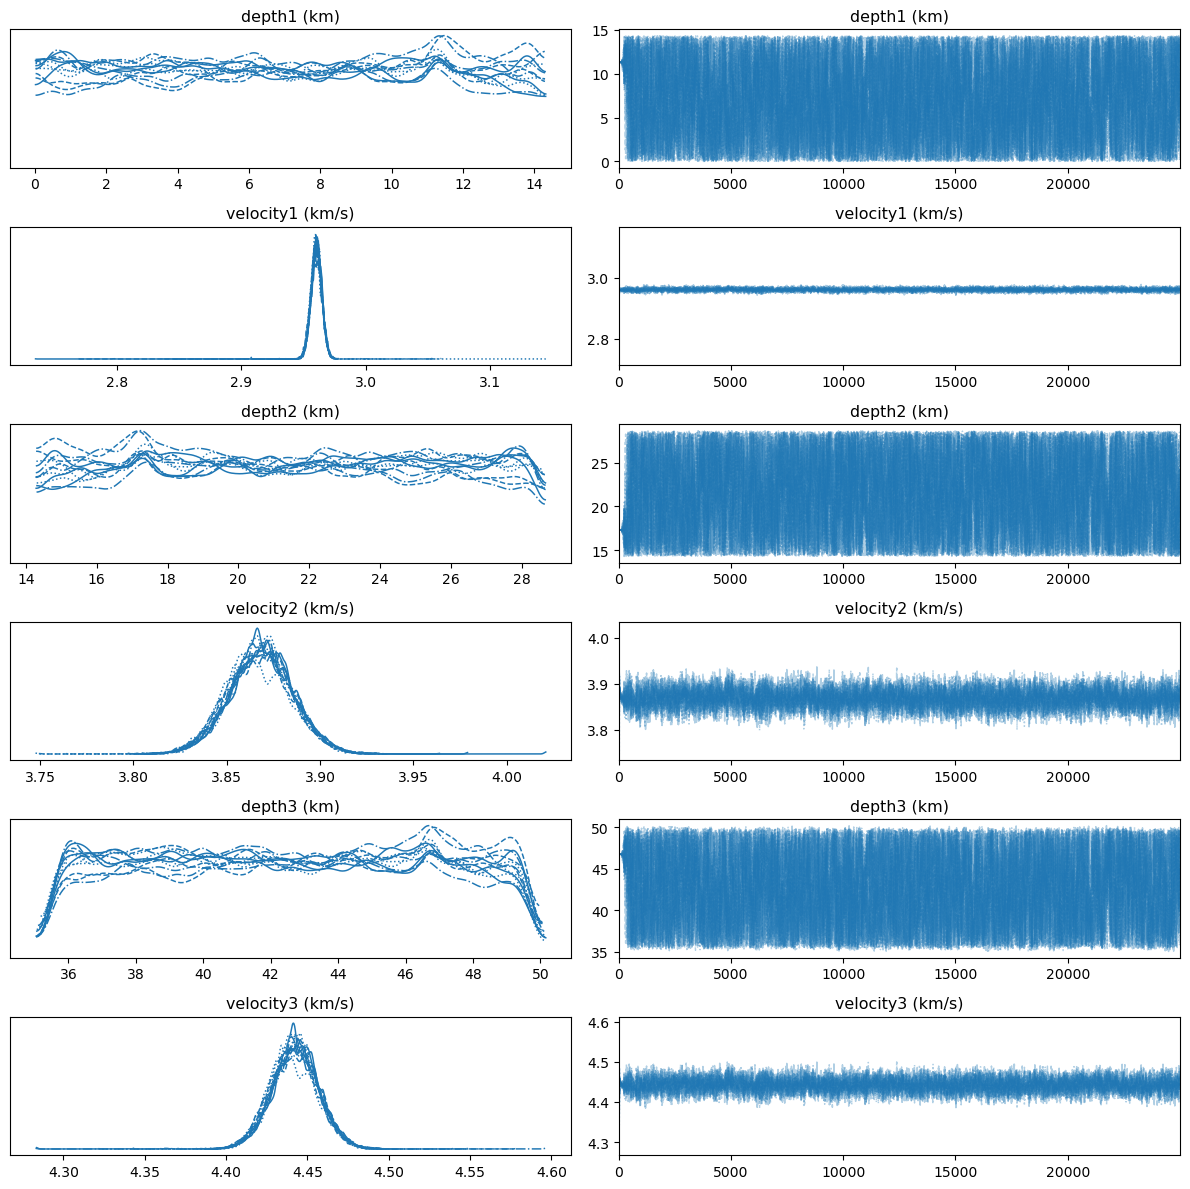

In [19]:
arviz.plot_trace(az_inf_data);
plt.tight_layout();

The walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details):

In [20]:
tau = inv_result_sampler.sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [120.64935842  83.36629501 120.8727641   90.68159476 120.18693988
  89.73412015]


Let’s discard the initial 300 steps and make a corner plot:

Reference good model: [ 8.   3.  20.   3.9 45.   4.4]


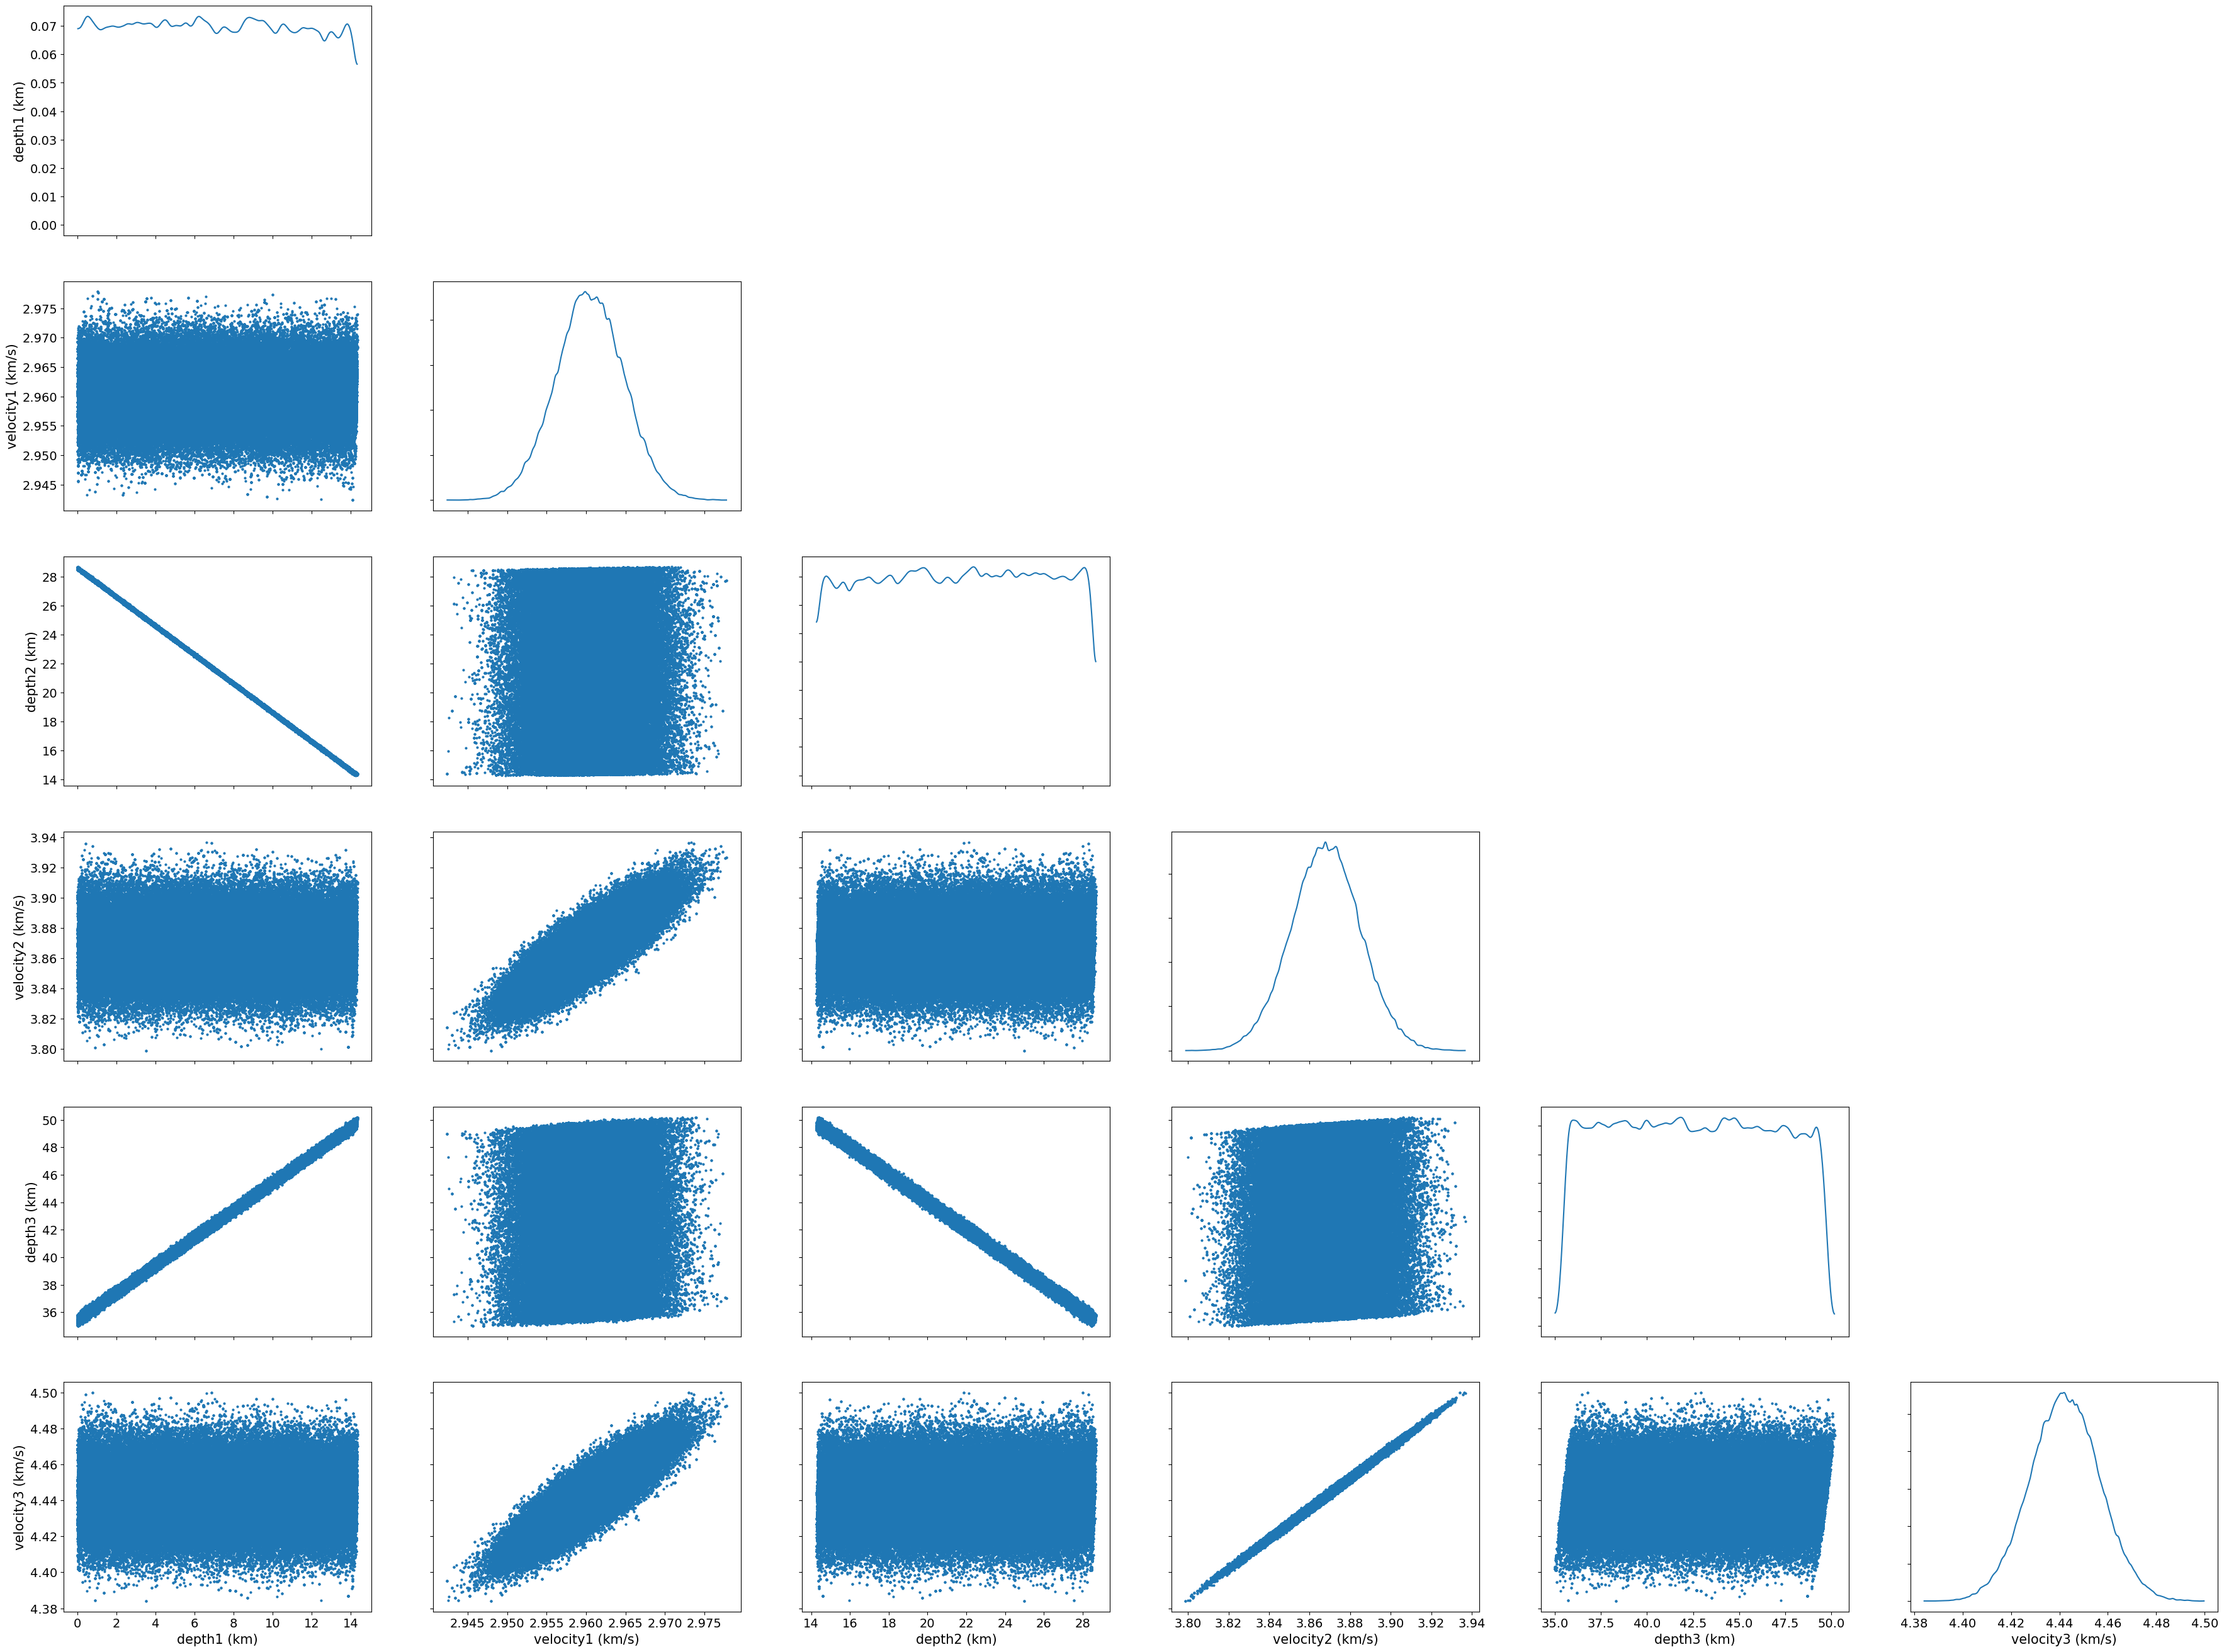

In [21]:
az_inf_data_after_300 = az_inf_data.sel(draw=slice(300,None))

arviz.plot_pair(
    az_inf_data_after_300, 
    marginals=True, 
)

print("Reference good model:", my_receiver_function.good_model)

Mean of samples:      [ 7.15043311  2.96042893 21.45168694  3.86795829 42.58738856  4.44218487]
Reference good model: [ 8.   3.  20.   3.9 45.   4.4]


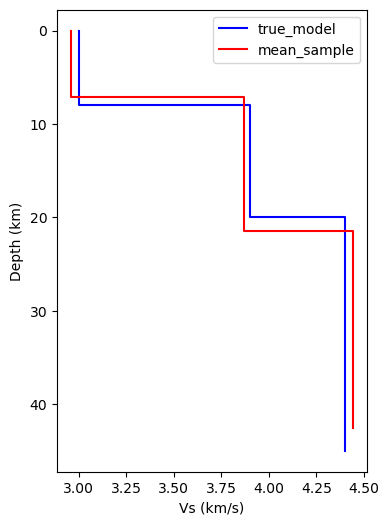

In [22]:
true_model = my_receiver_function.good_model
mean_sample = np.array(az_inf_data["posterior"].mean().to_array())
median_sample = np.array(az_inf_data["posterior"].median().to_array())

print("Mean of samples:     ", mean_sample)
print("Reference good model:", true_model)

my_receiver_function.plot_model(true_model, mean_sample, "true_model", "mean_sample")
plt.legend();

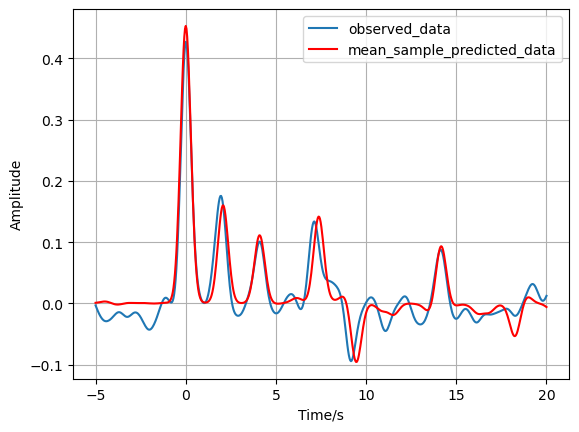

In [23]:
mean_sample_predicted_data = my_receiver_function.forward(mean_sample)
my_receiver_function.plot_data(
    observed_data, 
    mean_sample_predicted_data,
    "observed_data",
    "mean_sample_predicted_data",
);
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [24]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.7
espresso 0.3.13
numpy 1.23.5
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
